## Project 2 - Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods

Autores: Francisco Tavares, Guilherme Oliveira, Rodrigo Batista e Rodrigo Taveira

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from scipy.stats import shapiro, zscore
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pywt



# Introdução

O presente trabalho tem como objetivo principal desenvolver e avaliar modelos de previsão para os retornos de ações do índice S&P 500, com foco na aplicação de técnicas de Machine Learning, nomeadamente o **modelo Random Forest** bem como a utilização de modelos de **SVM** com e sem **ensembles**. Para além disso, são considerados portefólios financeiros otimizados, tanto a nível diário (com restrições específicas) como mensal, de modo a testar a aplicabilidade prática das previsões no contexto de gestão de investimentos.

Inicialmente, foi realizado um processamento dos dados que inclui o cálculo dos retornos logarítmicos diários, o tratamento de valores ausentes e infinitos, bem como a criação de indicadores técnicos (médias móveis, RSI, momentum, entre outros). Os dados de suporte, como índices de referência (S&P 500, Nasdaq 100, Dow Jones, VIX, entre outros) e commodities (ouro, cobre e petróleo), foram adicionados para fornecer uma visão mais ampla do mercado e aumentar a robustez do modelo.



O modelo Random Forest foi treinado e validado em dados históricos de preços das empresas do S&P 500 ( entre 2010 e 2023), tendo os resultados sido avaliados, em 2024, através de métricas como RMSE (Erro Quadrático Médio), MAE (Erro Absoluto Médio) e R² (Coeficiente de Determinação). O desempenho foi analisado setorialmente para destacar quais setores apresentaram previsões mais robustas e quais enfrentaram maiores desafios.


Foi  também incluída uma análise de robustez adicional, através da aplicação dos modelos ao índice **NASDAQ 100**, que apresenta uma forte concentração no setor tecnológico. Esta abordagem permite validar a capacidade generalizável dos modelos e identificar eventuais limitações no contexto de diferentes índices ou geografias.

Por fim, os retornos previstos foram utilizados para construir dois portefólios financeiros, usando algoritmos genéticos e o Monte Carlo :

Portefólio Diário com Restrições: Um portefólio atualizado diariamente, sujeito a restrições específicas espicificadas no material de apoio a este projeto

Portefólio Mensal: Um portefólio otimizado e reavaliado mensalmente, permitindo uma estratégia de investimento de médio prazo.

# Coleta de Dados

A abordagem utilizada para a recolha e preparação dos dados financeiros foi cuidadosamente estruturada para criar um conjunto de dados consistente, abrangente e pronto para análises ou modelação preditiva

1. *Recolha dos Índices das Empresas*

O primeiro passo foi carregar um ficheiro CSV contendo informações sobre as 500 maiores empresas, com um foco particular no símbolo (ticker) de cada empresa.Estes tickers servem como identificadores para recolher os dados financeiros históricos de cada empresa.

2. *Download de Dados Financeiros*

Utilizando a biblioteca yfinance (**Yahoo Finance API**), fez-se o download dos dados históricos  para as empresas listadas nos tickers.

    Parâmetros utilizados:

-Intervalo de tempo: De 3 de janeiro de 2010 até 31 de janeiro de 2024.

-Intervalo de dados: Dados diários (interval="1d").

-Agrupamento por Ticker: O parâmetro group_by="ticker" foi usado para estruturar os dados por empresa.

3. *Transformação e Organização dos Dados*

Os dados descarregados foram processados para garantir uma estrutura adequada e facilmente manipulável:

    Estruturação para Long Format:

Os dados inicialmente tinham um formato de MultiIndex (camadas de índices para atributos e tickers). Foi necessário transformá-los para o formato long format, onde cada linha corresponde a uma combinação de data e ticker, e as colunas representam atributos (como Open, High, Close, etc.). Os dados estão assim agrupados por data e empresa ao longo das linhas do dataset  

O dataset abaixo foi utilizado para extrair os indices das empresas do SP500 para a posterior construção do nosso dataset

In [3]:
df_indices = pd.read_csv('flat-ui__data-Mon Dec 09 2024.csv')
df_indices


Symbol               Company             GICS Sector  \
0        A  Agilent Technologies             Health Care   
1     AAPL            Apple Inc.  Information Technology   
2     ABBV                AbbVie             Health Care   
3     ABNB                Airbnb  Consumer Discretionary   
4      ABT   Abbott Laboratories             Health Care   
..     ...                   ...                     ...   
498    XYL            Xylem Inc.             Industrials   
499    YUM           Yum! Brands  Consumer Discretionary   
500    ZBH         Zimmer Biomet             Health Care   
501   ZBRA    Zebra Technologies  Information Technology   
502    ZTS                Zoetis             Health Care   

                                GICS Sub-Industry      Headquarters Location  \
0                  Life Sciences Tools & Services    Santa Clara, California   
1      Technology Hardware, Storage & Peripherals      Cupertino, California   
2                                   Biotechnology    North Chicago, Illinois   
3                  Hotels, Resorts & Cruise Lines  San Francisco, California   
4                           Health Care Equipment    North Chicago, Illinois   
..                                            ...                        ...   
498  Industrial Machinery & Supplies & Components     White Plains, New York   
499                                   Restaurants       Louisville, Kentucky   
500                         Health Care Equipment            Warsaw, Indiana   
501            Electronic Equipment & Instruments     Lincolnshire, Illinois   
502                               Pharmaceuticals     Parsippany, New Jersey   

     Date added      CIK      Founded  
0    2000-06-05  1090872         1999  
1    1982-11-30   320193         1977  
2    2012-12-31  1551152  2013 (1888)  
3    2023-09-18  1559720         2008  
4    1957-03-04     1800         1888  
..          ...      ...          ...  
498  2011-11-01  1524472         2011  
499  1997-10-06  1041061         1997  
500  2001-08-07  1136869         1927  
501  2019-12-23   877212         1969  
502  2013-06-21  1555280         1952  

[503 rows x 8 columns]

In [ ]:
tickers = [row['Symbol'] for _, row in df_indices.iterrows()]

#print(tickers)
data = yf.download(tickers, start="2010-01-03", end="2024-01-31", interval="1d", group_by="ticker")


[*                      2%                       ]  9 of 503 completedFailed to get ticker 'BRK.B' reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['GEV', 'SOLV', 'AMTM', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-03 -> 2024-01-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262494800, endDate = 1706677200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-03 -> 2024-01-31)')


In [ ]:
data_long = data.stack(level=0).reset_index()

data_long.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

data_reset = data_long.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

data_reset.to_csv("financial_data.csv", index=False)
print("Dados processados e salvos com sucesso!")

data_long

C:\Users\gjoli\AppData\Local\Temp\ipykernel_12792\3799252023.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_long = data.stack(level=0).reset_index()  # Garante que 'Date' e 'Ticker' estejam como colunas


Dados processados e salvos com sucesso!


Date Ticker        Open        High         Low       Close  \
0       2010-01-04      A   22.453505   22.625179   22.267525   22.389128   
1       2010-01-04   AAPL    7.622500    7.660714    7.585000    7.643214   
2       2010-01-04    ABT   26.000362   26.177889   25.870815   26.129908   
3       2010-01-04   ACGL    7.978889    8.022222    7.972222    7.994444   
4       2010-01-04    ACN   41.520000   42.200001   41.500000   42.070000   
...            ...    ...         ...         ...         ...         ...   
1673264 2024-01-30    XYL  112.919998  114.050003  112.190002  113.750000   
1673265 2024-01-30    YUM  130.360001  131.220001  129.580002  130.619995   
1673266 2024-01-30    ZBH  122.870003  123.199997  121.900002  122.370003   
1673267 2024-01-30   ZBRA  255.979996  255.979996  250.559998  250.910004   
1673268 2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993   

          Adj Close       Volume  
0         20.053020    3815561.0  
1          6.447412  493729600.0  
2         18.763720   10829095.0  
3          7.601905    4813200.0  
4         31.941801    3650100.0  
...             ...          ...  
1673264  112.508369     960800.0  
1673265  128.071274    1421500.0  
1673266  121.599182    1448600.0  
1673267  250.910004     302100.0  
1673268  189.982544    1607500.0  

[1673269 rows x 8 columns]

# Pré-processamento dos dados

####  Valores Nulos

In [11]:
df=pd.read_csv('financial_data.csv')

df

Date Ticker        Open        High         Low       Close  \
0        2010-01-04      A   22.453505   22.625179   22.267525   22.389128   
1        2010-01-05      A   22.324751   22.331903   22.002861   22.145924   
2        2010-01-06      A   22.067240   22.174536   22.002861   22.067240   
3        2010-01-07      A   22.017166   22.045780   21.816881   22.038628   
4        2010-01-08      A   21.917025   22.067240   21.745352   22.031473   
...             ...    ...         ...         ...         ...         ...   
1673264  2024-01-24    ZTS  188.809998  189.699997  185.929993  186.070007   
1673265  2024-01-25    ZTS  185.529999  187.529999  185.309998  187.320007   
1673266  2024-01-26    ZTS  189.210007  192.880005  188.970001  191.520004   
1673267  2024-01-29    ZTS  191.360001  193.000000  189.960007  192.759995   
1673268  2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993   

          Adj Close     Volume  
0         20.053020  3815561.0  
1         19.835199  4186031.0  
2         19.764723  3243779.0  
3         19.739098  3095172.0  
4         19.732685  3733918.0  
...             ...        ...  
1673264  184.663101  1837700.0  
1673265  185.903641  2530600.0  
1673266  190.071899  1840200.0  
1673267  191.302521  1669900.0  
1673268  189.982544  1607500.0  

[1673269 rows x 8 columns]

In [12]:
print("Missing Values Summary:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print(missing_values)

Missing Values Summary:
Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### Dados Duplicados


In [13]:
print("\nDuplicate Rows:")
duplicates = df.duplicated().sum()
print(f"Total Duplicates: {duplicates}")


Duplicate Rows:
Total Duplicates: 0


#### Tipos de Dados

In [14]:
print("\nData Types:")
print(df.dtypes)


Data Types:
Date          object
Ticker        object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [ ]:
df.to_csv("financial_tratado.csv")
df

Date Ticker        Open        High         Low       Close  \
0        2010-01-04      A   22.453505   22.625179   22.267525   22.389128   
1        2010-01-05      A   22.324751   22.331903   22.002861   22.145924   
2        2010-01-06      A   22.067240   22.174536   22.002861   22.067240   
3        2010-01-07      A   22.017166   22.045780   21.816881   22.038628   
4        2010-01-08      A   21.917025   22.067240   21.745352   22.031473   
...             ...    ...         ...         ...         ...         ...   
1673264  2024-01-24    ZTS  188.809998  189.699997  185.929993  186.070007   
1673265  2024-01-25    ZTS  185.529999  187.529999  185.309998  187.320007   
1673266  2024-01-26    ZTS  189.210007  192.880005  188.970001  191.520004   
1673267  2024-01-29    ZTS  191.360001  193.000000  189.960007  192.759995   
1673268  2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993   

          Adj Close     Volume  
0         20.053020  3815561.0  
1         19.835199  4186031.0  
2         19.764723  3243779.0  
3         19.739098  3095172.0  
4         19.732685  3733918.0  
...             ...        ...  
1673264  184.663101  1837700.0  
1673265  185.903641  2530600.0  
1673266  190.071899  1840200.0  
1673267  191.302521  1669900.0  
1673268  189.982544  1607500.0  

[1673269 rows x 8 columns]

# Feature engeneering

#### Feature creation baseado em janelas temporais

Estudos anteriores demonstraram que os indicadores técnicos podem ser úteis na previsão de preços de ações ou movimentos de mercado (Kara, Acar Boyacioglu & Baykan, 2011). Estes indicadores conseguem captar características como o momentum e a tendência do mercado, que potencialmente possuem poder preditivo. Assim, utilizamos os dados OHLCV obtidos para calcular 6 indicadores técnicos diferentes, que incluímos como variáveis neste estudo:

-Média Móvel Simples (SMA): Média de 10 dias dos preços de fecho.

-Média Móvel Ponderada (WMA): Média ponderada de 10 dias dos preços de fecho.

-Índice de Força Relativa (RSI): Indicador de momentum de 14 dias para identificar pontos de sobrecompra/sobrevenda.

-Williams %R: Indicador de 14 dias para identificar pontos de sobrecompra/sobrevenda baseado em intervalos de preços.

-Momentum: Taxa de variação ao longo de um período de 10 dias.

-Estocástico %K: Indicador de momentum de 14 dias que compara o preço de fecho com o intervalo de preços.




#### 1. Média Móvel Simples (SMA) - 10 dias
A SMA (Média Móvel Simples) é um indicador técnico que suaviza as flutuações de preços, permitindo capturar tendências subjacentes.

$$
SMA_{10} = \frac{C_t + C_{t-1} + C_{t-2} + \dots + C_{t-9}}{10}
$$

Where:
- \(C_t\): Preço de fecho em \(t\).
- \(C_{t-1}, C_{t-2}, ... , C_{t-9}\): Preço de fecho dos 9 dias anteriores.

#### 2. Média Móvel Ponderada (WMA)
A Média Móvel Ponderada (WMA) atribui pesos às observações dos preços, conferindo maior importância aos preços mais recentes. Isso torna o indicador mais sensível às mudanças recentes no movimento dos preços.
A fórmula da WMA é a seguinte:

$$
WMA_{10} = \frac{nC_t + (n-1)C_{t-1} + \dots + C_{t-9}}{n + (n-1) + \dots + 1}
$$

Where:
- \(C_t\): Preço de fecho em  \(t\).
- \(n\): Window length (10 neste caso).

#### 3. Índice de Força Relativa (RSI)
O Índice de Força Relativa (RSI) é um indicador de momentum amplamente reconhecido, que quantifica a magnitude das mudanças recentes no preço. É útil para identificar pontos onde um ativo pode estar sobrecomprado ou sobrevendido.
A fórmula do RSI é:

$$
RSI = 100 - \frac{100}{1 + \frac{\sum_{i=0}^{n-1} Up_{t-i}/n}{\sum_{i=0}^{n-1} Dw_{t-i}/n}}
$$

Where:
- \(Up_{t-i}\): Variação positiva no tempo \(t-i\).
- \(Dw_{t-i}\): Variação negativa no tempo \(t-i\).
- \(n\): Window length (e.g., 14 dias).

#### 4.Momentum

O  Momentum é um indicador técnico que mede a taxa de variação no preço de um ativo. É calculado como a diferença entre o preço de fechamento no tempo T e o preço de fechamento no tempo T- K , onde k representa o numero de periodos de tempo

$$
MOMENTUM =  𝐶_𝑡 − {{𝐶}_{𝑡−9}} 
$$

Where:
- \(C_t\): Preço de fechamento do ativo ou título no período atual \(t\).
- \(C_{t-9}\): Preço de fechamento do mesmo ativo 9 dias de negociação antes. 

#### 5. Stochastic %K

O Stochastic %K é um indicador de momentum que compara o preço de fechamento atual de um ativo em relação ao intervalo de preços ao longo de um período selecionado. Neste estudo, utiliza-se o valor padrão de 14 dias. O Stochastic %K fornece informações sobre o momentum e potenciais pontos de reversão, o que pode ajudar os modelos a capturar tendências de mercado de curto prazo.

A fórmula para o Stochastic %K pode ser expressa como:


### Stochastic %K

The formula for Stochastic %K is:

$$
Stochastic  = \frac{C_t - LL_{t-n}}{HH_{t-n} - LL_{t-n}}
$$

Where:
- \(C_t\): Preço de fecho em \(t\).
- \(HH_{t-n}\): Preço mais alto nos ultimos \(n\) dias.
- \(LL_{t-n}\): Preço mais baixo nos ultimos \(n\) dias.


In [ ]:
import pandas as pd
import pandas_ta as ta 

df = pd.read_csv("financial_tratado.csv")

sp500_data = df.copy()

tickers = df['Ticker'].unique()

result = []

for ticker in tickers:
    df_ticker = df[df['Ticker'] == ticker].copy()

    df_ticker['SMA_10'] = ta.sma(df_ticker['Close'], length=10)
    df_ticker['WMA_10'] = ta.wma(df_ticker['Close'], length=10)
    df_ticker['RSI_14'] = ta.rsi(df_ticker['Close'], length=14)
    df_ticker['Momentum_10'] = ta.mom(df_ticker['Close'], length=10)
    df_ticker['Stochastic_%K_14'] = ta.stoch(
        df_ticker['High'], df_ticker['Low'], df_ticker['Close'], k=14
    )["STOCHk_14_3_3"]

    df_ticker['Volume_SMA_10'] = ta.sma(df_ticker['Volume'], length=10)

    result.append(df_ticker)

sp500_with_indicators = pd.concat(result)

In [ ]:
sp500_with_indicators = sp500_with_indicators.drop(columns=["Unnamed: 0"])

sp500_with_indicators.to_csv("sp500_with_indicators.csv", index=False)

sp500_with_indicators


Date Ticker        Open        High         Low       Close  \
0        2010-01-04      A   22.453505   22.625179   22.267525   22.389128   
1        2010-01-05      A   22.324751   22.331903   22.002861   22.145924   
2        2010-01-06      A   22.067240   22.174536   22.002861   22.067240   
3        2010-01-07      A   22.017166   22.045780   21.816881   22.038628   
4        2010-01-08      A   21.917025   22.067240   21.745352   22.031473   
...             ...    ...         ...         ...         ...         ...   
1673264  2024-01-24    ZTS  188.809998  189.699997  185.929993  186.070007   
1673265  2024-01-25    ZTS  185.529999  187.529999  185.309998  187.320007   
1673266  2024-01-26    ZTS  189.210007  192.880005  188.970001  191.520004   
1673267  2024-01-29    ZTS  191.360001  193.000000  189.960007  192.759995   
1673268  2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993   

          Adj Close     Volume      SMA_10      WMA_10     RSI_14  \
0         20.053020  3815561.0         NaN         NaN        NaN   
1         19.835199  4186031.0         NaN         NaN        NaN   
2         19.764723  3243779.0         NaN         NaN        NaN   
3         19.739098  3095172.0         NaN         NaN        NaN   
4         19.732685  3733918.0         NaN         NaN        NaN   
...             ...        ...         ...         ...        ...   
1673264  184.663101  1837700.0  192.256003  190.187821  40.159881   
1673265  185.903641  2530600.0  191.111003  189.290367  42.837020   
1673266  190.071899  1840200.0  190.592003  189.364731  50.801445   
1673267  191.302521  1669900.0  189.974002  189.758911  52.888439   
1673268  189.982544  1607500.0  189.818001  190.023637  50.418006   

         Momentum_10  Stochastic_%K_14  Volume_SMA_10  
0                NaN               NaN            NaN  
1                NaN               NaN            NaN  
2                NaN               NaN            NaN  
3                NaN               NaN            NaN  
4                NaN               NaN            NaN  
...              ...               ...            ...  
1673264    -9.869995         13.437572      1996970.0  
1673265   -11.449997          7.423153      2117510.0  
1673266    -5.190002         19.206322      2142580.0  
1673267    -6.180008         35.973390      2136920.0  
1673268    -1.560013         45.674822      2066050.0  

[1673269 rows x 14 columns]


O nosso conjunto de dados contém muitos valores NaN porque indicadores técnicos como o SMA, RSI e outros necessitam de um número mínimo de pontos de dados para serem calculados. Por exemplo:

O SMA_10 requer pelo menos 10 linhas de dados.
O RSI_14 exige 14 linhas de dados.

Isto significa que as primeiras linhas destas colunas terão naturalmente valores NaN devido à insuficiência de dados para o cálculo. Além disso, valores NaN podem surgir devido a dados em falta durante o processo de recolha de informações.


Aqui tratamos dos valores nulos obtidos no dataset dos indicadores tecnicos e em baixo temos algumas cenas que podemos apagar depois (correlação e visualizaçao dos dados para ver se esta tudo em ordem)


#### Tratamento dos valores nulos  das features temporais criadas

Foram contabilizados os valores NaN (ausentes) em cada coluna e a percentagem correspondente, para entender a extensão do problema de dados ausentes.

Preenchimento de valores ausentes:

Inicialmente, os valores ausentes foram preenchidos com zero, abordando os NaN iniciais que surgem frequentemente devido ao cálculo de indicadores técnicos como SMA ou RSI.
Posteriormente, após obtermos valores nao nulos, foi utilizado o método forward-fill (preenchimento propagado para frente), garantindo que as lacunas restantes fossem preenchidas com os valores mais recentes conhecidos.

In [ ]:
sp500_data = pd.read_csv("sp500_with_indicators.csv", index_col=0, parse_dates=True)

print("Missing Values (per column):")
print(sp500_data.isnull().sum())

missing_percentage = sp500_data.isnull().mean() * 100
print("\nMissing Percentage (per column):")
print(missing_percentage)

sp500_data = sp500_data.fillna(0).apply(lambda x: x.ffill())

print("\nMissing Values After Preprocessing:")
print(sp500_data.isnull().sum())

sp500_data.to_csv("sp500_data_cleaned.csv")

#print(sp500_data)
sp500_data

Missing Values (per column):
Ticker                 0
Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
SMA_10              4473
WMA_10              4473
RSI_14              6960
Momentum_10         4970
Stochastic_%K_14    7455
Volume_SMA_10       4473
dtype: int64

Missing Percentage (per column):
Ticker              0.000000
Open                0.000000
High                0.000000
Low                 0.000000
Close               0.000000
Adj Close           0.000000
Volume              0.000000
SMA_10              0.267321
WMA_10              0.267321
RSI_14              0.415952
Momentum_10         0.297023
Stochastic_%K_14    0.445535
Volume_SMA_10       0.267321
dtype: float64

Missing Values After Preprocessing:
Ticker              0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
SMA_10          

Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2010-01-04      A   22.453505   22.625179   22.267525   22.389128   20.053020   
2010-01-05      A   22.324751   22.331903   22.002861   22.145924   19.835199   
2010-01-06      A   22.067240   22.174536   22.002861   22.067240   19.764723   
2010-01-07      A   22.017166   22.045780   21.816881   22.038628   19.739098   
2010-01-08      A   21.917025   22.067240   21.745352   22.031473   19.732685   
...           ...         ...         ...         ...         ...         ...   
2024-01-24    ZTS  188.809998  189.699997  185.929993  186.070007  184.663101   
2024-01-25    ZTS  185.529999  187.529999  185.309998  187.320007  185.903641   
2024-01-26    ZTS  189.210007  192.880005  188.970001  191.520004  190.071899   
2024-01-29    ZTS  191.360001  193.000000  189.960007  192.759995  191.302521   
2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993  189.982544   

               Volume      SMA_10      WMA_10     RSI_14  Momentum_10  \
Date                                                                    
2010-01-04  3815561.0    0.000000    0.000000   0.000000     0.000000   
2010-01-05  4186031.0    0.000000    0.000000   0.000000     0.000000   
2010-01-06  3243779.0    0.000000    0.000000   0.000000     0.000000   
2010-01-07  3095172.0    0.000000    0.000000   0.000000     0.000000   
2010-01-08  3733918.0    0.000000    0.000000   0.000000     0.000000   
...               ...         ...         ...        ...          ...   
2024-01-24  1837700.0  192.256003  190.187821  40.159881    -9.869995   
2024-01-25  2530600.0  191.111003  189.290367  42.837020   -11.449997   
2024-01-26  1840200.0  190.592003  189.364731  50.801445    -5.190002   
2024-01-29  1669900.0  189.974002  189.758911  52.888439    -6.180008   
2024-01-30  1607500.0  189.818001  190.023637  50.418006    -1.560013   

            Stochastic_%K_14  Volume_SMA_10  
Date                                         
2010-01-04          0.000000            0.0  
2010-01-05          0.000000            0.0  
2010-01-06          0.000000            0.0  
2010-01-07          0.000000            0.0  
2010-01-08          0.000000            0.0  
...                      ...            ...  
2024-01-24         13.437572      1996970.0  
2024-01-25          7.423153      2117510.0  
2024-01-26         19.206322      2142580.0  
2024-01-29         35.973390      2136920.0  
2024-01-30         45.674822      2066050.0  

[1673269 rows x 13 columns]

# Instrumentos financeiros adicionais

O mercado de ações é fortemente influenciado por outros fatores económicos que nos decidimos incluir nos nosso dados.

Foram integrados os seguintes índices e futuros ao conjunto de dados original:

**^GSPC**: S&P 500 Index - Representa o desempenho geral do mercado de ações dos EUA.

**^DJI**: Dow Jones Industrial Average - Captura o sentimento mais amplo do mercado norte-americano.

**^VIX**: CBOE Volatility Index - Mede a volatilidade do mercado e o sentimento dos investidores.

**CL=F**: Futuros do Petróleo Bruto (Crude Oil Futures) - Proxy para a dinâmica do mercado energético.

**HG=F**: Futuros do Cobre (Copper Futures) - Indicador para a atividade industrial.

**GC=F**: Futuros do Ouro (Gold Futures) - Um ativo de refúgio seguro, frequentemente utilizado em momentos de incerteza económica.

#### Motivação para a Inclusão

**Captação de Sentimento e Dinâmica do Mercado**:

^GSPC e ^DJI: São os principais índices do mercado norte-americano, essenciais para avaliar a saúde global do mercado de ações.
^VIX: Indica a volatilidade esperada no mercado e reflete o sentimento de risco dos investidores.

**Mercados de Matérias-Primas**:

CL=F, HG=F, GC=F:
-O petróleo reflete a saúde do mercado energético global, impactando os custos de transporte e produção.

-O cobre é amplamente utilizado na indústria, sendo um indicador chave da atividade económica.

-O ouro é considerado um ativo de refúgio, utilizado para proteger contra a incerteza ou instabilidade económica.

#### Processamento dos Dados Adicionados:

    Seleção de Métricas Relevantes:

Selecionámos os preços ajustados de fecho (Adj Close) e os volumes de negociação (Volume) para análise, pois estes refletem valores corrigidos para eventos como dividendos ou splits de ações.

    Preenchimento de Dados em Falta:

Utilizámos técnicas como forward-fill (preenchimento para frente) e backfill (preenchimento para trás) para lidar com lacunas nos dados.
Cálculo de Retornos Diários:

Para cada ticker, foi calculado o retorno percentual diário (Return), uma métrica fundamental para modelar tendências de preços e analisar a volatilidade do mercad

In [ ]:
import yfinance as yf
import pandas as pd

tickers = ["^GSPC", "^DJI", "^VIX", "CL=F", "HG=F", "GC=F"]

df = pd.read_csv("sp500_data_cleaned.csv")

df['Date'] = pd.to_datetime(df['Date'])

indices = yf.download(tickers, start=df['Date'].min(), end=df['Date'].max(), interval="1d")

adj_close = indices['Adj Close'].reset_index()
volume = indices['Volume'].reset_index()

adj_close = adj_close.rename(columns={
    "^GSPC": "SP500_Adj_Close",
    "^DJI": "DJI_Adj_Close",
    "^VIX": "VIX_Adj_Close",
    "CL=F": "CrudeOil_Adj_Close",
    "HG=F": "Copper_Adj_Close",
    "GC=F": "Gold_Adj_Close"
})

volume = volume.rename(columns={
    "^GSPC": "SP500_Volume",
    "^DJI": "DJI_Volume",
    "^VIX": "VIX_Volume",
    "CL=F": "CrudeOil_Volume",
    "HG=F": "Copper_Volume",
    "GC=F": "Gold_Volume"
})

df = pd.merge(df, adj_close, on='Date', how='left')
df = pd.merge(df, volume, on='Date', how='left')
df = df.drop(columns=["VIX_Volume","SP500_Volume"])
df = df.fillna(method='ffill').fillna(method='bfill')

df = df.sort_values(by=['Ticker', 'Date'])

df['Return'] = df.groupby('Ticker')['Close'].pct_change()

df = df.dropna(subset=['Return'])

df.to_csv("sp500_data_with_indices_and_volume.csv", index=False)

print("\nMissing Values After Preprocessing:")
print(df.isnull().sum().sum())


[*********************100%***********************]  6 of 6 completed
C:\Users\gjoli\AppData\Local\Temp\ipykernel_12792\1855266768.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')



Missing Values After Preprocessing:
0


#### Normalização dos Dados

Todas as colunas do conjunto de dados foram convertidas para valores numéricos, com valores inválidos forçados a NaN.



    Teste de Normalidade:
Foi aplicado o teste de **Shapiro-Wilk** a cada coluna para determinar se os dados seguiam uma distribuição normal.

As colunas foram categorizadas da seguinte forma:


-Colunas Normais: p-valor > 0,05 (distribuição normal).

-Colunas Não Normais: p-valor <= 0,05 (não seguem uma distribuição normal).

    Normalização e Padronização:

Colunas Não Normais: Normalizadas utilizando a escala **Min-Max**, para trazer os valores para um intervalo entre 0 e 1.

Colunas Normais: Padronizadas utilizando o **Z-Score** para centralizar os dados (média = 0, desvio padrão = 1).

In [27]:
combined_data=pd.read_csv("sp500_data_with_indices_and_volume.csv")



In [ ]:
normality_results = {}

for col in combined_data.columns:
    try:
        is_normal = shapiro(combined_data[col].dropna())[1] > 0.05  # p-value > 0.05 indicates normality
        normality_results[col] = is_normal
    except Exception as e:
        print(f"Error checking normality for column {col}: {e}")
        normality_results[col] = None

normal_columns = [col for col, is_normal in normality_results.items() if is_normal]
non_normal_columns = [col for col, is_normal in normality_results.items() if is_normal == False]

print("Normal columns:", normal_columns)
print("Non-normal columns:", non_normal_columns)

if non_normal_columns:
    scaler = MinMaxScaler()
    combined_data[non_normal_columns] = scaler.fit_transform(combined_data[non_normal_columns])

if normal_columns:
    combined_data[normal_columns] = zscore(combined_data[normal_columns])

combined_data.to_csv("combined_financial_normalized.csv", index=False)

Error checking normality for column Date: could not convert string to float: '2010-01-05'
Error checking normality for column Ticker: could not convert string to float: 'A'


c:\Users\gjoli\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1672772.
  res = hypotest_fun_out(*samples, **kwds)


Normal columns: []
Non-normal columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_10', 'WMA_10', 'RSI_14', 'Momentum_10', 'Stochastic_%K_14', 'Volume_SMA_10', 'CrudeOil_Adj_Close', 'Gold_Adj_Close', 'Copper_Adj_Close', 'DJI_Adj_Close', 'SP500_Adj_Close', 'VIX_Adj_Close', 'CrudeOil_Volume', 'Gold_Volume', 'Copper_Volume', 'DJI_Volume', 'Return']


#### Criação da variável de Target dos modelos

Para derivar as target do nosso problema de regressão, calculamos os retornos diários para cada empresa utilizando a seguinte fórmula:


$$
\text Return = \left(\frac{P_t - P_{t-1}}{P_{t-1}}\right)
$$


Onde Pt é o preço de fecho  do de cada empresa no momento e Pt-1 é o preço de fecho  do dia anterior.
 



# Análise exploratória de Dados

In [26]:
df = pd.read_csv("combined_financial_normalized.csv")


No código abaixo iremos visualizar os diferentes setores das empresas do SP500, análise que posteriormente nos será util na avaliação dos nossos modelos por setor e para que nos seja possível como é que cada setor financeiro se comporta neste tipo de dados

Unique sectors in the dataset:
['Health Care' 'Information Technology' 'Consumer Discretionary'
 'Financials' 'Consumer Staples' 'Industrials' 'Utilities' 'Materials'
 'Real Estate' 'Energy' 'Communication Services']


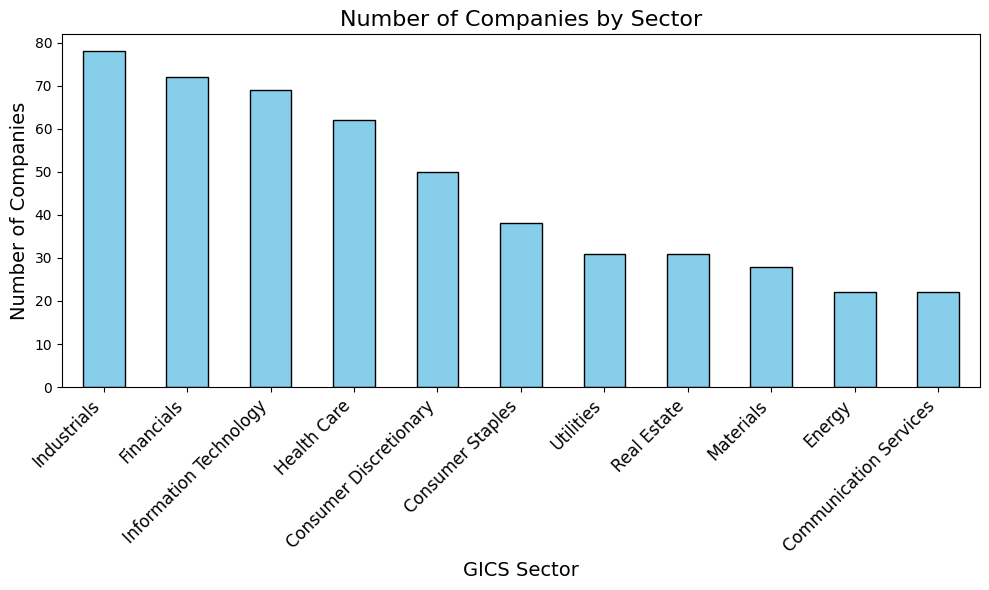


Example companies from each sector:
               GICS Sector Symbol
0   Communication Services   CHTR
1   Consumer Discretionary   ABNB
2         Consumer Staples    ADM
3                   Energy    APA
4               Financials   ACGL
5              Health Care      A
6              Industrials    ADP
7   Information Technology   AAPL
8                Materials    ALB
9              Real Estate    AMT
10               Utilities    AEE


In [ ]:
df_indices = pd.read_csv('flat-ui__data-Mon Dec 09 2024.csv')  

unique_sectors = df_indices['GICS Sector'].unique()
print("Unique sectors in the dataset:")
print(unique_sectors)

sector_counts = df_indices['GICS Sector'].value_counts()

plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Companies by Sector', fontsize=16)
plt.xlabel('GICS Sector', fontsize=14)
plt.ylabel('Number of Companies', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

sector_examples = df_indices.groupby('GICS Sector').first().reset_index()
print("\nExample companies from each sector:")
print(sector_examples[['GICS Sector', 'Symbol']])

#### 1.  Comparação dos Preços Atuais com a Moving Average

 


Aqui iremos comparar as médias móveis (MA) com os preços atuais, pois isso permite-nos identificar tendências e potenciais pontos de entrada ou saída no mercado. As médias móveis suavizam as flutuações diárias, destacando a direção geral do movimento dos preços. Ao fazer esta comparação, conseguimos:

    Identificar Tendências Gerais:

Quando os preços estão consistentemente acima da média móvel, isso indica uma tendência de alta.

Quando os preços estão abaixo da média móvel, sugere uma tendência de baixa.

    Detetar Padrões de Reversão:

A convergência ou cruzamento entre os preços e a média móvel pode sinalizar uma inversão da tendência. Por exemplo, se o preço cruza para baixo de uma média móvel, isso pode indicar o início de uma tendência de baixa.

    Avaliar a Força da Tendência:

Quanto maior for a distância entre o preço atual e a média móvel, mais forte tende a ser a tendência (embora uma divergência muito acentuada possa também sugerir sobrecompra ou sobrevenda).

    Identificar Anomalias:

Divergências significativas entre o preço e a média móvel podem ser sinais de eventos incomuns, como notícias corporativas, choques económicos ou mudanças súbitas na procura ou oferta.



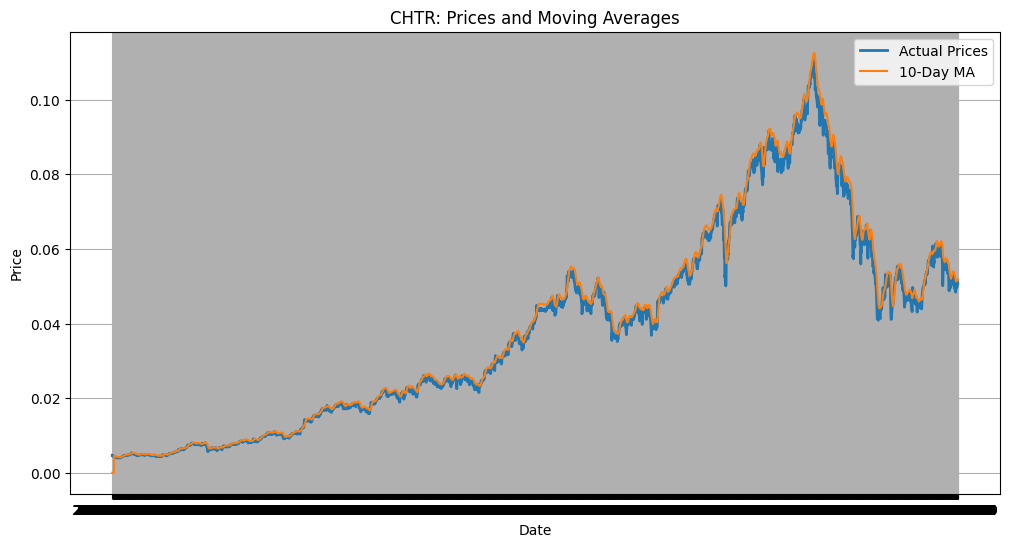

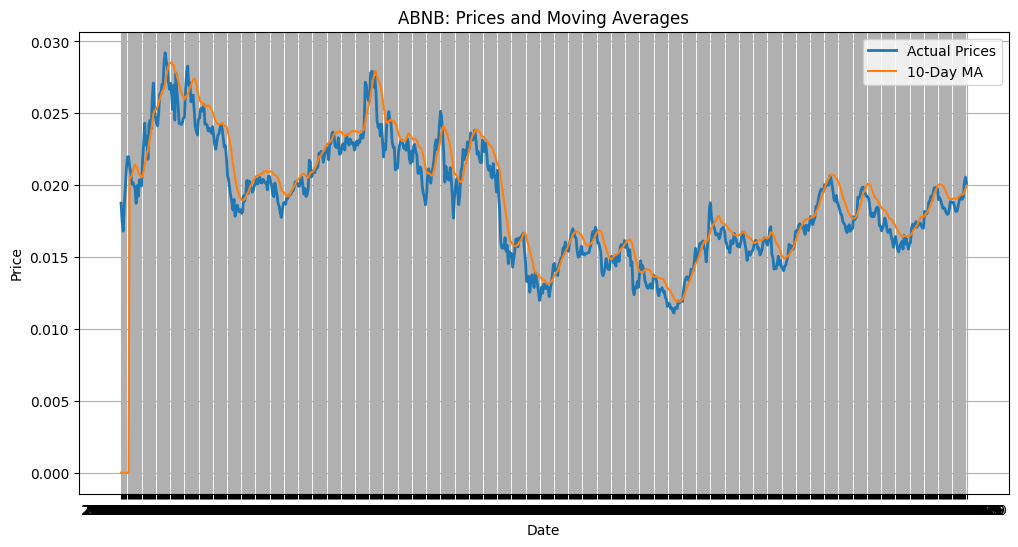

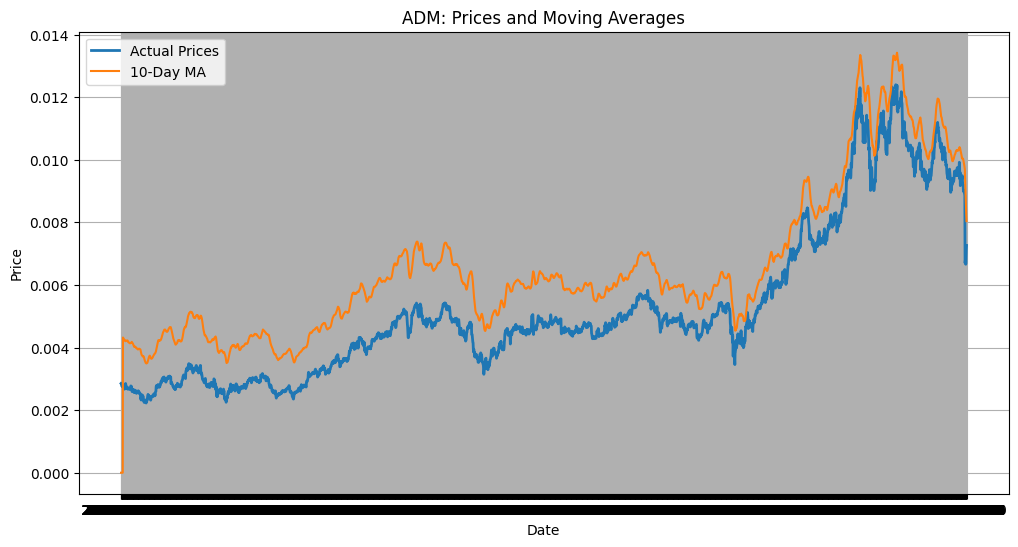

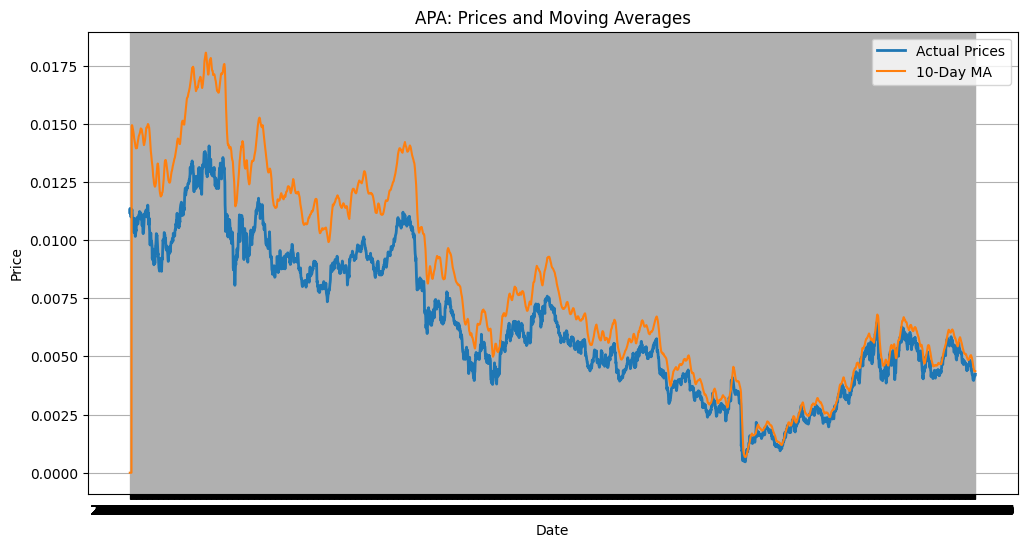

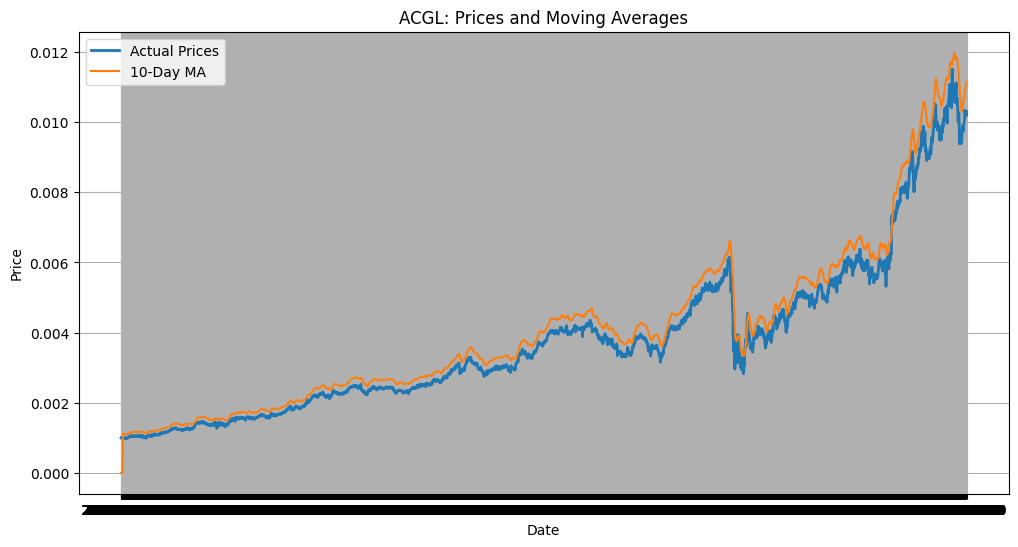

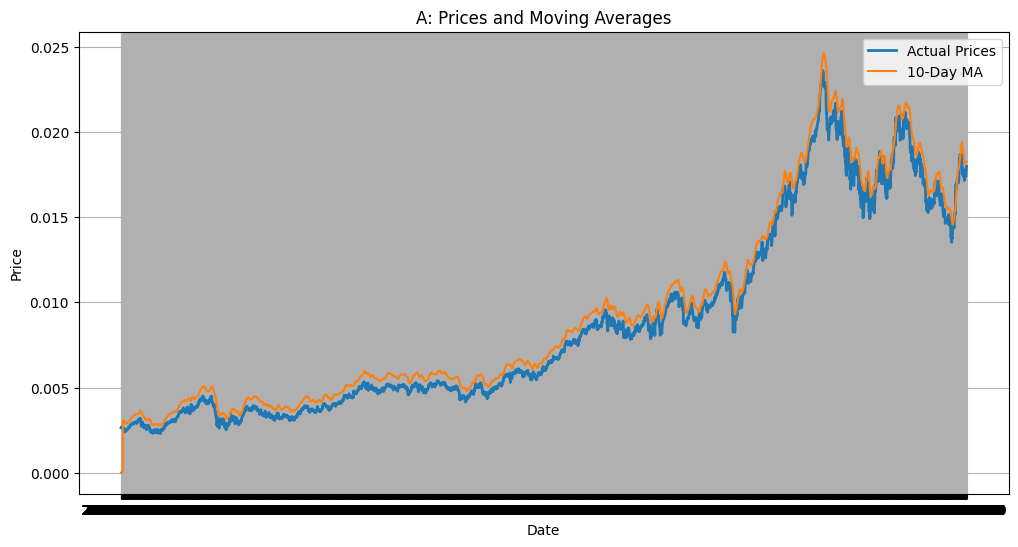

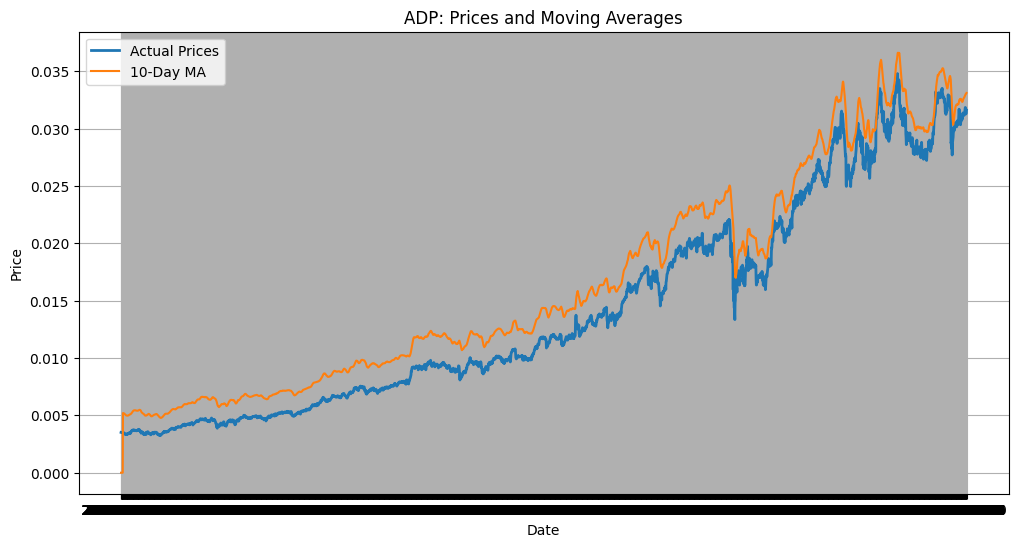

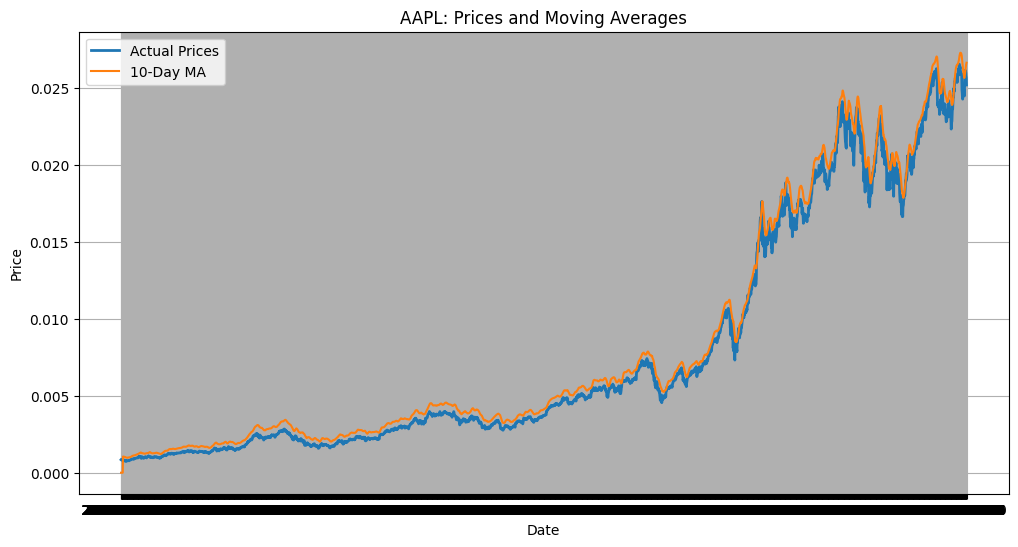

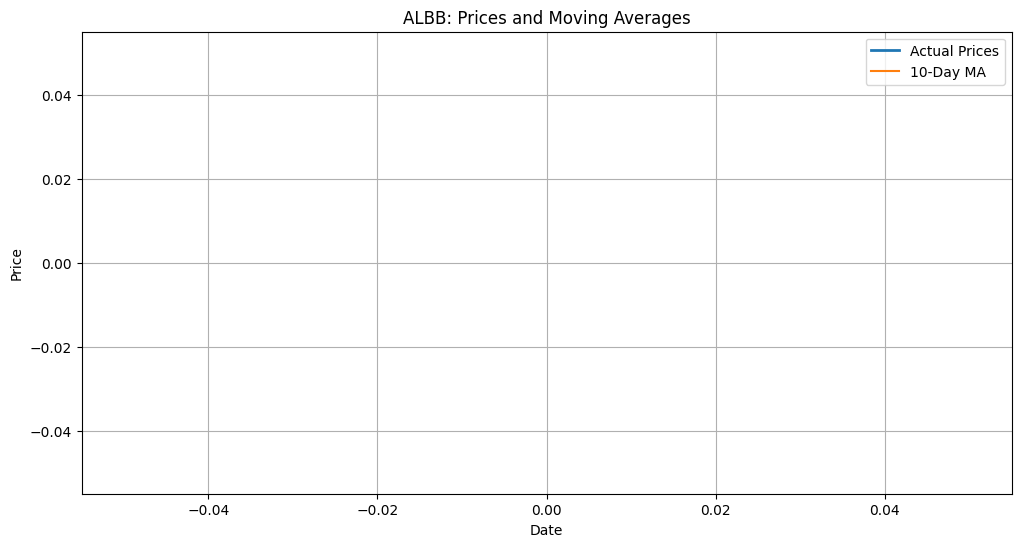

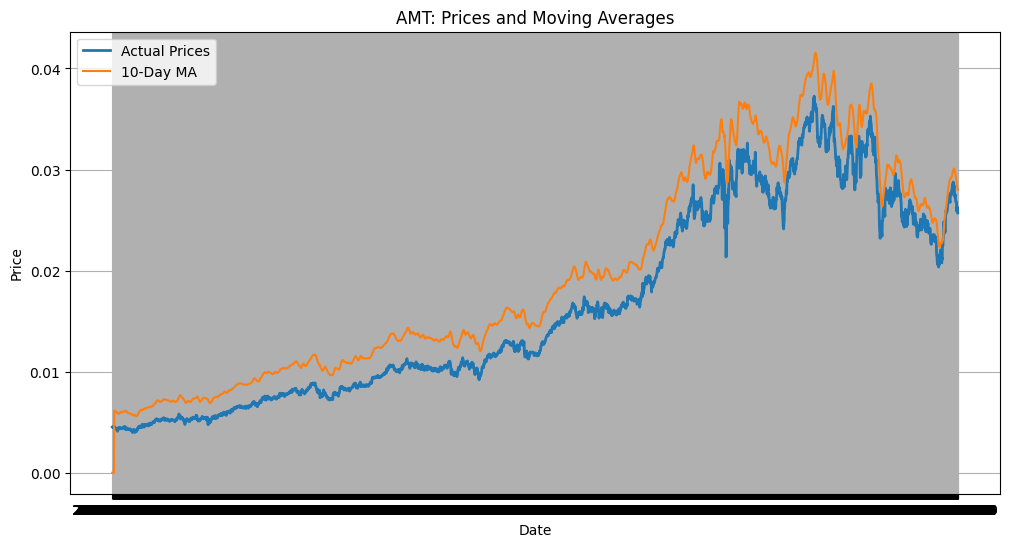

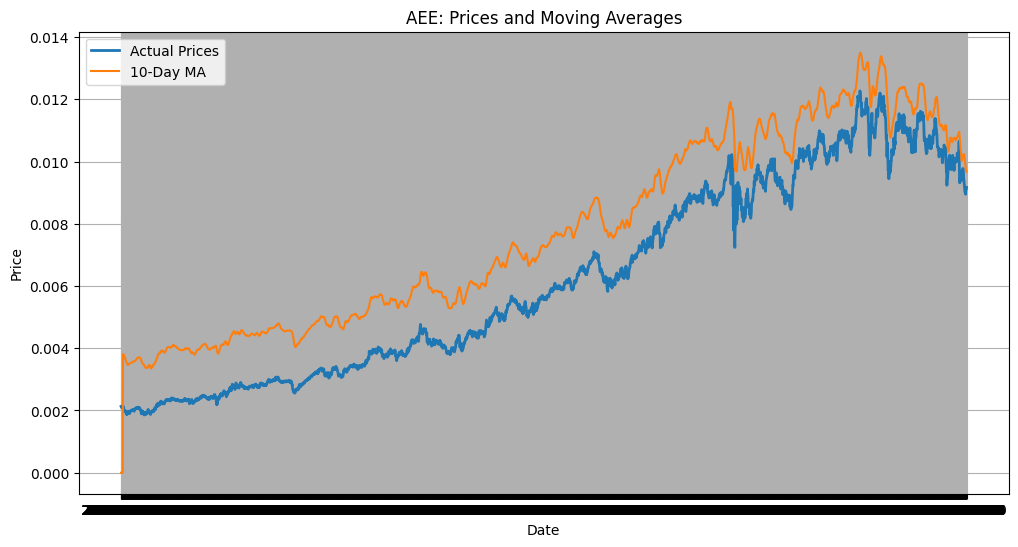

In [ ]:
def plot_price_with_moving_averages(df, ticker, ma_periods=[10, 50]):
    df_ticker = df[df['Ticker'] == ticker]

    plt.figure(figsize=(12, 6))
    plt.plot(df_ticker['Date'], df_ticker['Adj Close'], label='Actual Prices', linewidth=2)

    for period in ma_periods:
        ma_col = f'SMA_{period}'
        if ma_col in df_ticker.columns:
            plt.plot(df_ticker['Date'], df_ticker[ma_col], label=f'{period}-Day MA')

    plt.title(f"{ticker}: Prices and Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


plot_price_with_moving_averages(df, ticker='CHTR', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='ABNB', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='ADM', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='APA', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='ACGL', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='A', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='ADP', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='AAPL', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='ALBB', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='AMT', ma_periods=[10, 50])
plot_price_with_moving_averages(df, ticker='AEE', ma_periods=[10, 50])




Através da análise dos gráficos ,  a evolução dos preços da ação AAPL, em representação do setor tecnológico, em comparação com a sua Média Móvel de 10 dias, destaca a natureza dinâmica e volátil do mercado financeiro do setor financeiro. Ao longo do tempo, é evidente que os preços apresentam tendências de crescimento acompanhadas de oscilações significativas, onde períodos de rápida valorização são intercalados com correções e quedas.

Esta volatilidade sublinha a necessidade de um monitoramento constante e análise rigorosa do mercado, uma vez que movimentos imprevisíveis podem ocorrer a qualquer momento. A proximidade entre os preços reais e a média móvel de curto prazo indica como os investidores devem estar atentos às flutuações diárias e aos padrões emergentes, aproveitando oportunidades de compra ou venda, e por isso , o setor tecnológico será um setor que requererá uma maior atenção da nossa parte

#### 2. Identificação de anomalias no return com o método Z-Score

No código abaixo fomos tentar detetar anomalias no nosso target  através do metodo Z-Score


A detecção de anomalias com Z-scores é uma ferramenta útil para identificar movimentos extremos no mercado financeiro. Estes movimentos podem ser causados por fatores externos, como:

Crises econômicas ou financeiras.

Eventos específicos da empresa (lucros, fusões, problemas legais).


Eventos globais, como pandemias ou instabilidade política.

A identificação destes momentos é crucial para investidores e analistas, pois pode ajudar a entender padrões, antecipar riscos e adaptar estratégias de investimento. O gráfico ilustra de forma clara esses momentos fora do padrão, facilitando a análise visual e a interpretação dos resultados.








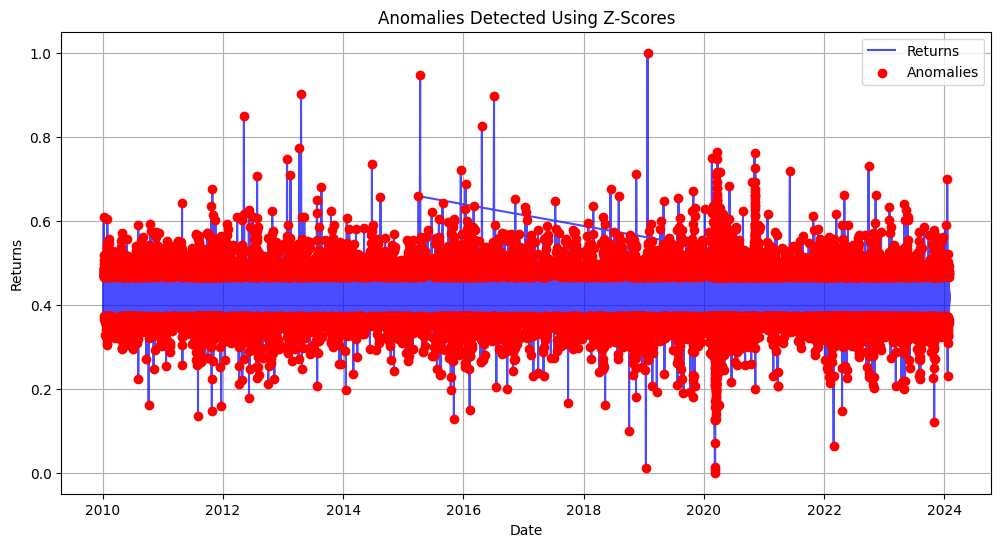

In [ ]:
import numpy as np

def detect_anomalies_zscore(df, column='Return', threshold=3):
    df['Z_Score'] = (df[column] - df[column].mean()) / df[column].std()
    anomalies = df[np.abs(df['Z_Score']) > threshold]

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df[column], label='Returns', color='blue', alpha=0.7)
    plt.scatter(anomalies['Date'], anomalies[column], color='red', label='Anomalies', zorder=5)
    plt.title("Anomalies Detected Using Z-Scores")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid()
    plt.show()

    return anomalies

anomalies_z = detect_anomalies_zscore(df, column='Return', threshold=3)



In [14]:
anomalies_z

Date Ticker      Open      High       Low     Close  Adj Close  \
86       2010-05-10      A  0.003193  0.003267  0.003222  0.003268   0.002926   
92       2010-05-18      A  0.003272  0.003250  0.003108  0.003063   0.002743   
104      2010-06-04      A  0.003040  0.003025  0.002948  0.002897   0.002594   
155      2010-08-17      A  0.002762  0.002815  0.002772  0.002794   0.002502   
293      2011-03-04      A  0.004180  0.004480  0.004243  0.004479   0.004011   
...             ...    ...       ...       ...       ...       ...        ...   
1671959  2020-11-04    ZTS  0.022506  0.023701  0.022842  0.023481   0.022749   
1672462  2022-11-03    ZTS  0.018184  0.018041  0.017079  0.017654   0.017325   
1672467  2022-11-10    ZTS  0.018750  0.019235  0.018815  0.019201   0.018842   
1672639  2023-07-21    ZTS  0.023394  0.024870  0.023746  0.024716   0.024417   
1672712  2023-11-02    ZTS  0.021056  0.021769  0.021360  0.021668   0.021458   

           Volume    SMA_10    WMA_10  ...  Copper_Adj_Close  DJI_Adj_Close  \
86       0.001536  0.003514  0.003426  ...          0.426660       0.038352   
92       0.004472  0.003367  0.003345  ...          0.362268       0.028780   
104      0.001637  0.003159  0.003145  ...          0.292022       0.008569   
155      0.002764  0.002833  0.002805  ...          0.467637       0.025112   
293      0.005054  0.004227  0.004234  ...          0.847132       0.086690   
...           ...       ...       ...  ...               ...            ...   
1671959  0.000922  0.022677  0.022697  ...          0.388527       0.633965   
1672462  0.002184  0.020717  0.020413  ...          0.507443       0.778957   
1672467  0.001186  0.019767  0.019253  ...          0.621007       0.838793   
1672639  0.001177  0.024009  0.024042  ...          0.623348       0.891585   
1672712  0.001120  0.022359  0.021950  ...          0.577856       0.843112   

         SP500_Adj_Close  VIX_Adj_Close  CrudeOil_Volume  Gold_Volume  \
86              0.035118       0.267845         0.195417     0.000305   
92              0.025150       0.331883         0.090192     0.000189   
104             0.010831       0.358124         0.196000     0.002770   
155             0.017914       0.206526         0.151834     0.000217   
293             0.076452       0.134874         0.161325     0.000155   
...                  ...            ...              ...          ...   
1671959         0.619883       0.277770         0.190977     0.002024   
1672462         0.690670       0.219714         0.104804     0.003694   
1672467         0.751223       0.195649         0.148590     0.000841   
1672639         0.899730       0.060639         0.134648     0.000129   
1672712         0.843766       0.088647         0.134218     0.000101   

         Copper_Volume  DJI_Volume    Return   Z_Score  
86            0.003035    0.335992  0.475987  3.637743  
92            0.004231    0.262192  0.371048 -3.165743  
104           0.003665    0.273463  0.369823 -3.245182  
155           0.002380    0.201558  0.480082  3.903234  
293           0.023486    0.174409  0.490765  4.595880  
...                ...         ...       ...       ...  
1671959       0.004937    0.484200  0.472809  3.431747  
1672462       0.003891    0.381267  0.333632 -5.591557  
1672467       0.002909    0.519756  0.474501  3.541416  
1672639       0.007480    0.503383  0.473299  3.463509  
1672712       0.005188    0.326076  0.467998  3.119784  

[25819 rows x 26 columns]

In [ ]:
def analyze_anomaly_patterns(df, column='Anomaly'):
    df = df.copy()

    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Weekday'] = df['Date'].dt.day_name()

    anomalies_by_quarter = df.groupby('Quarter')[column].count()
    anomalies_by_month = df.groupby('Month')[column].count()
    anomalies_by_weekday = df.groupby('Weekday')[column].count()

    return anomalies_by_quarter, anomalies_by_month, anomalies_by_weekday

anomaly_patterns = analyze_anomaly_patterns(anomalies_z, column='Z_Score')
print("Anomalies by Quarter:")
print(anomaly_patterns[0])
print("\nAnomalies by Month:")
print(anomaly_patterns[1])
print("\nAnomalies by Weekday:")
print(anomaly_patterns[2])



Anomalies by Quarter:
Quarter
1    8713
2    6778
3    4865
4    5463
Name: Z_Score, dtype: int64

Anomalies by Month:
Month
1     1647
2     1738
3     5328
4     2600
5     2251
6     1927
7     1363
8     2294
9     1208
10    2055
11    2261
12    1147
Name: Z_Score, dtype: int64

Anomalies by Weekday:
Weekday
Friday       4408
Monday       5099
Thursday     6262
Tuesday      4569
Wednesday    5481
Name: Z_Score, dtype: int64


Interpretação 

    1. Anomalias por Trimestre

Observação:

O 1.º trimestre (Janeiro a Março) apresenta significativamente mais anomalias em comparação com os outros trimestres.

O 3.º trimestre (Julho a Setembro) tem o menor número de anomalias.

Possíveis Causas:

Anomalias no 1.º Trimestre: Podem ser influenciadas pela volatilidade associada ao início do ano, encerramento do ano fiscal para algumas organizações e anúncios importantes de resultados financeiros.

Anomalias no 3.º Trimestre: Este período coincide frequentemente com menores volumes de negociação durante o verão, possivelmente resultando em menos anomalias.



    2. Anomalias por Mês

Observação:

Março tem o maior número de anomalias, seguido de Janeiro e Fevereiro.
Julho, Setembro e Dezembro mostram menos anomalias.

Possíveis Causas:

Anomalias em Março: Muitas empresas divulgam resultados anuais ou previsões financeiras nesta altura, influenciando os mercados.

Anomalias em Dezembro: Os feriados de final de ano e ajustes de carteiras por parte dos gestores de fundos podem suavizar as anomalias.

    3. Anomalias por Dia da Semana

Observação:

Quinta-feira apresenta o maior número de anomalias, enquanto terça-feira e sexta-feira têm relativamente menos anomalias.
Possíveis Causas:

Anomalias às Quintas-Feiras: Indicadores económicos (e.g., pedidos de subsídio de desemprego, atualizações do PIB) são frequentemente divulgados às quintas-feiras.

Anomalias às Segundas-Feiras: Refletem a reação do mercado a notícias ou eventos globais ocorridos durante o fim de semana.


#### Visualizar quantas empresas não têm informações a partir da data inicial de extração dos nossos dados (2010-1-3)

A pensar num futuro cross validation para treinar os nossos modelos decidimos investigar se havia muitas empresas cujos os dados financeiros ainda não estariam presentes em 2010-1-3 e percebemos que essas empresas constituiam uma minoria relativamente às restantes

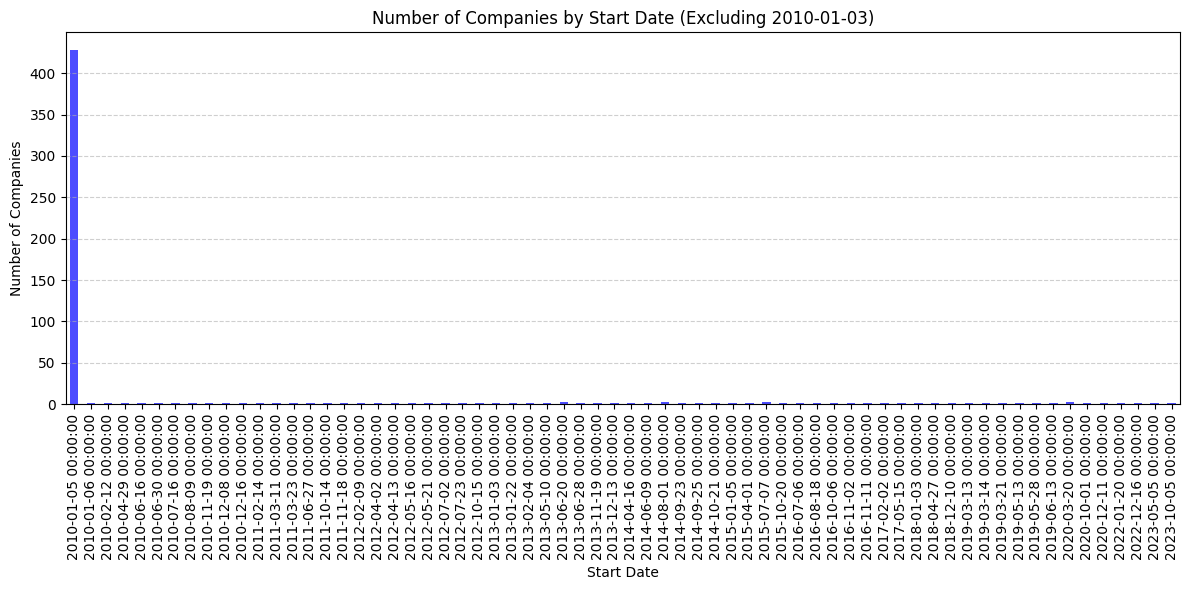

In [ ]:
import matplotlib.pyplot as plt

first_dates = df.groupby('Ticker')['Date'].min().reset_index()
first_dates.columns = ['Ticker', 'Start Date']

non_default_start_dates = first_dates[first_dates['Start Date'] != '2010-01-03']

start_date_counts = non_default_start_dates.groupby('Start Date')['Ticker'].count()

start_date_counts = start_date_counts.sort_index()

plt.figure(figsize=(12, 6))
start_date_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Number of Companies by Start Date (Excluding 2010-01-03)')
plt.xlabel('Start Date')
plt.ylabel('Number of Companies')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


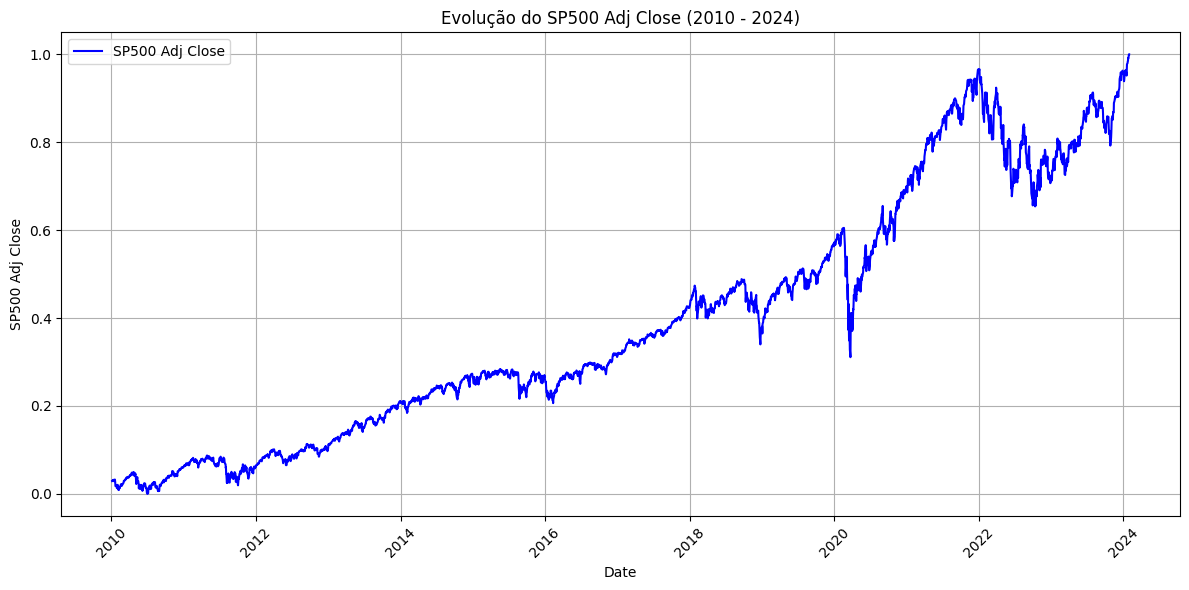

In [ ]:
df = pd.read_csv("combined_financial_normalized.csv")

df['Date'] = pd.to_datetime(df['Date'])

df_filtered = df[df['Ticker'] == 'AAPL']

plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['SP500_Adj_Close'], label="SP500 Adj Close", color='blue')
plt.title("Evolução do SP500 Adj Close (2010 - 2024)")
plt.xlabel("Date")
plt.ylabel("SP500 Adj Close")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Modelos de Machine Learning

In [3]:
df_indices = pd.read_csv('flat-ui__data-Mon Dec 09 2024.csv')

In [2]:
df = pd.read_csv("combined_financial_normalized.csv")


In [ ]:
inf_check = df_ticker.replace([np.inf, -np.inf], np.nan).isnull().any()

columns_with_inf = inf_check[inf_check == True].index

if len(columns_with_inf) > 0:
    print("As seguintes colunas contêm valores infinitos:")
    print(columns_with_inf)
else:
    print("Não foram encontrados valores infinitos no dataset.")

#### Random Forest

O método de cross-validation sliding window é utilizado para treinar e avaliar um modelo de regressão, neste caso, um Random Forest Regressor, com o objetivo de prever valores do Adjusted Close (Adj Close). O processo funciona da seguinte forma:

    Divisão dos Dados em Janelas Temporais:

Cada iteração (fold) usa 2 anos de dados históricos como conjunto de treino e os 3 meses seguintes como conjunto de validação.

A janela de treino e validação avança 3 meses a cada iteração, criando várias partições temporais que garantem que o modelo é treinado e avaliado em diferentes períodos.

    Treino do Modelo:

Para cada partição, o modelo é treinado utilizando os dados de treino da janela correspondente.

As previsões são geradas para os dados de validação e comparadas com os valores reais, permitindo avaliar o desempenho do modelo.

    Avaliação do Modelo:

Para cada iteração, são calculadas métricas de desempenho no conjunto de validação:

RMSE: Root Mean Squared Error, mede o erro absoluto médio das previsões.

MAE: Mean Absolute Error, mede o desvio médio entre as previsões e os valores reais.

R²: Coeficiente de determinação, mede a qualidade do ajuste.

    Resultados Consolidados:

As previsões de cada fold são armazenadas num DataFrame, permitindo uma análise detalhada.

As métricas de cada fold também são salvas, possibilitando uma visão geral do desempenho do modelo ao longo das janelas temporais.

    Opção de Conjunto de Teste (use_test_set):

O código inclui uma opção use_test_set que permite avaliar o modelo num conjunto de teste específico, como os dados de janeiro de 2024.
Quando esta opção é desativada, o modelo não tem acesso aos dados de teste, o que é útil em situações como a afinação de hiperparâmetros para garantir que os dados de teste permanecem completamente desconhecidos durante o treino e a validação.


Este método respeita a natureza sequencial dos dados temporais, garantindo uma avaliação robusta e reduzindo o risco de fugas de informação entre treino, validação e teste. É particularmente adequado para séries temporais financeiras, onde padrões históricos podem influenciar as previsões futuras.

#### Tunning de hyperparametros

Nesta secção foi feita um tunning de hyperparametros para o conjunto de parametros:

-'n_estimators': [50, 100, 200]

-'max_depth': [5, 10, 15]

-'min_samples_split': [2, 5, 10]

No hyperparameter tunning **não é usado o fold de teste ( Janeiro de 2024)** é apenas utilizada a cross validation descrita acima com folds de treino e validação. Para o hyperarameter tunning foram usados conjuntos de dados referentes a uma empresa de cada setor para garantir variabilidade.



____________________________________________________________________________________________________________________________________________________________

No nosso hyperparameter tunning iremos usar uma empresa por cada "setor" distinto presente no indice SP500, para garantir que o nosso modelo seleciona os melhores hyperparametros em diferentes tipos de empresa

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid


def sliding_window_rf(data, target_col, start_date, end_date, ticker, param_grid):

    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    ticker_start_date = data.index.min()
    ticker_end_date = data.index.max()

    start_date = max(pd.to_datetime(start_date), ticker_start_date)
    end_date = min(pd.to_datetime(end_date), ticker_end_date)

    if end_date < start_date + pd.DateOffset(years=2) + pd.DateOffset(months=3):
        print(f"Skipping ticker {ticker}: Insufficient data for cross-validation.")
        return pd.DataFrame()

    param_combinations = list(ParameterGrid(param_grid)) 
    global_metrics = []  

    for params in param_combinations:
        fold_metrics = [] 

        current_date = start_date

        model = RandomForestRegressor(**params, random_state=42)

        while current_date + pd.DateOffset(years=2) <= end_date:
            train_start = current_date
            train_end = train_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
            val_start = train_end + pd.DateOffset(days=1)
            val_end = val_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

            if val_end > end_date:
                break

            train_data = data.loc[train_start:train_end]
            val_data = data.loc[val_start:val_end]

            if train_data.empty or val_data.empty:
                print(f"Skipping fold: Insufficient training or validation data.")
                current_date += pd.DateOffset(months=3)
                continue

            X_train = train_data.index.factorize()[0].reshape(-1, 1)
            y_train = train_data[target_col].values

            X_val = val_data.index.factorize()[0].reshape(-1, 1)
            y_val = val_data[target_col].values

            
            model.fit(X_train, y_train)
            val_predictions = model.predict(X_val)

            val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
            val_mae = mean_absolute_error(y_val, val_predictions)
            val_r2 = r2_score(y_val, val_predictions)

            fold_metrics.append({
                'Val_RMSE': val_rmse,
                'Val_MAE': val_mae,
                'Val_R2': val_r2
            })

            current_date += pd.DateOffset(months=3)

        fold_metrics_df = pd.DataFrame(fold_metrics)
        if not fold_metrics_df.empty:
            global_metrics.append({
                **params,
                'Global_RMSE': fold_metrics_df['Val_RMSE'].mean(),
                'Global_MAE': fold_metrics_df['Val_MAE'].mean(),
                'Global_R2': fold_metrics_df['Val_R2'].mean()
            })

    global_metrics_df = pd.DataFrame(global_metrics)
    return global_metrics_df




In [ ]:
fields = {
    "Information Technology": "AAPL",        
    "Healthcare": "JNJ",                    
    "Energy": "XOM",                       
    "Financials": "JPM",                   
    "Consumer Discretionary": "AMZN",       
    "Communication Services": "CHTR",      
    "Consumer Staples": "ADM",             
    "Industrials": "ADP",                 
    "Materials": "ALB",                     
    "Real Estate": "AMT",                 
    "Utilities": "AEE"                       
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

for sector, ticker in fields.items():
    print(f"Processing ticker: {ticker} from sector: {sector}")

    df_ticker = df[df['Ticker'] == ticker].copy()

    
    global_metrics_df, _ = sliding_window_rf(  
        df_ticker, target_col="Adj Close", start_date="2010-01-01", end_date="2023-12-31",
        ticker=ticker, param_grid=param_grid
    )

    if not global_metrics_df.empty:
        global_metrics_df.to_csv(f"global_metrics_{ticker}.csv", index=False)

print("Processing complete. Results saved.")





Processing ticker: AAPL from sector: Information Technology
Processing ticker: JNJ from sector: Healthcare
Processing ticker: XOM from sector: Energy
Processing ticker: JPM from sector: Financials
Processing ticker: AMZN from sector: Consumer Discretionary
Processing ticker: CHTR from sector: Communication Services
Processing ticker: ADM from sector: Consumer Staples
Processing ticker: ADP from sector: Industrials
Processing ticker: ALB from sector: Materials
Processing ticker: AMT from sector: Real Estate
Processing ticker: AEE from sector: Utilities
Processing complete. Results saved.


In [ ]:
import pandas as pd
import glob

files = glob.glob("global_metrics_*.csv")  
all_metrics = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

best_params_rmse = all_metrics.loc[all_metrics['Global_RMSE'].idxmin()]

best_params_r2 = all_metrics.loc[all_metrics['Global_R2'].idxmax()]

print("\nBest Hyperparameters based on Global_RMSE:")
print(best_params_rmse)

all_metrics.to_csv("combined_global_metrics.csv", index=False)



Best Hyperparameters based on Global_RMSE:
max_depth            15.000000
min_samples_split     5.000000
n_estimators         50.000000
Global_RMSE           2.539128
Global_MAE            2.181819
Global_R2            -1.959598
Name: 102, dtype: float64


#### Teste do Modelo

No teste dos nossos modelos, é feita a cross validation descrita em cima, no entanto, aqui é usado o fold com os dados de janeiro de 2024 como teste, que serão previstos pelo modelo treinado até  2023

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def final_model_test(data, target_col, start_date, end_date, test_start_date, test_end_date, ticker, best_params):

    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start_date:test_end_date]

    if train_data.empty or test_data.empty:
        print(f"Skipping ticker {ticker}: Insufficient data for training or testing.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    if not train_data.index.intersection(test_data.index).empty:
        raise ValueError(f"Data leakage detected: Test data overlaps with training data for ticker {ticker}.")

    drop_columns = [target_col, "Ticker", "Log_Return", "Close"]

    model = RandomForestRegressor(**best_params, random_state=42)

    X_train_full = train_data.drop(columns=drop_columns).values
    y_train_full = train_data[target_col].values

    model.fit(X_train_full, y_train_full)

    fold_metrics = []
    current_date = start_date

    while current_date + pd.DateOffset(years=2) + pd.DateOffset(months=3) <= end_date:
        train_start = current_date
        train_end = train_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        val_start = train_end + pd.DateOffset(days=1)
        val_end = val_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

        train_fold = train_data.loc[train_start:train_end]
        val_fold = train_data.loc[val_start:val_end]

        if not train_fold.index.intersection(val_fold.index).empty:
            raise ValueError(f"Data leakage detected in cross-validation: Validation data overlaps with training data for ticker {ticker}.")

        if val_fold.empty:
            current_date += pd.DateOffset(months=3)
            continue

        X_val = val_fold.drop(columns=drop_columns).values
        y_val = val_fold[target_col].values

        val_predictions = model.predict(X_val)

        val_rmse = root_mean_squared_error(y_val, val_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        fold_metrics.append({
            'Fold_Start': train_start,
            'Fold_End': val_end,
            'Val_RMSE': val_rmse,
            'Val_MAE': val_mae,
            'Val_R2': val_r2
        })

        current_date += pd.DateOffset(months=3)

    X_test = test_data.drop(columns=drop_columns).values
    y_test = test_data[target_col].values

    test_predictions = model.predict(X_test)

    predictions = pd.DataFrame({
        'Date': test_data.index,
        'Ticker': ticker,
        'Actual': y_test,
        'Predicted': test_predictions
    })

    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    metrics = pd.DataFrame([{
        'Ticker': ticker,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2
    }])

    return predictions, metrics, pd.DataFrame(fold_metrics)



In [ ]:
best_params = {
    'n_estimators': 100,  
    'max_depth': 15,
    'min_samples_split': 5,
    'n_jobs': -1  
}

test_start_date = "2024-01-01"
test_end_date = "2024-01-31"


all_predictions = []
all_metrics = []

tickers = df['Ticker'].unique()  

for ticker in tickers:
    print(f"Processing ticker: {ticker}")

    df_ticker = df[df['Ticker'] == ticker].copy()

    predictions, metrics, fold_metrics = final_model_test(
        df_ticker, target_col="Return", start_date="2010-01-01", end_date="2023-12-31",
        test_start_date=test_start_date, test_end_date=test_end_date, ticker=ticker, best_params=best_params
    )

    if not predictions.empty:
        all_predictions.append(predictions)

    if not metrics.empty:
        all_metrics.append(metrics)

if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    final_predictions.to_csv("final_predictions.csv", index=False)

if all_metrics:
    final_metrics = pd.concat(all_metrics, ignore_index=True)
    final_metrics.to_csv("final_metrics.csv", index=False)

print("Processing complete. Results saved.")


C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\2618505416.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_predictions['Date'] = pd.to_datetime(filtered_predictions['Date'])


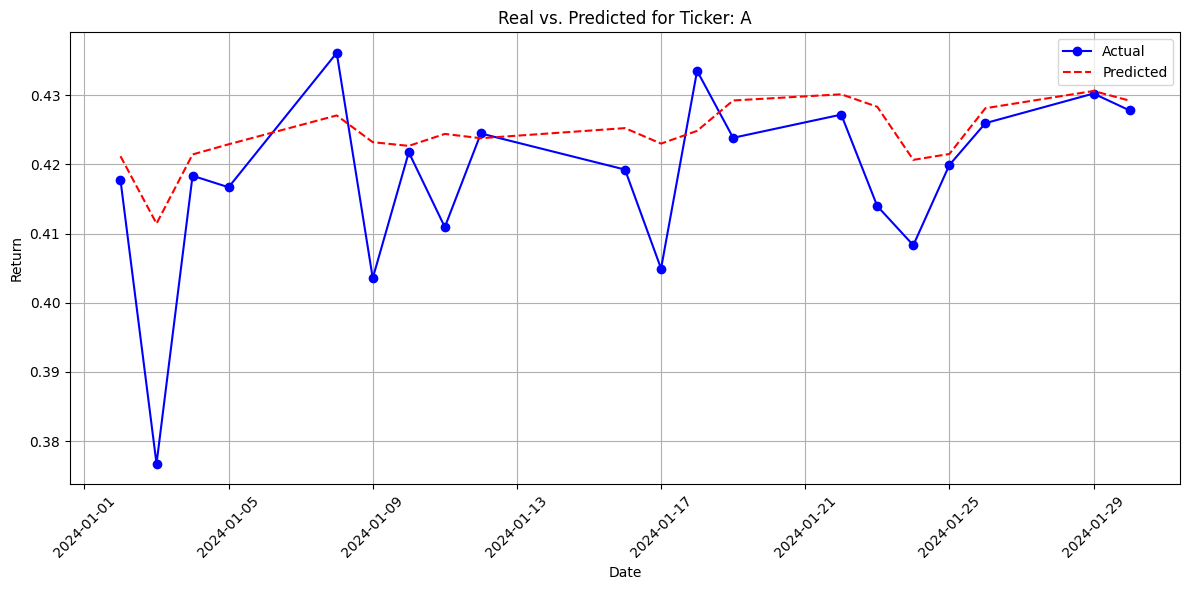

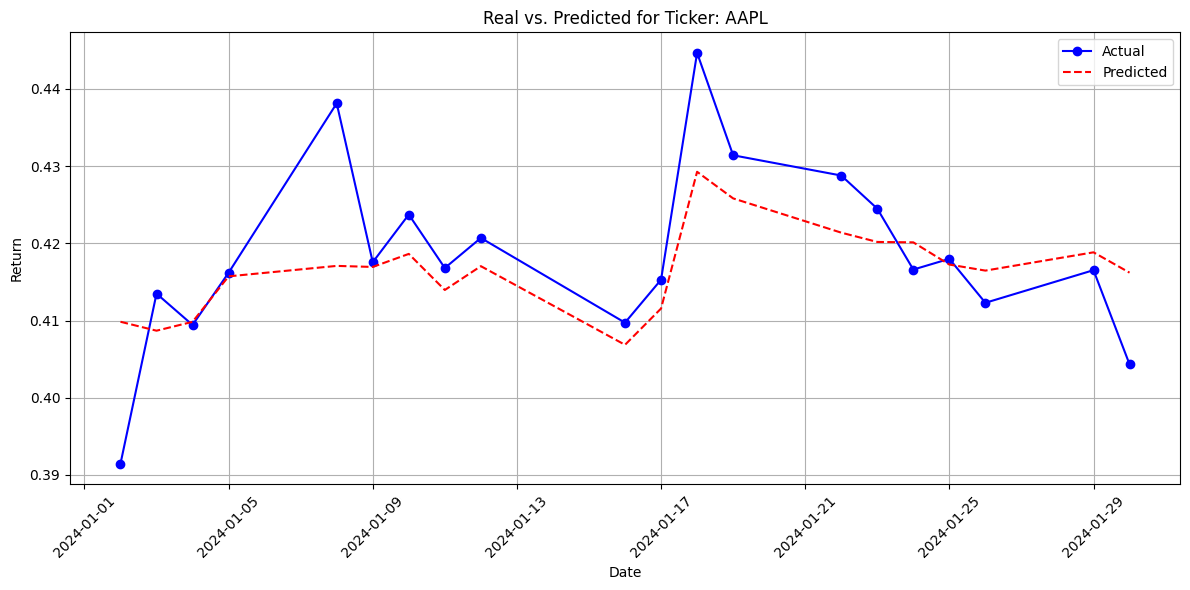

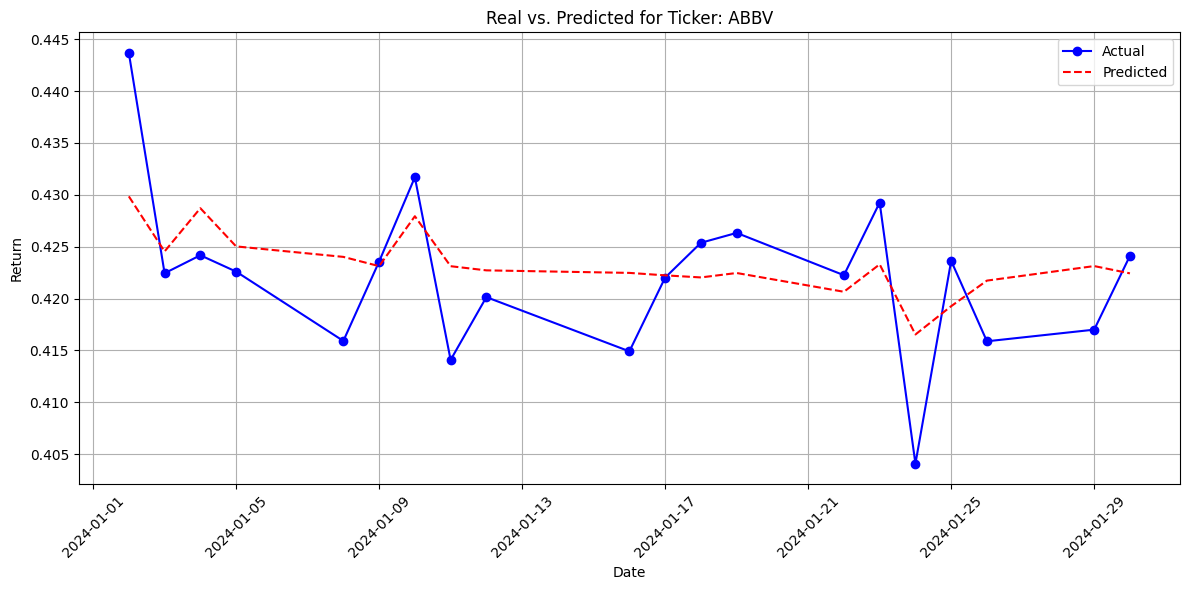

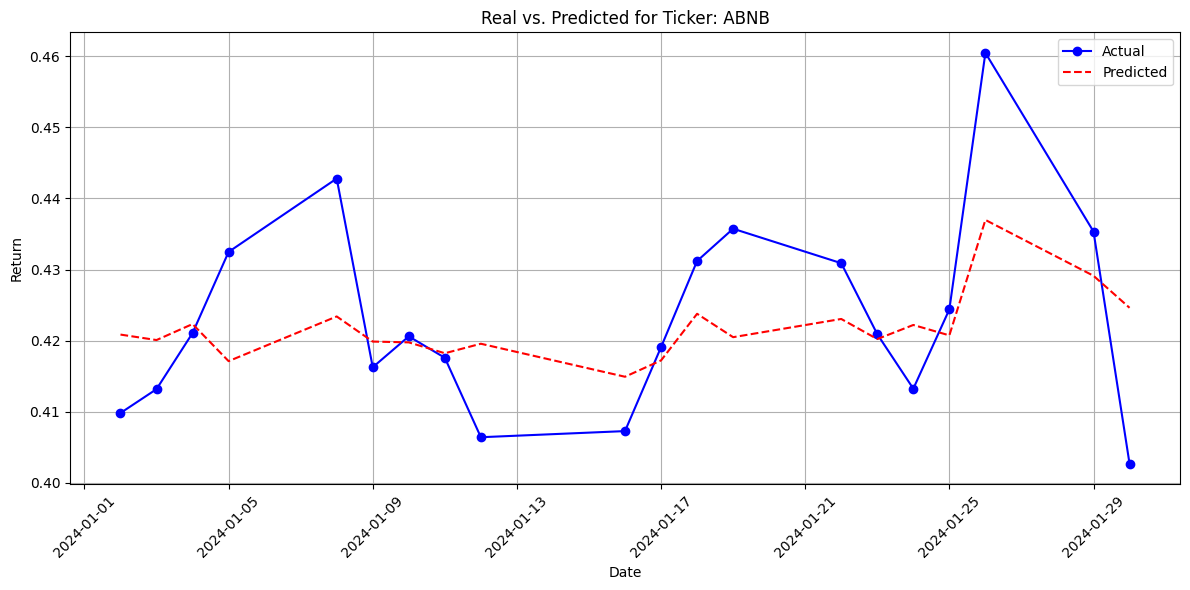

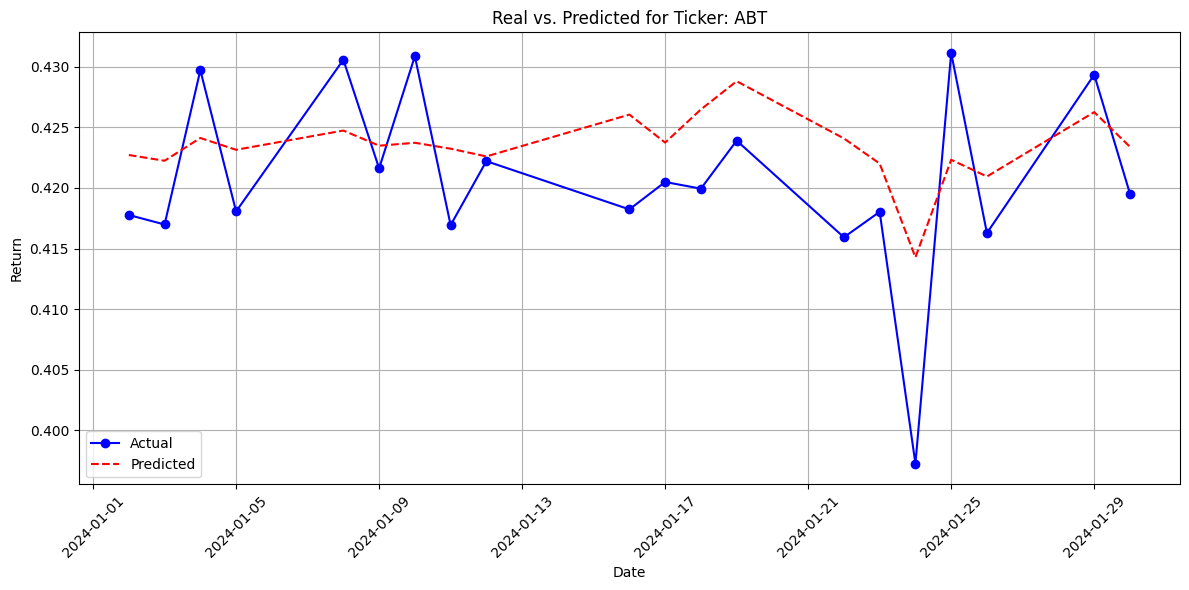

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_predictions(predictions_file, tickers, num_tickers_to_plot=5):
    predictions = pd.read_csv(predictions_file)

    filtered_predictions = predictions[predictions['Ticker'].isin(tickers[:num_tickers_to_plot])]
    filtered_predictions['Date'] = pd.to_datetime(filtered_predictions['Date'])
    filtered_predictions = filtered_predictions.sort_values(by=['Ticker', 'Date'])

    unique_tickers = filtered_predictions['Ticker'].unique()
    for ticker in unique_tickers:
        ticker_data = filtered_predictions[filtered_predictions['Ticker'] == ticker]

        plt.figure(figsize=(12, 6))
        plt.plot(ticker_data['Date'], ticker_data['Actual'], label='Actual', color='blue', marker='o')
        plt.plot(ticker_data['Date'], ticker_data['Predicted'], label='Predicted', color='red', linestyle='--')
        plt.title(f"Real vs. Predicted for Ticker: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

predictions_file = "final_predictions.csv"
x = 5

tickers_df = pd.read_csv(predictions_file)
tickers = tickers_df['Ticker'].unique()

visualize_predictions(predictions_file, tickers, num_tickers_to_plot=x)


C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\1758355732.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x="Sector", y="Test_RMSE", palette="viridis")


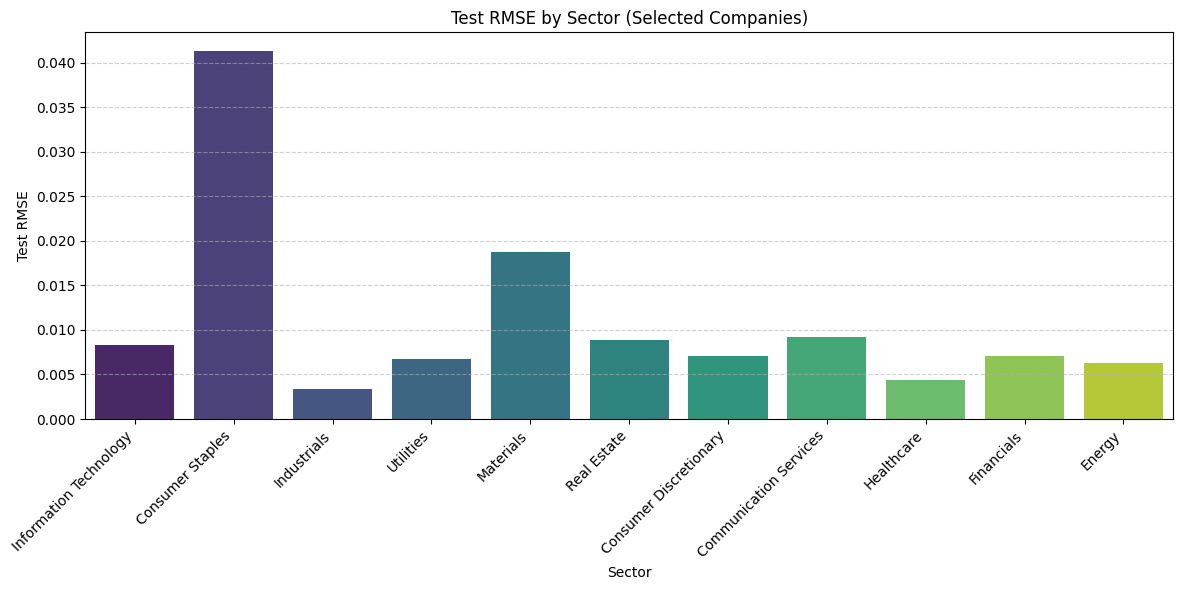

In [ ]:
final_metrics = pd.read_csv("final_metrics.csv")

selected_companies = [
    {"Ticker": "AAPL", "Sector": "Information Technology"},
    {"Ticker": "JNJ", "Sector": "Healthcare"},
    {"Ticker": "XOM", "Sector": "Energy"},
    {"Ticker": "JPM", "Sector": "Financials"},
    {"Ticker": "AMZN", "Sector": "Consumer Discretionary"},
    {"Ticker": "CHTR", "Sector": "Communication Services"},
    {"Ticker": "ADM", "Sector": "Consumer Staples"},
    {"Ticker": "ADP", "Sector": "Industrials"},
    {"Ticker": "ALB", "Sector": "Materials"},
    {"Ticker": "AMT", "Sector": "Real Estate"},
    {"Ticker": "AEE", "Sector": "Utilities"}
]

selected_companies_df = pd.DataFrame(selected_companies)

merged_data = pd.merge(final_metrics, selected_companies_df, on="Ticker")

plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data, x="Sector", y="Test_RMSE", palette="viridis")
plt.title("Test RMSE by Sector (Selected Companies)")
plt.ylabel("Test RMSE")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\4200243852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x="Sector", y="Test_R2", palette="coolwarm")


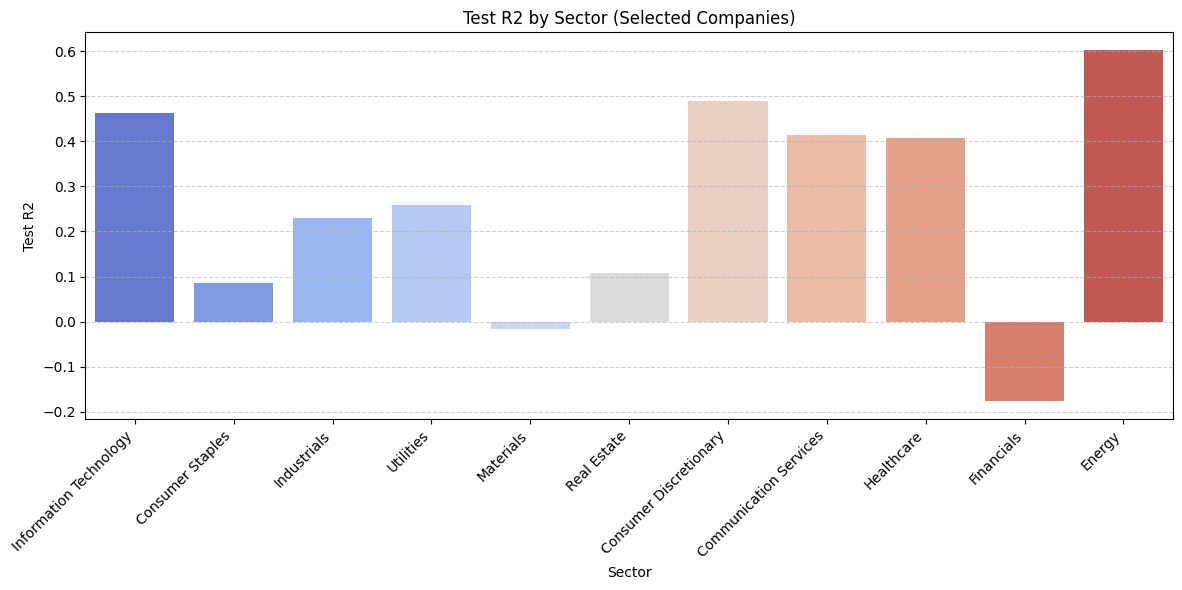

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data, x="Sector", y="Test_R2", palette="coolwarm")
plt.title("Test R2 by Sector (Selected Companies)")
plt.ylabel("Test R2")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

    Interpretação Geral:

Valores altos de R² (próximos de 1): Indicam que o modelo explica bem a variação nos preços das ações para os sectores correspondentes.

Os sectores de Energia e Consumer Discretionary apresentam um desempenho elevado, sugerindo que os dados desses sectores possuem padrões mais claros e previsíveis.

Valores baixos ou negativos de R²:

Valores negativos, como observado no sector Financeiro, indicam que o modelo é pior do que simplesmente usar a média dos dados como previsão.

Sectores como Consumer Staples e Materiais também apresentam R² próximos de 0 ou negativos, o que indica dificuldade do modelo em capturar as tendências.

C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\4292693728.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x="Sector", y="Test_MAE", palette="muted")


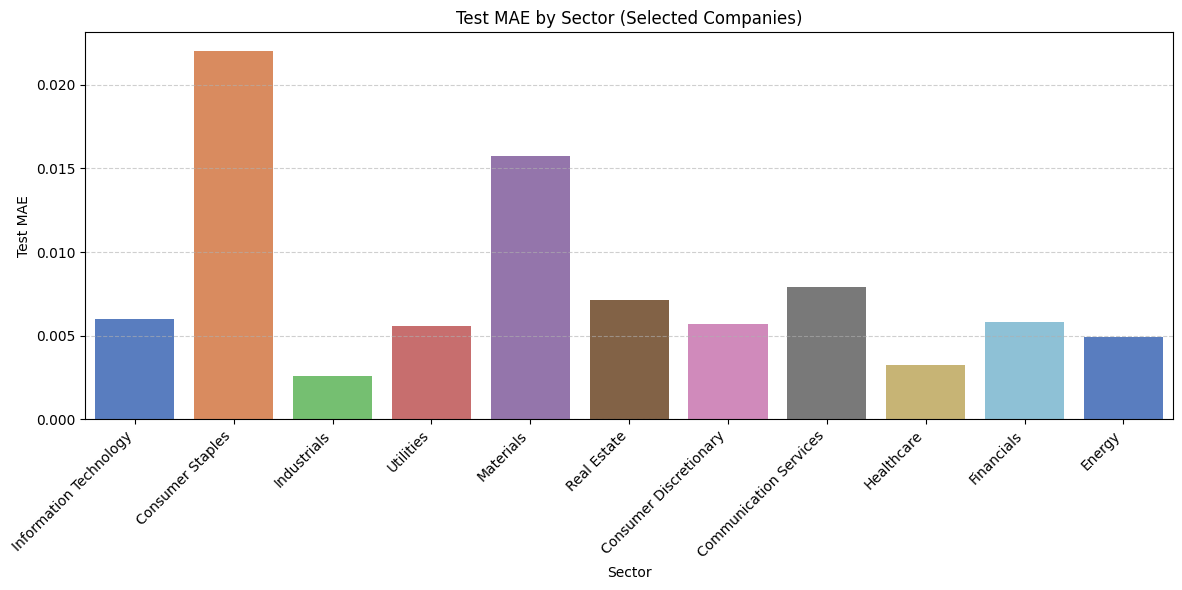

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data, x="Sector", y="Test_MAE", palette="muted")
plt.title("Test MAE by Sector (Selected Companies)")
plt.ylabel("Test MAE")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


    Interpretação Geral:

Consumer Staples e Materials apresentam os maiores valores de MAE:

Esses sectores têm uma maior diferença média entre os valores reais e previstos.

Industrials e Healthcare possuem os menores valores de MAE:

A baixa diferença média indica que o modelo conseguiu prever os preços desses sectores com maior precisão relativa.

Sectores intermediários, como Energy, Financials, e Utilities, apresentam valores moderados de MAE, sugerindo que o modelo foi razoavelmente eficaz.

# Interpretação geral das metricas

    Interpretação Geral

    -Sectores como Materials e Consumer Staples apresentam consistentemente os piores resultados em todas as métricas.

Estes setores podem exigir uma revisão do modelo, talvez incluindo variáveis adicionais que capturem as dinâmicas específicas do setor (como sazonalidade, fatores macroeconômicos ou eventos externos).

    -Sectores como Information Technology, Industrials e Healthcare destacam-se como os mais previsíveis.

O modelo parece funcionar bem para esses setores, provavelmente devido a padrões mais consistentes nos dados históricos.

    -Energy e Consumer Discretionary mostram bons resultados em R², mas ainda apresentam desafios em RMSE e MAE.

Apesar de explicar boa parte da variância, o modelo ainda tem erros consideráveis nessas previsões, indicando que há espaço para melhoria.

#  NASDAQ-100

 Como observado em cima, as diferentes métricas tem comportamento variados para os diversos setores. Para validar a robustez de modelos e explorar o desempenho em contextos específicos decidimos focar-nos apenas no setor da tecnologia e para isso, utilizar o  Nasdaq-100. Aqui estão os principais motivos para escolher o Nasdaq-100:
  
    1. Análise Específica por Setor

Composição Dominada pela Tecnologia:

O Nasdaq-100 é constituído, maioritariamente, por empresas tecnológicas e de crescimento, como Apple, Microsoft e Tesla.
Este foco permite testar o modelo em setores com maior volatilidade e tendências rápidas, desafiando a capacidade de previsão em contextos específicos.

Viés Setorial:

Utilizar o Nasdaq-100 ajuda a identificar se o modelo introduz ou mitiga viéses setoriais, como subprevisões em períodos de rápido crescimento tecnológico ou sobreprevisões durante quedas do mercado.


    2. Teste de Robustez

Diferenças na Volatilidade:

As empresas do Nasdaq-100 apresentam maiores flutuações de preços em comparação com as do S&P 500.
Este cenário obriga o modelo a prever em ambientes mais ruidosos e erráticos, testando a sua capacidade de adaptação.

Generalização:

Avaliar o modelo no Nasdaq-100 permite medir como ele generaliza em diferentes condições de mercado, garantindo que não está excessivamente ajustado aos dados do S&P 500.


In [ ]:
nasdaq_100_tickers = [
    "AAPL", "MSFT", "AMZN", "GOOG", "GOOGL", "NVDA", "TSLA", "META", "AVGO", "ADBE",
    "CSCO", "AMD", "NFLX", "INTC", "PEP", "COST", "TMUS", "QCOM", "TXN", "AMAT",
    "HON", "INTU", "SBUX", "AMGN", "ADI", "MDLZ", "PYPL", "BKNG", "MRVL", "ISRG",
    "LRCX", "GILD", "ORLY", "FISV", "PANW", "VRTX", "KDP", "MNST", "ADSK", "NXPI",
    "KLAC", "REGN", "CDNS", "PDD", "CSX", "CTAS", "EXC", "AEP", "FAST", "IDXX",
    "SNPS", "ROST", "WBD", "CHTR", "XEL", "BIIB", "TEAM", "FTNT", "MAR", "MELI",
    "ODFL", "PAYX", "DXCM", "PCAR", "VRSK", "ANSS", "CEG", "LULU", "ZS", "WDAY",
    "EA", "CPRT", "CRWD", "ON", "TTD", "DDOG", "DOCU", "OKTA", "SPLK", "GFS",
    "ASML", "MRNA", "GEHC", "ARM", "BKR", "LRCX", "META"
]

data = yf.download(nasdaq_100_tickers, start="2010-01-01", end="2024-01-31", group_by="ticker")

data_long = data.stack(level=0).reset_index()
data_long.columns = ["Date", "Ticker", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

data_long.to_csv("nasdaq_100_data.csv", index=False)

print("Nasdaq-100 data downloaded and saved!")




[*********************100%***********************]  85 of 85 completed

1 Failed download:
['SPLK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\1655459221.py:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_long = data.stack(level=0).reset_index()


Nasdaq-100 data downloaded and saved!


Aos dados das empresas relativas ao indice NASDAQ100 também foram adicionados os dados financeiros e os calculos temporais usados no dataset do SP500

In [ ]:
df_nasdaq = pd.read_csv("nasdaq_100_data.csv")

df_nasdaq['Date'] = pd.to_datetime(df_nasdaq['Date'])

tickers = ["^GSPC", "^DJI", "^VIX", "CL=F", "HG=F", "GC=F"]
indices = yf.download(tickers, start=df_nasdaq['Date'].min(), end=df_nasdaq['Date'].max(), interval="1d")

adj_close = indices['Adj Close'].reset_index()
volume = indices['Volume'].reset_index()

adj_close = adj_close.rename(columns={
    "^GSPC": "SP500_Adj_Close",
    "^DJI": "DJI_Adj_Close",
    "^VIX": "VIX_Adj_Close",
    "CL=F": "CrudeOil_Adj_Close",
    "HG=F": "Copper_Adj_Close",
    "GC=F": "Gold_Adj_Close"
})

volume = volume.rename(columns={
    "^GSPC": "SP500_Volume",
    "^DJI": "DJI_Volume",
    "^VIX": "VIX_Volume",
    "CL=F": "CrudeOil_Volume",
    "HG=F": "Copper_Volume",
    "GC=F": "Gold_Volume"
})

df_nasdaq = pd.merge(df_nasdaq, adj_close, on='Date', how='left')
df_nasdaq = pd.merge(df_nasdaq, volume, on='Date', how='left')

df_nasdaq = df_nasdaq.drop(columns=["VIX_Volume", "SP500_Volume"])
df_nasdaq = df_nasdaq.fillna(method='ffill').fillna(method='bfill')

df_nasdaq['Return'] = df_nasdaq.groupby('Ticker')['Adj Close'].pct_change()
df_nasdaq = df_nasdaq.dropna(subset=['Return'])

result = []

tickers = df_nasdaq['Ticker'].unique()

for ticker in tickers:
    df_ticker = df_nasdaq[df_nasdaq['Ticker'] == ticker].copy()

    df_ticker['SMA_10'] = ta.sma(df_ticker['Close'], length=10)
    df_ticker['WMA_10'] = ta.wma(df_ticker['Close'], length=10)
    df_ticker['RSI_14'] = ta.rsi(df_ticker['Close'], length=14)
    df_ticker['Momentum_10'] = ta.mom(df_ticker['Close'], length=10)
    df_ticker['Stochastic_%K_14'] = ta.stoch(
        df_ticker['High'], df_ticker['Low'], df_ticker['Close'], k=14
    )["STOCHk_14_3_3"]

    df_ticker['Volume_SMA_10'] = ta.sma(df_ticker['Volume'], length=10)

    result.append(df_ticker)

nasdaq_with_indicators = pd.concat(result)

nasdaq_with_indicators.to_csv("nasdaq_100_with_indicators_and_indices.csv", index=False)

print("Nasdaq-100 data with technical indicators and indices saved successfully!")



[*********************100%***********************]  6 of 6 completed
C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\510802980.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_nasdaq = df_nasdaq.fillna(method='ffill').fillna(method='bfill')


Nasdaq-100 data with technical indicators and indices saved successfully!


Pré-processamento 

O pré-processamento usado no NASDAQ-100 foi exatamento o mesmo  usado no SP500

In [ ]:
data = pd.read_csv("nasdaq_100_with_indicators_and_indices.csv", parse_dates=["Date"])

data = data.sort_values(by=["Ticker", "Date"])

data['Log_Return'] = (
    data.groupby('Ticker')['Adj Close']
    .apply(lambda x: np.log(x / x.shift(1)))
    .reset_index(level=0, drop=True)  
)

print("Missing Values (per column):")
print(data.isnull().sum())

data = data.fillna(0).apply(lambda x: x.ffill())

print("\nMissing Values After Preprocessing:")
print(data.isnull().sum())

data.to_csv("nasdaq_with_log_returns_cleaned.csv", index=False)

print("Dataset with Log Returns saved successfully.")

columns_to_exclude = ['Log_Return']
columns_to_normalize = [col for col in data.columns if col not in columns_to_exclude + ['Date', 'Ticker']]

normality_results = {}
for col in columns_to_normalize:
    try:
        is_normal = shapiro(data[col].dropna())[1] > 0.05  
        normality_results[col] = is_normal
    except Exception as e:
        print(f"Error checking normality for column {col}: {e}")
        normality_results[col] = None

normal_columns = [col for col, is_normal in normality_results.items() if is_normal]
non_normal_columns = [col for col, is_normal in normality_results.items() if is_normal == False]

if non_normal_columns:
    scaler = MinMaxScaler()
    data[non_normal_columns] = scaler.fit_transform(data[non_normal_columns])

if normal_columns:
    data[normal_columns] = zscore(data[normal_columns])

data.to_csv("nasdaq_with_log_returns_normalized.csv", index=False)

print("Dataset with Log Returns, cleaned, and normalized saved successfully.")


Missing Values (per column):
Date                     0
Ticker                   0
Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
CrudeOil_Adj_Close       0
Gold_Adj_Close           0
Copper_Adj_Close         0
DJI_Adj_Close            0
SP500_Adj_Close          0
VIX_Adj_Close            0
CrudeOil_Volume          0
Gold_Volume              0
Copper_Volume            0
DJI_Volume               0
Return                   0
SMA_10                 756
WMA_10                 756
RSI_14                1176
Momentum_10            840
Stochastic_%K_14      1260
Volume_SMA_10          756
Log_Return              84
dtype: int64

Missing Values After Preprocessing:
Date                  0
Ticker                0
Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
CrudeOil_Adj_Close    0
Gol

c:\Users\gjoli\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 259365.
  res = hypotest_fun_out(*samples, **kwds)


Dataset with Log Returns, cleaned, and normalized saved successfully.


In [20]:
df_nasdaq = pd.read_csv("nasdaq_with_log_returns_normalized.csv")

df_nasdaq


Date Ticker      Open      High       Low     Close  Adj Close  \
0       2010-01-05   AAPL  0.002038  0.002037  0.002084  0.002056   0.001745   
1       2010-01-06   AAPL  0.002036  0.002033  0.002059  0.002022   0.001716   
2       2010-01-07   AAPL  0.002011  0.002002  0.002041  0.002018   0.001713   
3       2010-01-08   AAPL  0.001996  0.002002  0.002042  0.002032   0.001725   
4       2010-01-11   AAPL  0.002021  0.002011  0.002035  0.002014   0.001709   
...            ...    ...       ...       ...       ...       ...        ...   
259360  2024-01-24     ZS  0.067011  0.067082  0.067709  0.066687   0.067283   
259361  2024-01-25     ZS  0.066929  0.066706  0.066630  0.065835   0.066423   
259362  2024-01-26     ZS  0.064788  0.065300  0.065912  0.065428   0.066013   
259363  2024-01-29     ZS  0.065284  0.066736  0.066963  0.067701   0.068307   
259364  2024-01-30     ZS  0.066576  0.066930  0.067774  0.066615   0.067210   

          Volume  CrudeOil_Adj_Close  Gold_Adj_Close  ...  Copper_Volume  \
0       0.162989            0.740098        0.065270  ...       0.003048   
1       0.149518            0.748838        0.082533  ...       0.001373   
2       0.129201            0.745615        0.079818  ...       0.004105   
3       0.121208            0.746172        0.084764  ...       0.003916   
4       0.125166            0.744747        0.096887  ...       0.001826   
...          ...                 ...             ...  ...            ...   
259360  0.000421            0.698692        0.934051  ...       0.006586   
259361  0.000400            0.712763        0.936961  ...       0.005201   
259362  0.000326            0.716792        0.936864  ...       0.007959   
259363  0.000373            0.709168        0.945010  ...       0.008891   
259364  0.000552            0.709168        0.945010  ...       0.008891   

        DJI_Volume    Return    SMA_10    WMA_10    RSI_14  Momentum_10  \
0         0.198473  0.407156  0.000000  0.000000  0.000000     0.612579   
1         0.195718  0.390220  0.000000  0.000000  0.000000     0.612579   
2         0.230261  0.403720  0.000000  0.000000  0.000000     0.612579   
3         0.181031  0.411880  0.000000  0.000000  0.000000     0.612579   
4         0.191322  0.397024  0.000000  0.000000  0.000000     0.612579   
...            ...       ...       ...       ...       ...          ...   
259360    0.361048  0.400706  0.065972  0.066592  0.755563     0.624167   
259361    0.434739  0.393242  0.066338  0.066884  0.705595     0.622466   
259362    0.417142  0.399571  0.066574  0.067035  0.682399     0.618948   
259363    0.335034  0.438827  0.066979  0.067565  0.745062     0.623524   
259364    0.335034  0.390094  0.067232  0.067820  0.686639     0.619431   

        Stochastic_%K_14  Volume_SMA_10  Log_Return  
0               0.000000       0.000000    0.000000  
1               0.000000       0.000000   -0.016034  
2               0.000000       0.000000   -0.001850  
3               0.000000       0.000000    0.006626  
4               0.000000       0.000000   -0.008860  
...                  ...            ...         ...  
259360          0.925746       0.000802   -0.005000  
259361          0.862328       0.000784   -0.012842  
259362          0.789259       0.000776   -0.006188  
259363          0.819284       0.000768    0.034120  
259364          0.820968       0.000791   -0.016168  

[259365 rows x 26 columns]

## Testes do modelo nos dados relativos ao NASDAQ100

In [ ]:
best_params = {
    'n_estimators': 100,  
    'max_depth': 15,
    'min_samples_split': 5,
    'n_jobs': -1 
}

test_start_date = "2024-01-01"
test_end_date = "2024-01-31"

all_predictions = []
all_metrics = []

tickers = df_nasdaq['Ticker'].unique() 

for ticker in tickers:
    print(f"Processing ticker: {ticker}")

    df_ticker = df_nasdaq[df_nasdaq['Ticker'] == ticker].copy()

    predictions, metrics, fold_metrics = final_model_test(
        df_ticker, target_col="Return", start_date="2010-01-01", end_date="2023-12-31",
        test_start_date=test_start_date, test_end_date=test_end_date, ticker=ticker, best_params=best_params
    )

    if not predictions.empty:
        all_predictions.append(predictions)

    if not metrics.empty:
        all_metrics.append(metrics)

if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    final_predictions.to_csv("final_predictions_nasdaq.csv", index=False)

if all_metrics:
    final_metrics = pd.concat(all_metrics, ignore_index=True)
    final_metrics.to_csv("final_metrics_nasdaq.csv", index=False)

print("Processing complete. Results saved.")


C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\346083831.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_predictions_sp500['Date'] = pd.to_datetime(filtered_predictions_sp500['Date'])
C:\Users\gjoli\AppData\Local\Temp\ipykernel_27896\346083831.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_predictions_nasdaq['Date'] = pd.to_datetime(filtered_predictions_nasdaq['Date'])


Combined Predictions Visualization:


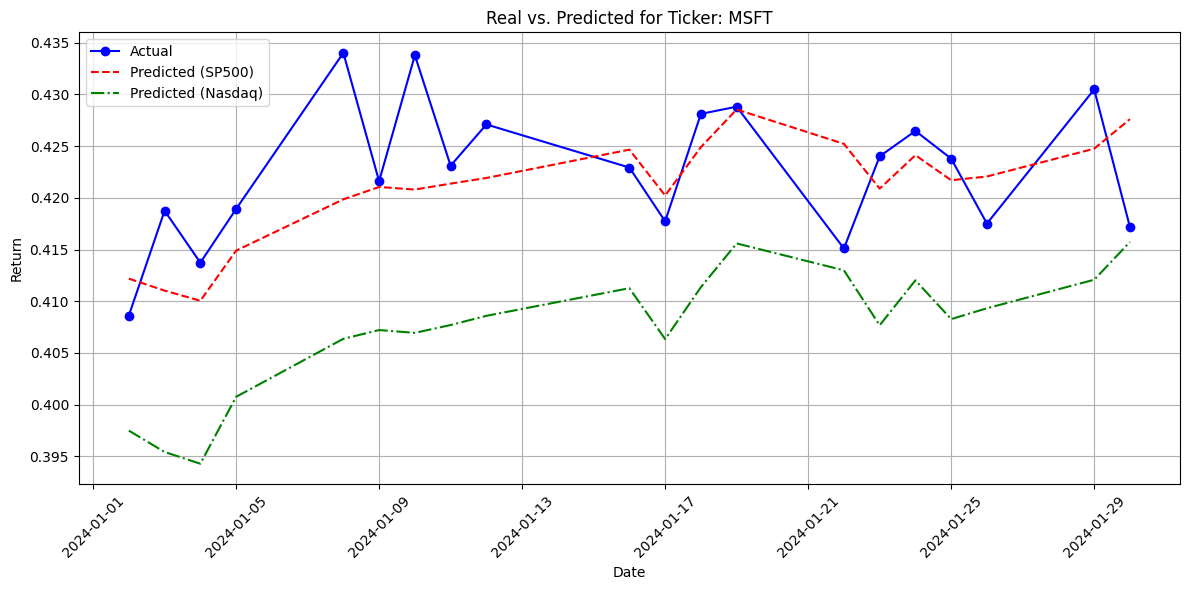

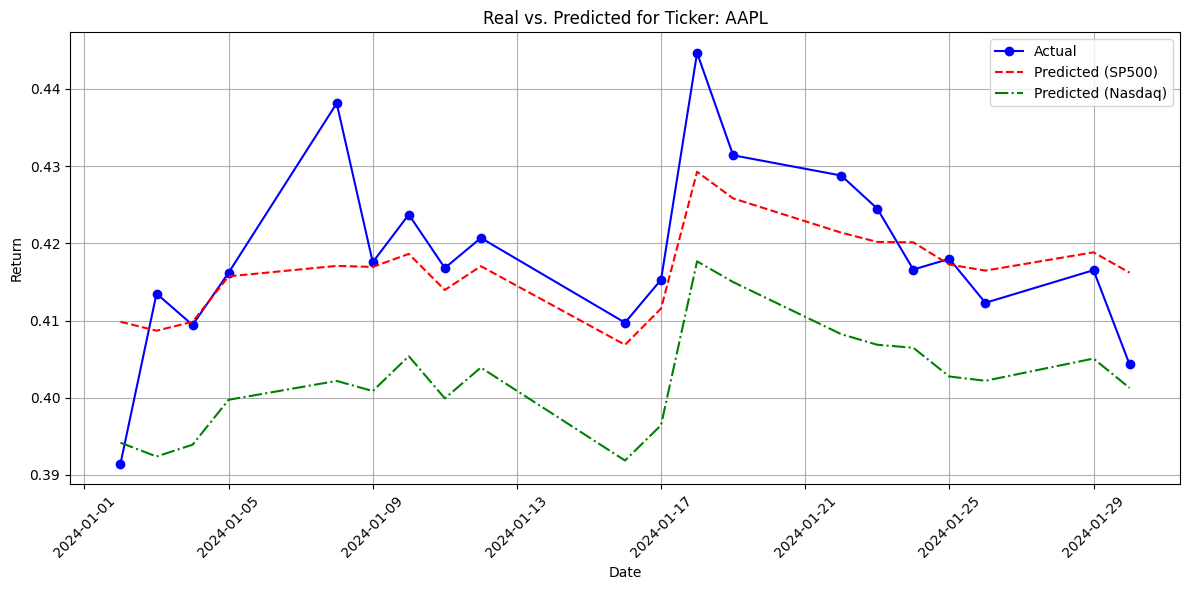

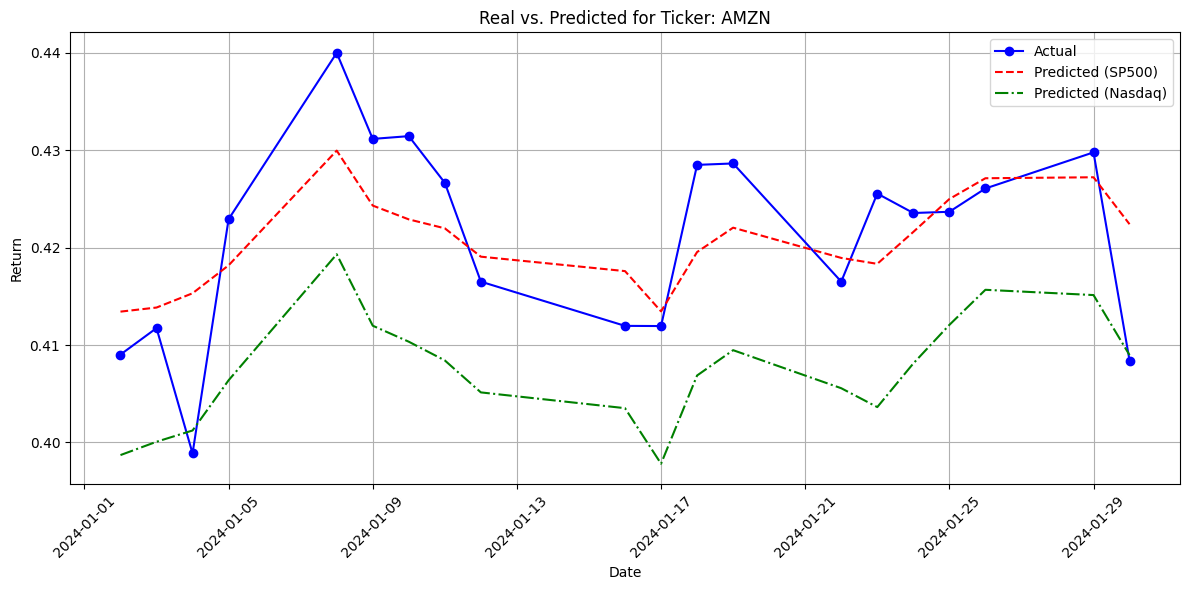

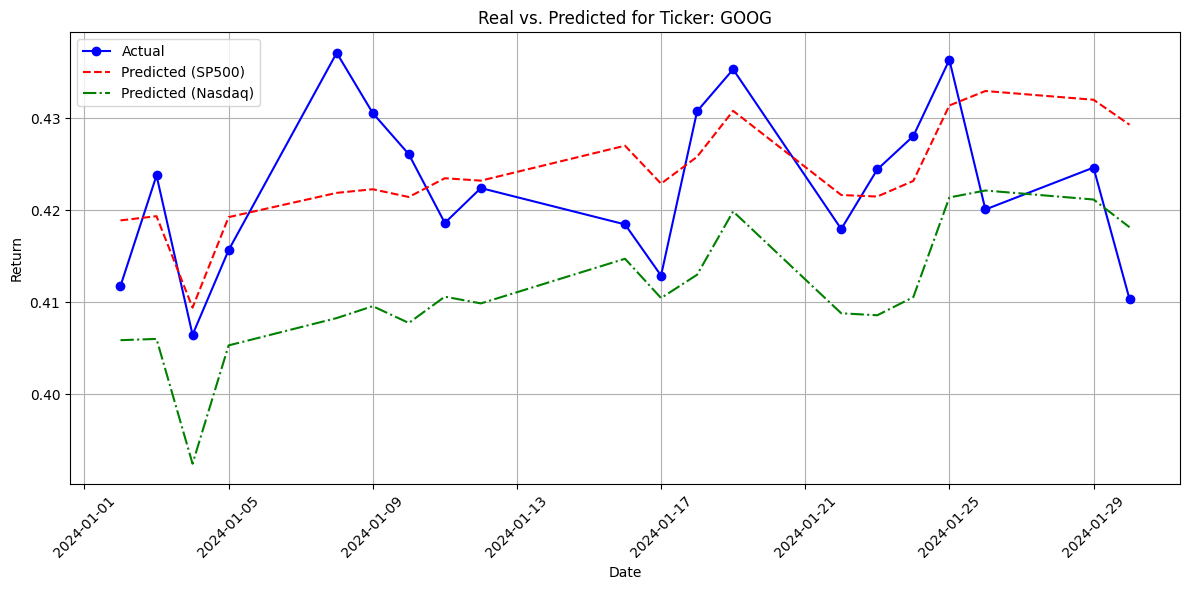

In [ ]:
def visualize_combined_predictions(predictions_file_sp500, predictions_file_nasdaq, tickers, num_tickers_to_plot=5):
    predictions_sp500 = pd.read_csv(predictions_file_sp500)
    predictions_nasdaq = pd.read_csv(predictions_file_nasdaq)

    filtered_predictions_sp500 = predictions_sp500[predictions_sp500['Ticker'].isin(tickers[:num_tickers_to_plot])]
    filtered_predictions_nasdaq = predictions_nasdaq[predictions_nasdaq['Ticker'].isin(tickers[:num_tickers_to_plot])]

    filtered_predictions_sp500['Date'] = pd.to_datetime(filtered_predictions_sp500['Date'])
    filtered_predictions_nasdaq['Date'] = pd.to_datetime(filtered_predictions_nasdaq['Date'])
    filtered_predictions_sp500 = filtered_predictions_sp500.sort_values(by=['Ticker', 'Date'])
    filtered_predictions_nasdaq = filtered_predictions_nasdaq.sort_values(by=['Ticker', 'Date'])

    unique_tickers = set(filtered_predictions_sp500['Ticker']).intersection(filtered_predictions_nasdaq['Ticker'])
    print("Combined Predictions Visualization:")
    for ticker in unique_tickers:
        sp500_data = filtered_predictions_sp500[filtered_predictions_sp500['Ticker'] == ticker]
        nasdaq_data = filtered_predictions_nasdaq[filtered_predictions_nasdaq['Ticker'] == ticker]

        merged_data = sp500_data.merge(nasdaq_data, on=['Date', 'Ticker'], suffixes=('_sp500', '_nasdaq'))

        plt.figure(figsize=(12, 6))
        plt.plot(merged_data['Date'], merged_data['Actual_sp500'], label='Actual', color='blue', marker='o')
        plt.plot(merged_data['Date'], merged_data['Predicted_sp500'], label='Predicted (SP500)', color='red', linestyle='--')
        plt.plot(merged_data['Date'], merged_data['Predicted_nasdaq'], label='Predicted (Nasdaq)', color='green', linestyle='-.')
        plt.title(f"Real vs. Predicted for Ticker: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'JNJ']
visualize_combined_predictions(
    predictions_file_sp500='final_predictions.csv',
    predictions_file_nasdaq='final_predictions_nasdaq.csv',
    tickers=tickers,
    num_tickers_to_plot=5
)

## Implementação de SVM

A escolha de utilizar Support Vector Machines para a previsão do index S&P500 foi motivada pela eficácia já comprovada em problemas de previsão de séries temporais financeiras, conforme demonstrado no estudo Patel et al.(2015). 

O SVM é particularmente adequada para este tipo de problema devido à sua capacidade de encontrar o hiperplano ótimo que maximiza a margem entre diferentes classes de dados, e além disso, quando aplicado com diferentes funções kernel, pode identificar padrões não lineares, o que é fundamental para capturar nuances do comportamento volátil dos mercados fincanceiros.

In [ ]:
import pandas as pd
df = pd.read_csv("combined_financial_normalized.csv")

Para este problema, a escolha adequada dos parâmetros do SVM é crucial para equilibrar a capacidade de generalização e o ajuste aos dados do S&P500. Os parâmetros foram ajustados usando a técnica Grid Search com validação cruzada, para encontrar a melhor combinação possível.
As razões para a escolha dos parâmetros são:
- C (parâmetro de regularização): Controla a margem de erro do modelo. Testamos valores de 0.1 a 100 para ajustar a flexibilidade da fronteira de decisão.

- kernel: Optamos por testar os kernel RBF e polinomial. O RBF é adequado para problemas onde os limites de decisão são complexos e não lineares, enquanto o kernel polinomial pode ser vantajoso wuando os padrões mais específicos precisam ser identificados.

- degree: Este parâmetro aplica-se ao grau do kernel polinomial e define a complexidade do polinômio.

- gamma (coeficiente do kernel RBF): Este parâmetro define a influência de cada ponto no modelo. Utilizamos valores automáticos (scale e auto) e valores fixos (0.1, 0.01, 0.001) para determinar qual forneceria o melhor ajuste.

Baseado no estudo Patel et al. (2015)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

def tune_svm_parameters(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly'],
        'degree': [2, 3, 4], 
        'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_


O método de cross-validation sliding window é utilizado para treinar e avaliar um modelo de regressão, neste caso, um Support Vector Machine, com o objetivo de prever valores do Adjusted Close (Adj Close). O processo funciona da seguinte forma:

    Divisão dos Dados em Janelas Temporais:

Cada iteração (fold) usa 2 anos de dados históricos como conjunto de treino e os 3 meses seguintes como conjunto de validação.

A janela de treino e validação avança 3 meses a cada iteração, criando várias partições temporais que garantem que o modelo é treinado e avaliado em diferentes períodos.

    Treino do Modelo:

Para cada partição, o modelo é treinado utilizando os dados de treino da janela correspondente.

As previsões são geradas para os dados de validação e comparadas com os valores reais, permitindo avaliar o desempenho do modelo.

    Avaliação do Modelo:

Para cada iteração, são calculadas métricas de desempenho no conjunto de validação:

RMSE: Root Mean Squared Error, mede o erro absoluto médio das previsões.

MAE: Mean Absolute Error, mede o desvio médio entre as previsões e os valores reais.

R²: Coeficiente de determinação, mede a qualidade do ajuste.

    Resultados Consolidados:

As previsões de cada fold são armazenadas num DataFrame, permitindo uma análise detalhada.

As métricas de cada fold também são salvas, possibilitando uma visão geral do desempenho do modelo ao longo das janelas temporais.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

def root_mean_squared_error(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

def sliding_window_svm_with_tuning(data, target_col, start_date, end_date, test_start_date, test_end_date, ticker):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start_date:test_end_date]

    if train_data.empty or test_data.empty:
        print(f"Skipping ticker {ticker}: Insufficient data for training or testing.")
        return pd.DataFrame(), pd.DataFrame()

    drop_columns = [target_col, 'Ticker']

    scaler = StandardScaler()

    fold_metrics = []
    current_date = pd.to_datetime(start_date)

    while current_date + pd.DateOffset(years=2) + pd.DateOffset(months=3) <= pd.to_datetime(end_date):
        train_start = current_date
        train_end = train_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        val_start = train_end + pd.DateOffset(days=1)
        val_end = val_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

        train_fold = train_data.loc[train_start:train_end]
        val_fold = train_data.loc[val_start:val_end]

        if train_fold.empty or val_fold.empty:
            print(f"Skipping fold: Insufficient data for training or validation. Ticker: {ticker}, Date: {current_date}")
            current_date += pd.DateOffset(months=3)
            continue

        X_train = train_fold.drop(columns=drop_columns).values
        y_train = train_fold[target_col].values

        X_val = val_fold.drop(columns=drop_columns).values
        y_val = val_fold[target_col].values

        if X_train.shape[0] == 0 or X_val.shape[0] == 0:
            print(f"Skipping fold: No data after filtering. Ticker: {ticker}, Date: {current_date}")
            current_date += pd.DateOffset(months=3)
            continue

        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        best_params = tune_svm_parameters(X_train, y_train)
        print(f"Best parameters for ticker {ticker}: {best_params}")

        model = SVR(**best_params)
        model.fit(X_train, y_train)
        val_predictions = model.predict(X_val)

        val_rmse = root_mean_squared_error(y_val, val_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        fold_metrics.append({
            'Fold_Start': train_start,
            'Fold_End': val_end,
            'Val_RMSE': val_rmse,
            'Val_MAE': val_mae,
            'Val_R2': val_r2
        })

        current_date += pd.DateOffset(months=3)

    X_test = test_data.drop(columns=drop_columns).values
    y_test = test_data[target_col].values

    if X_test.shape[0] == 0:
        print(f"Skipping test: Insufficient test data for ticker {ticker}.")
        return pd.DataFrame(), pd.DataFrame()

    X_test = scaler.transform(X_test)
    test_predictions = model.predict(X_test)

    predictions = pd.DataFrame({
        'Date': test_data.index,
        'Ticker': ticker,
        'Actual': y_test,
        'Predicted': test_predictions
    })

    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    metrics = pd.DataFrame([{
        'Ticker': ticker,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2
    }])

    return predictions, metrics, pd.DataFrame(fold_metrics)

tickers = df['Ticker'].unique()[:10]
test_start_date = "2024-01-01"
test_end_date = "2024-01-31"

all_predictions = []
all_metrics = []

for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy()

    predictions, metrics, _ = sliding_window_svm_with_tuning(
        df_ticker, target_col="Return", start_date="2010-01-01", end_date="2023-12-31",
        test_start_date=test_start_date, test_end_date=test_end_date, ticker=ticker
    )

    if not predictions.empty:
        all_predictions.append(predictions)
    if not metrics.empty:
        all_metrics.append(metrics)

if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    final_predictions.to_csv("svm_tuned_predictions_10_tickers.csv", index=False)

if all_metrics:
    final_metrics = pd.concat(all_metrics, ignore_index=True)
    final_metrics.to_csv("svm_tuned_metrics_10_tickers.csv", index=False)

print("Processing complete. Results saved.")


Agora emitimos os graficos correspondentes às primeiras 5 empresas para visualizar a sua performance.

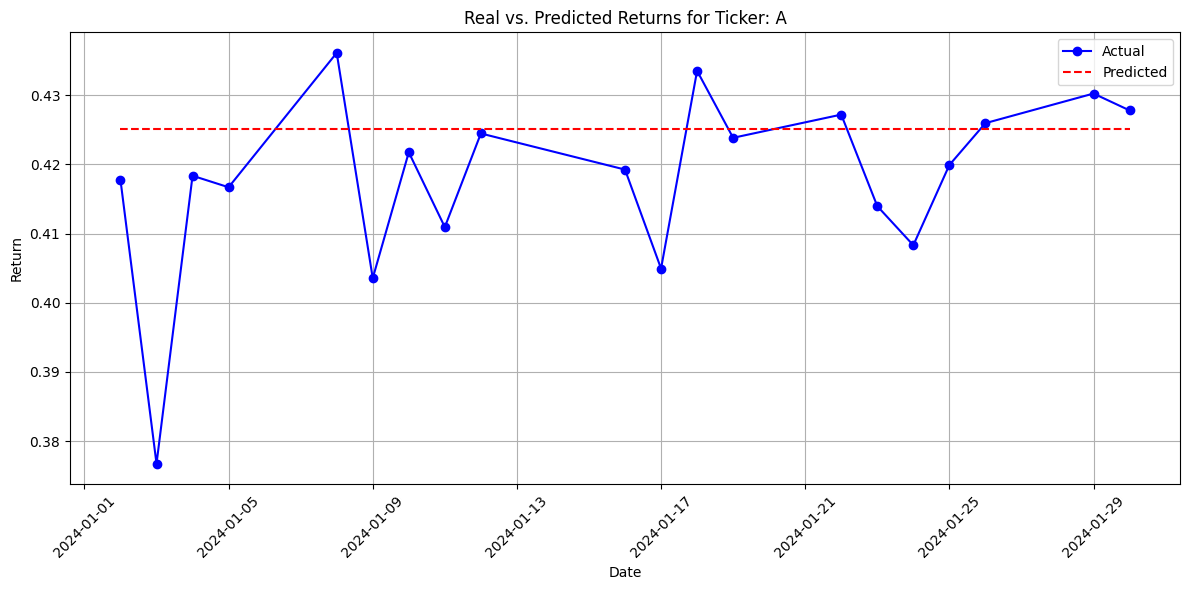

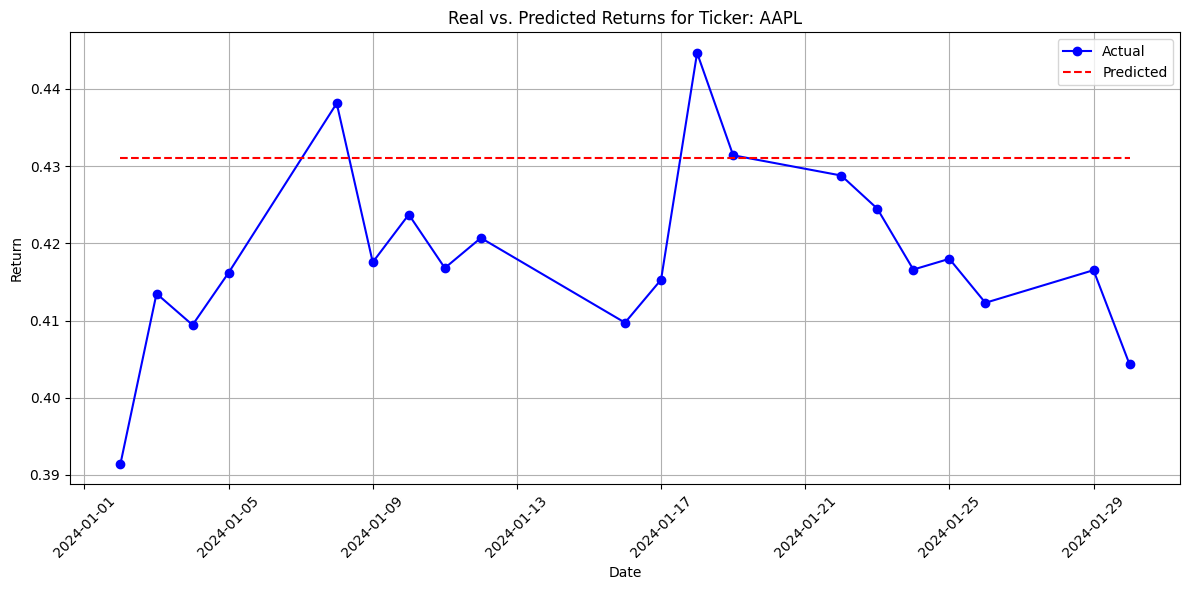

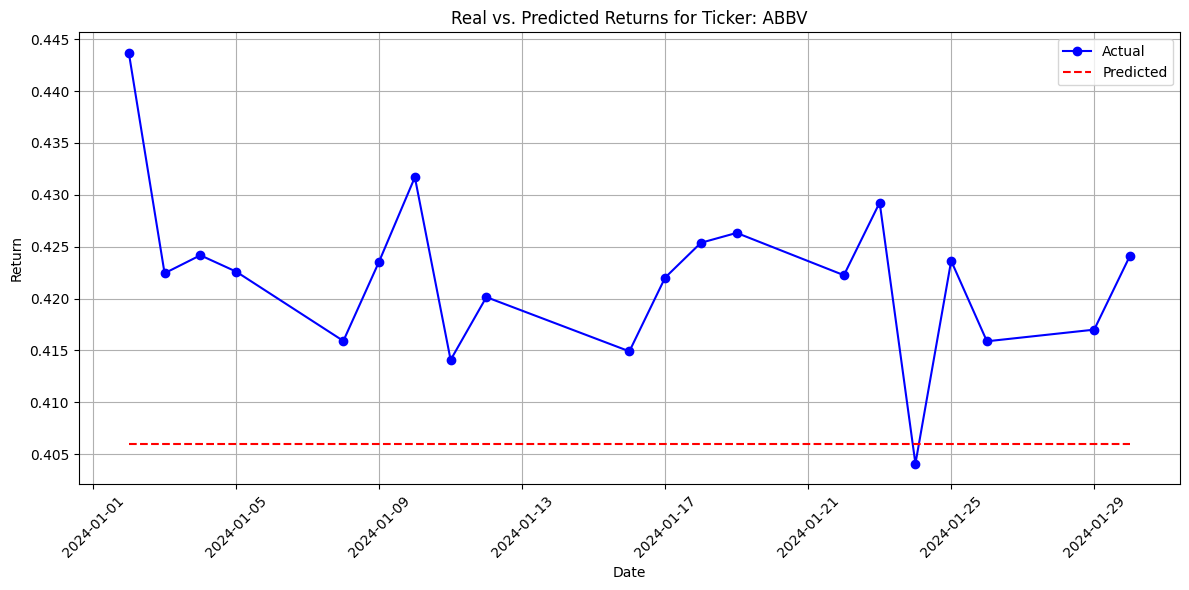

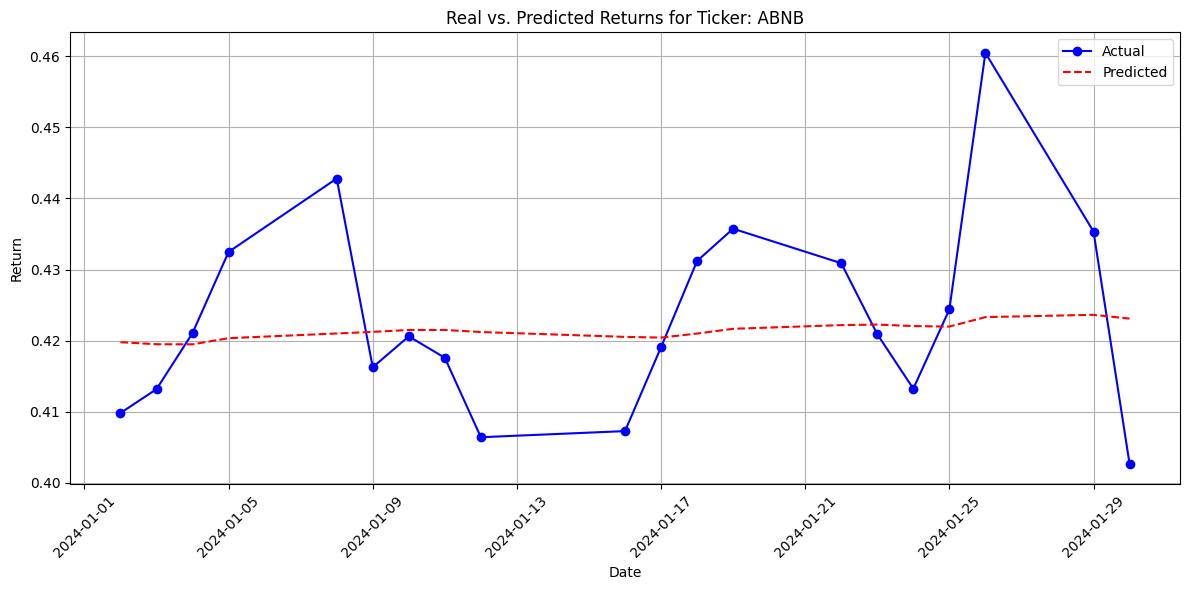

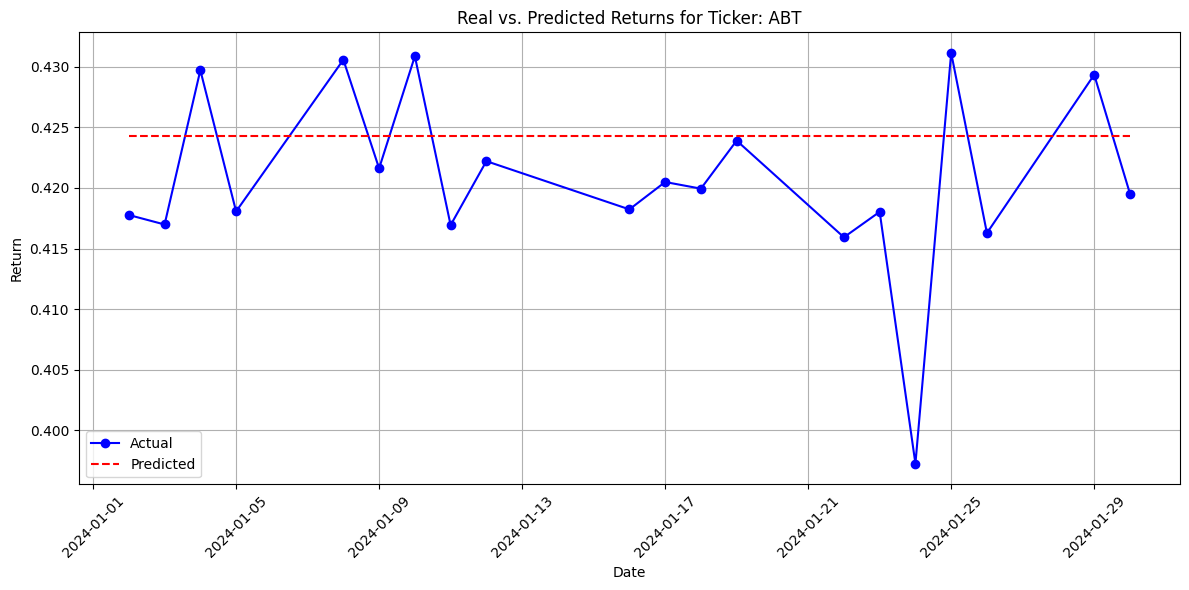

In [3]:
import matplotlib.pyplot as plt

def visualize_ensemble_results(predictions_file, num_tickers_to_plot=5):

    predictions = pd.read_csv(predictions_file)

    predictions['Date'] = pd.to_datetime(predictions['Date'])

    unique_tickers = predictions['Ticker'].unique()[:num_tickers_to_plot]

    for ticker in unique_tickers:
        ticker_data = predictions[predictions['Ticker'] == ticker]

        plt.figure(figsize=(12, 6))
        plt.plot(ticker_data['Date'], ticker_data['Actual'], label='Actual', color='blue', marker='o')
        plt.plot(ticker_data['Date'], ticker_data['Predicted'], label='Predicted', color='red', linestyle='--')
        plt.title(f"Real vs. Predicted Returns for Ticker: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

predictions_file = "svm_tuned_predictions_10_tickers.csv" 
num_tickers_to_plot = 5

visualize_ensemble_results(predictions_file, num_tickers_to_plot=num_tickers_to_plot)

Os resultados obtidos com o SVM, especialmente as previsões uniformes em muitos tickers, indicaram limitações na captura de padrões temporais complexos devido à configuração do modelo e à natureza dos dados financeiros. Desta forma pensános que o uso de técnicas de ensemble poderiam melhorar a performance e a robustez das previsões.

## Ensemble de Modelos

#### Ensemble SVM+RF+MLP

Um estudo publicado no Journal of Big Data propôs um modelo de ensemble profundo para previsão de ações, combinando SVM, Random Forest e MLP. Os resultados mostraram que o ensemble superou modelos individuais, destacando a eficácia de combinar diferentes algoritmos para capturar padrões complexos nos dados financeiros.

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler


def root_mean_squared_error(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

def sliding_window_ensemble(data, target_col, start_date, end_date, test_start_date, test_end_date, ticker):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start_date:test_end_date]

    if train_data.empty or test_data.empty:
        print(f"Skipping ticker {ticker}: Insufficient data for training or testing.")
        return pd.DataFrame(), pd.DataFrame()

    drop_columns = [target_col, "Ticker", "Return", "Close"]
    scaler = StandardScaler()

    svm = SVR(C=1.0, kernel='rbf', gamma='scale')
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
    ensemble_model = VotingRegressor([('svm', svm), ('rf', rf), ('mlp', mlp)])

    current_date = start_date
    fold_metrics = []

    while current_date + pd.DateOffset(years=2) + pd.DateOffset(months=3) <= end_date:
        train_start = current_date
        train_end = train_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        val_start = train_end + pd.DateOffset(days=1)
        val_end = val_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

        train_fold = train_data.loc[train_start:train_end]
        val_fold = train_data.loc[val_start:val_end]

        if train_fold.empty or val_fold.empty:
            print(f"Skipping fold: Insufficient data for ticker {ticker} between {train_start} and {train_end}.")
            current_date += pd.DateOffset(months=3)
            continue

        try:
            X_train = scaler.fit_transform(train_fold.drop(columns=drop_columns).values)
            y_train = train_fold[target_col].values

            X_val = scaler.transform(val_fold.drop(columns=drop_columns).values)
            y_val = val_fold[target_col].values

            ensemble_model.fit(X_train, y_train)
            val_predictions = ensemble_model.predict(X_val)

            val_rmse = root_mean_squared_error(y_val, val_predictions)
            val_mae = mean_absolute_error(y_val, val_predictions)
            val_r2 = r2_score(y_val, val_predictions)

            fold_metrics.append({
                'Fold_Start': train_start,
                'Fold_End': val_end,
                'Val_RMSE': val_rmse,
                'Val_MAE': val_mae,
                'Val_R2': val_r2
            })
        except Exception as e:
            print(f"Error during processing fold: {e}")
            continue

        current_date += pd.DateOffset(months=3)

    X_train_full = scaler.fit_transform(train_data.drop(columns=drop_columns).values)
    y_train_full = train_data[target_col].values
    ensemble_model.fit(X_train_full, y_train_full)

    X_test = scaler.transform(test_data.drop(columns=drop_columns).values)
    y_test = test_data[target_col].values
    test_predictions = ensemble_model.predict(X_test)

    predictions = pd.DataFrame({
        'Date': test_data.index,
        'Ticker': ticker,
        'Actual': y_test,
        'Predicted': test_predictions
    })

    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    metrics = pd.DataFrame([{
        'Ticker': ticker,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2
    }])

    return predictions, metrics, pd.DataFrame(fold_metrics)


test_start_date = "2024-01-01"
test_end_date = "2024-01-31"

tickers = df['Ticker'].unique()
all_predictions = []
all_metrics = []

for ticker in tickers:
    print(f"Processing ticker: {ticker}")

    df_ticker = df[df['Ticker'] == ticker].copy()
    predictions, metrics, _ = sliding_window_ensemble(
        df_ticker, target_col="Return", start_date="2010-01-01", end_date="2023-12-31",
        test_start_date=test_start_date, test_end_date=test_end_date, ticker=ticker
    )

    if not predictions.empty:
        all_predictions.append(predictions)

    if not metrics.empty:
        all_metrics.append(metrics)

if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    final_predictions.to_csv("ensemble_svm_rf_mlp_predictions.csv", index=False)

if all_metrics:
    final_metrics = pd.concat(all_metrics, ignore_index=True)
    final_metrics.to_csv("ensemble_svm_rf_mlp_metrics.csv", index=False)

print("Processing complete. Results saved.")

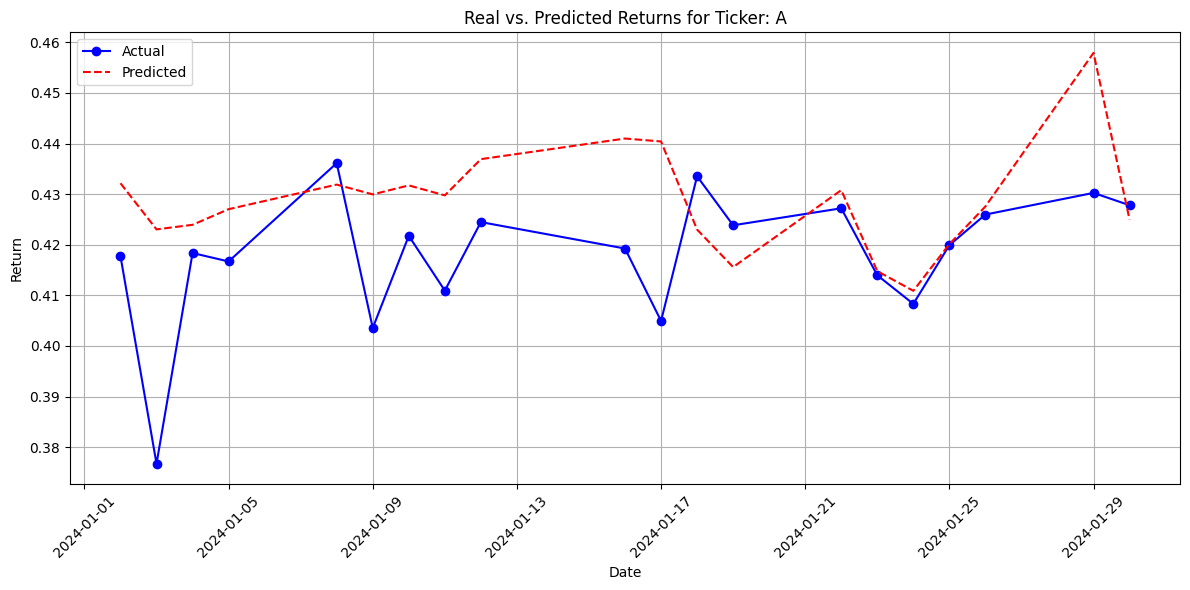

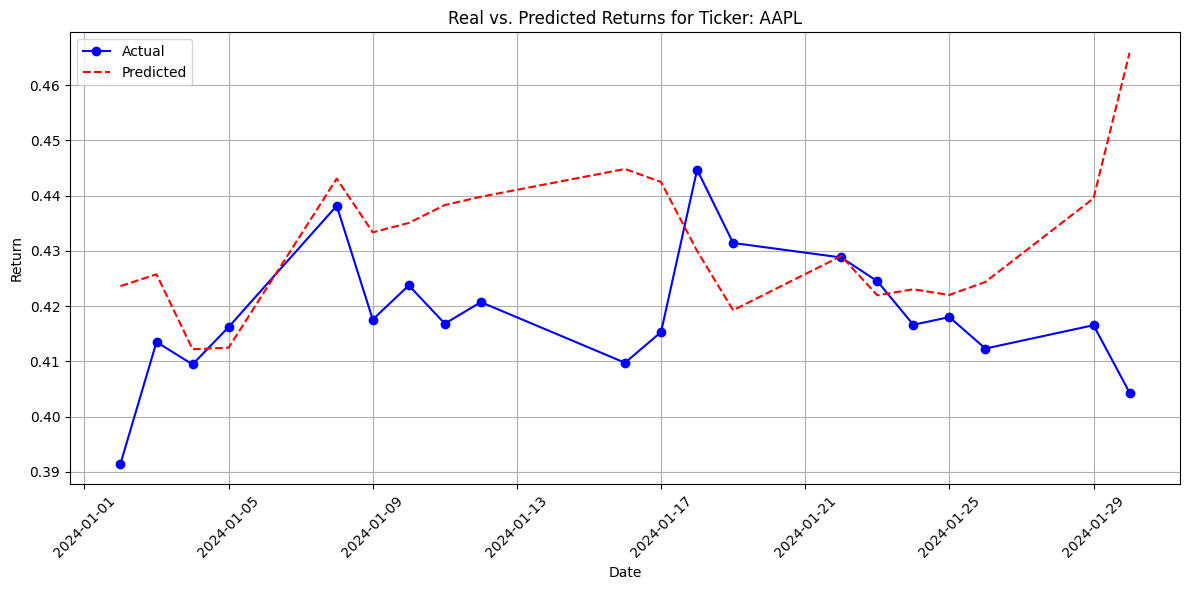

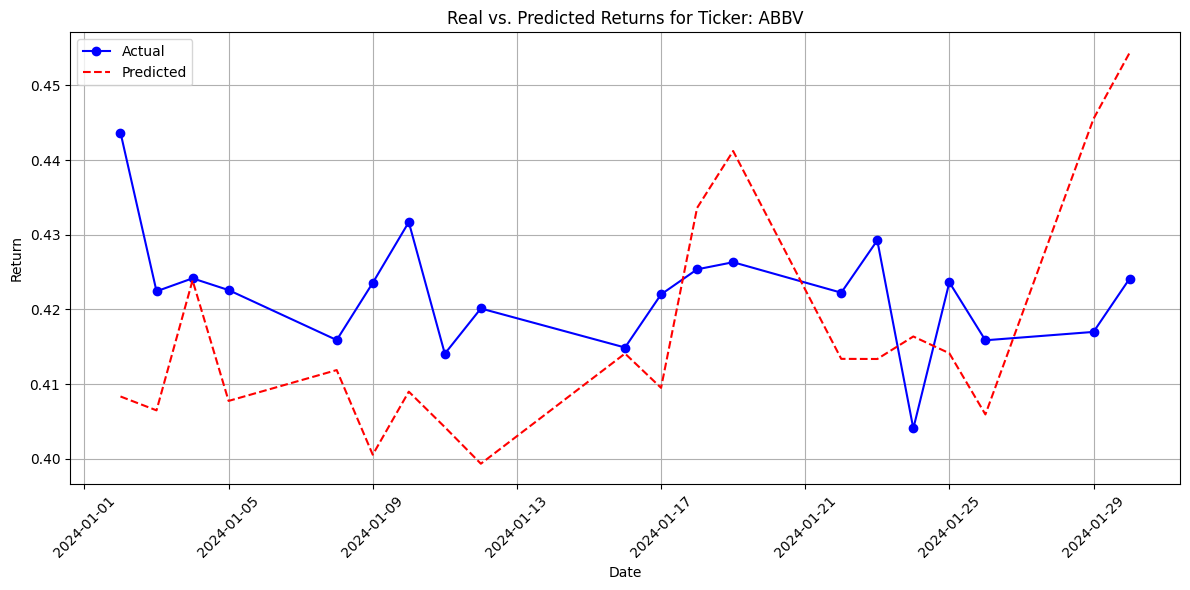

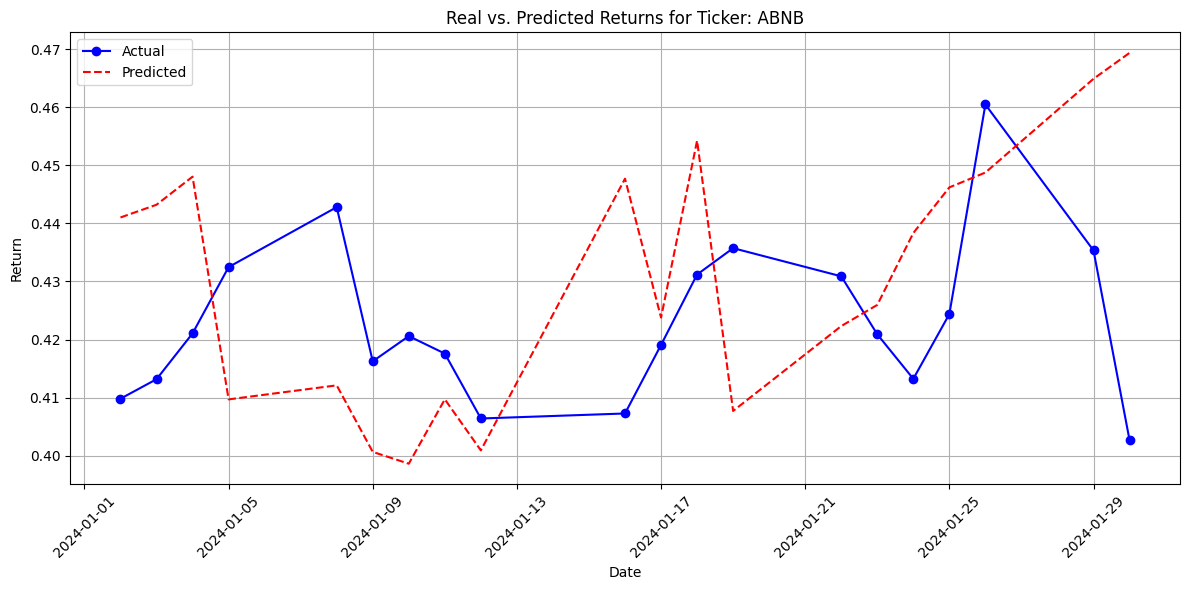

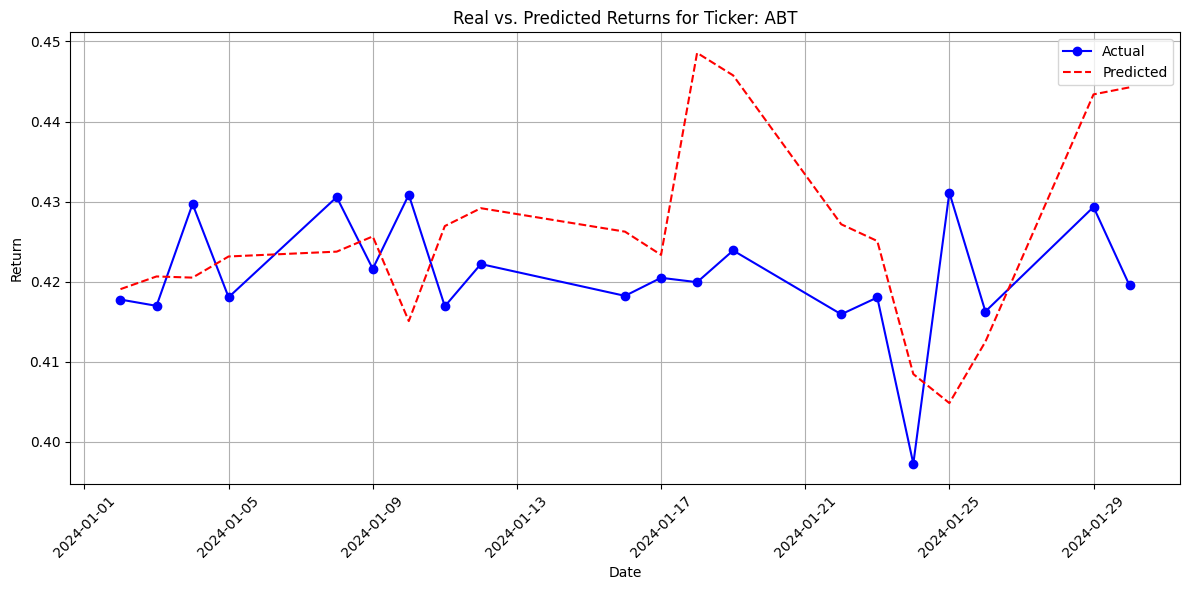

In [8]:
import matplotlib.pyplot as plt
import pandas as pd 

def visualize_ensemble_results(predictions_file, num_tickers_to_plot=5):

    predictions = pd.read_csv(predictions_file)

    predictions['Date'] = pd.to_datetime(predictions['Date'])

    unique_tickers = predictions['Ticker'].unique()[:num_tickers_to_plot]

    for ticker in unique_tickers:
        ticker_data = predictions[predictions['Ticker'] == ticker]

        plt.figure(figsize=(12, 6))
        plt.plot(ticker_data['Date'], ticker_data['Actual'], label='Actual', color='blue', marker='o')
        plt.plot(ticker_data['Date'], ticker_data['Predicted'], label='Predicted', color='red', linestyle='--')
        plt.title(f"Real vs. Predicted Returns for Ticker: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

predictions_file = "ensemble_predictions_10_tickers.csv" 
num_tickers_to_plot = 5  

visualize_ensemble_results(predictions_file, num_tickers_to_plot=num_tickers_to_plot)

C:\Users\kikot\AppData\Local\Temp\ipykernel_16724\3234658362.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x="Sector", y="Test_RMSE", palette="viridis")


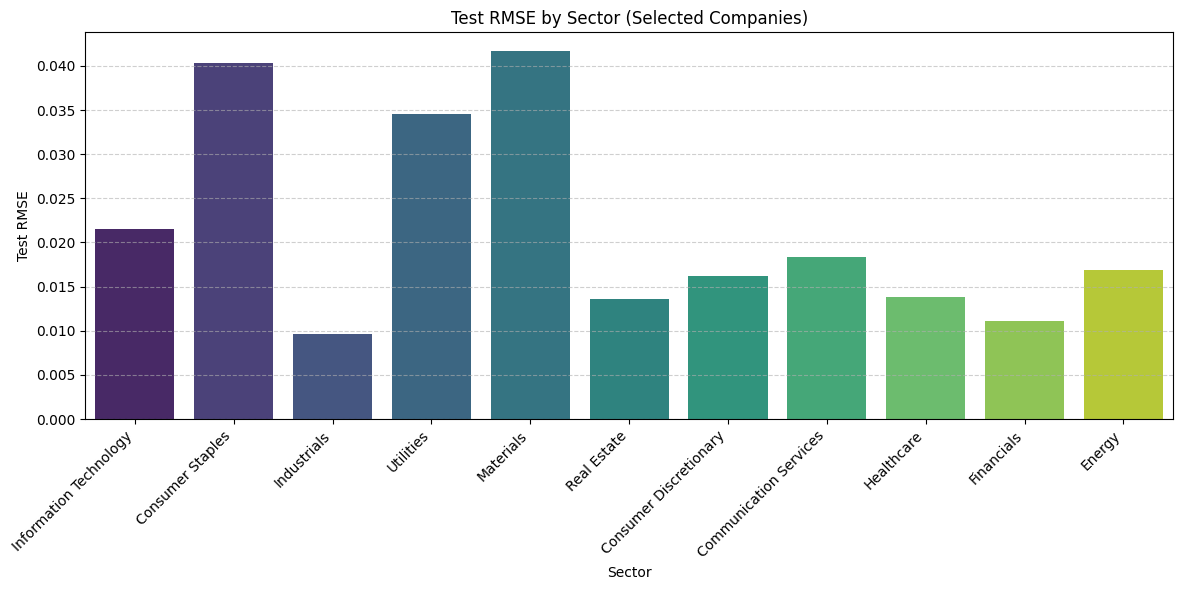

In [7]:
final_metrics = pd.read_csv("ensemble_svm_rf_mlp_metrics.csv")

selected_companies = [
    {"Ticker": "AAPL", "Sector": "Information Technology"},
    {"Ticker": "JNJ", "Sector": "Healthcare"},
    {"Ticker": "XOM", "Sector": "Energy"},
    {"Ticker": "JPM", "Sector": "Financials"},
    {"Ticker": "AMZN", "Sector": "Consumer Discretionary"},
    {"Ticker": "CHTR", "Sector": "Communication Services"},
    {"Ticker": "ADM", "Sector": "Consumer Staples"},
    {"Ticker": "ADP", "Sector": "Industrials"},
    {"Ticker": "ALB", "Sector": "Materials"},
    {"Ticker": "AMT", "Sector": "Real Estate"},
    {"Ticker": "AEE", "Sector": "Utilities"}
]

selected_companies_df = pd.DataFrame(selected_companies)

merged_data = pd.merge(final_metrics, selected_companies_df, on="Ticker")

plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data, x="Sector", y="Test_RMSE", palette="viridis")
plt.title("Test RMSE by Sector (Selected Companies)")
plt.ylabel("Test RMSE")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Materials, Consumer Staples e Utilities mostram os RMSE mais elevados, sugerindo que o modelo teve dificuldades em capturar a variabilidade ou padrões nos dados dessa empresa.

Industrials e Financials têm os menores valores de RMSE, o que sugere que o ensemble conseguiu generalizar bem os padrões dos dados desses setores.

C:\Users\kikot\AppData\Local\Temp\ipykernel_27352\569052161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data, x="Sector", y="Test_MAE", palette="muted")


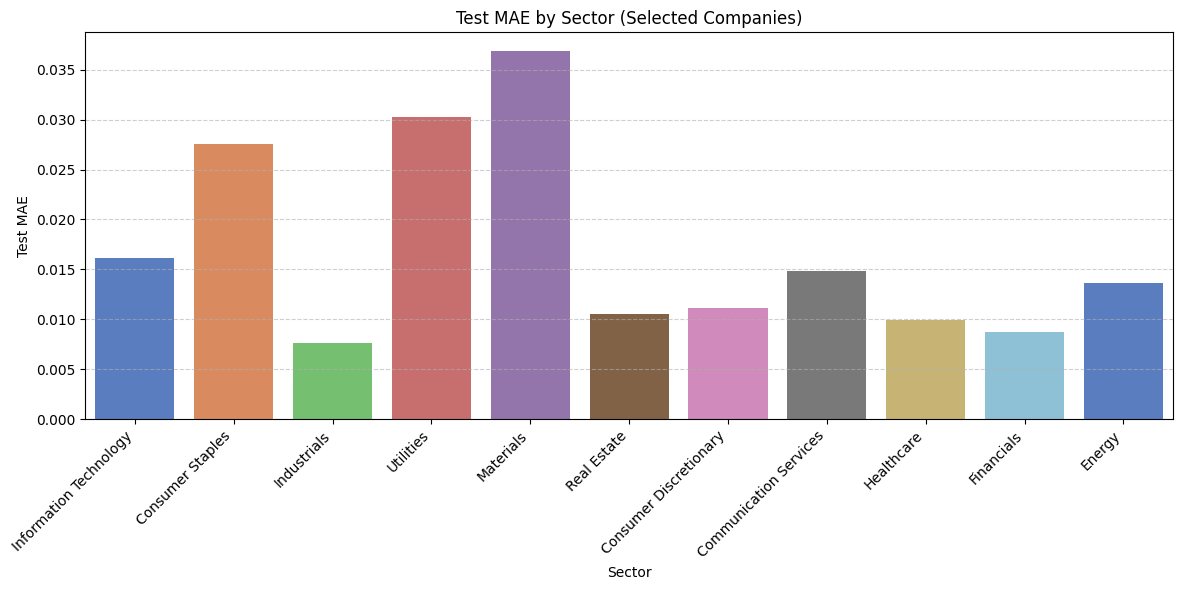

In [5]:
plt.figure(figsize=(12, 6))
sns.barplot(data=merged_data, x="Sector", y="Test_MAE", palette="muted")
plt.title("Test MAE by Sector (Selected Companies)")
plt.ylabel("Test MAE")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#####  Interpretação Geral:

Materials, Consumer Staples e Utilities apresentam os maiores valores de MAE:

Esses sectores têm uma maior diferença média entre os valores reais e previstos. 

Industrials e Financials possuem os menores valores de MAE. A baixa diferença média indica que o modelo conseguiu prever os preços desses sectores com maior precisão relativa.

Sectores intermediários, como Energy, Communication Services, e Utilities, apresentam valores moderados de MAE, sugerindo que o modelo foi razoavelmente eficaz.

# Interpretação geral das metricas

A relação entre os valores de RMSE e MAE mostra que o ensemble tem um desempenho consistente: os setores com alto RMSE também apresentam alto MAE. Essa relação indica também que os erros têm origem tanto em desvios pontuais significativos quanto em uma discrepância média nos valores previstos.

Sectores como Materials, Consumer Staples e Utilities apresentam consistentemente os piores resultados em todas as métricas.
Estes setores podem exigir uma revisão do modelo, talvez incluindo variáveis adicionais que capturem as dinâmicas específicas do setor (como sazonalidade, fatores macroeconômicos ou eventos externos).

Sectores como Industrials e Finalncials destacam-se como os mais previsíveis.
O modelo parece funcionar bem para esses setores, provavelmente devido a padrões mais consistentes nos dados históricos.


Apesar de explicar boa parte da variância, o modelo ainda tem erros consideráveis nessas previsões, indicando que há espaço para melhoria.

### Ensemble SVM+RF+LSTM

O uso de ensemble permite capturar diferentes aspectos dos dados financeiros. Por exemplo, o LSTM modela dependências temporais, enquanto o SVM e o Random Forest capturam padrões estáticos e não lineares. Essa abordagem está alinhada com o estudo, onde diferentes modelos foram combinados para obter previsões mais robustas e precisas.

A implementação usa um método de blending, onde as previsões dos modelos (LSTM-SVM e Random Forest) são combinadas por uma média simples. Essa abordagem aproveita os pontos fortes de cada modelo para fornecer previsões mais robustas, como sugerido no estudo.

Baseado no estudo Liu, B., Chen, G., Sun, Y., & Jiang, F. (2020). A hybrid model based on LSTM and SVM for stock market prediction.

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def sliding_window_ensemble(data, target_col, start_date, end_date, test_start_date, test_end_date, ticker):

    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    train_data = data.loc[start_date:end_date]
    test_data = data.loc[test_start_date:test_end_date]

    if train_data.empty or test_data.empty:
        print(f"Skipping ticker {ticker}: Insufficient data for training or testing.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    if not train_data.index.intersection(test_data.index).empty:
        raise ValueError(f"Data leakage detected for ticker {ticker}.")

    drop_columns = [target_col, "Ticker", "Return", "Close"]

    scaler = StandardScaler()

    svm = SVR(C=1.0, kernel='rbf', gamma='scale')
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(10, len(train_data.drop(columns=drop_columns).columns))),
        LSTM(50, return_sequences=False),
        Dense(1, activation='linear')
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    def create_lstm_data(X, y, timesteps=10):
        X_lstm, y_lstm = [], []
        for i in range(timesteps, len(X)):
            X_lstm.append(X[i-timesteps:i])
            y_lstm.append(y[i])
        return np.array(X_lstm), np.array(y_lstm)

    X_train_full = train_data.drop(columns=drop_columns).values
    y_train_full = train_data[target_col].values
    X_train_full = scaler.fit_transform(X_train_full)

    X_lstm, y_lstm = create_lstm_data(X_train_full, y_train_full)

    lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, verbose=0)

    fold_metrics = []
    current_date = start_date

    while current_date + pd.DateOffset(years=2) + pd.DateOffset(months=3) <= end_date:
        train_start = current_date
        train_end = train_start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        val_start = train_end + pd.DateOffset(days=1)
        val_end = val_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

        train_fold = train_data.loc[train_start:train_end]
        val_fold = train_data.loc[val_start:val_end]

        if train_fold.empty or val_fold.empty:
            print(f"Skipping fold: Insufficient training or validation data for Ticker {ticker}.")
            current_date += pd.DateOffset(months=3)
            continue

        X_train = scaler.fit_transform(train_fold.drop(columns=drop_columns).values)
        y_train = train_fold[target_col].values

        X_val = scaler.transform(val_fold.drop(columns=drop_columns).values)
        y_val = val_fold[target_col].values

        X_train_lstm, y_train_lstm = create_lstm_data(X_train, y_train)
        X_val_lstm, y_val_lstm = create_lstm_data(X_val, y_val)

        svm.fit(X_train, y_train)
        rf.fit(X_train, y_train)

        lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

        val_svm = svm.predict(X_val)
        val_rf = rf.predict(X_val)
        val_lstm = lstm_model.predict(X_val_lstm).flatten()

        min_length = min(len(val_svm), len(val_rf), len(val_lstm))

        val_ensemble = (
            val_svm[-min_length:] + 
            val_rf[-min_length:] + 
            val_lstm[-min_length:]
        ) / 3

        val_rmse = root_mean_squared_error(y_val[-min_length:], val_ensemble)
        val_mae = mean_absolute_error(y_val[-min_length:], val_ensemble)
        val_r2 = r2_score(y_val[-min_length:], val_ensemble)


        fold_metrics.append({
            'Fold_Start': train_start,
            'Fold_End': val_end,
            'Val_RMSE': val_rmse,
            'Val_MAE': val_mae,
            'Val_R2': val_r2
        })

        current_date += pd.DateOffset(months=3)

    X_test = scaler.transform(test_data.drop(columns=drop_columns).values)
    y_test = test_data[target_col].values

    X_test_lstm, _ = create_lstm_data(X_test, y_test)

    test_svm = svm.predict(X_test)
    test_rf = rf.predict(X_test)
    test_lstm = lstm_model.predict(X_test_lstm).flatten()

    min_length = min(len(test_svm), len(test_rf), len(test_lstm))

    test_ensemble = (
        test_svm[-min_length:] +
        test_rf[-min_length:] +
        test_lstm[-min_length:]
    ) / 3

    adjusted_y_test = y_test[-min_length:]

    predictions = pd.DataFrame({
        'Date': test_data.index[-min_length:],
        'Ticker': ticker,
        'Actual': adjusted_y_test,
        'Predicted': test_ensemble
    })

    test_rmse = root_mean_squared_error(adjusted_y_test, test_ensemble)
    test_mae = mean_absolute_error(adjusted_y_test, test_ensemble)
    test_r2 = r2_score(adjusted_y_test, test_ensemble)

    metrics = pd.DataFrame([{
        'Ticker': ticker,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2
    }])

    return predictions, metrics, pd.DataFrame(fold_metrics)

tickers = df['Ticker'].unique()[:10]
for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy()
    predictions, metrics, _ = sliding_window_ensemble(
        df_ticker, target_col="Return", start_date="2010-01-01", end_date="2023-12-31",
        test_start_date="2024-01-01", test_end_date="2024-01-31", ticker=ticker
    )
    print(metrics)



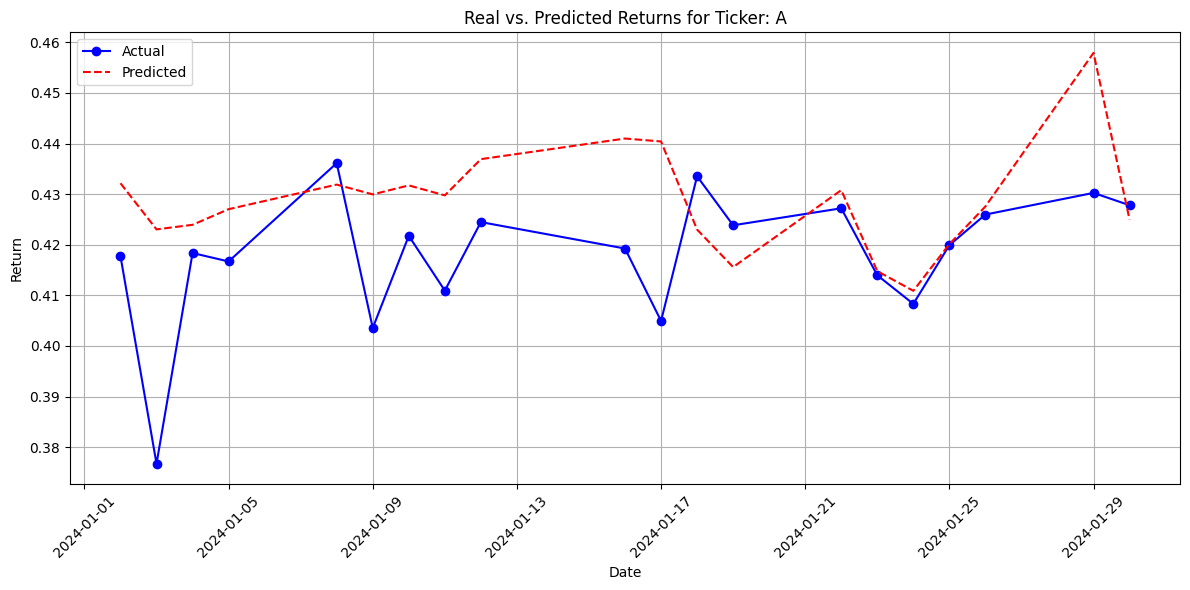

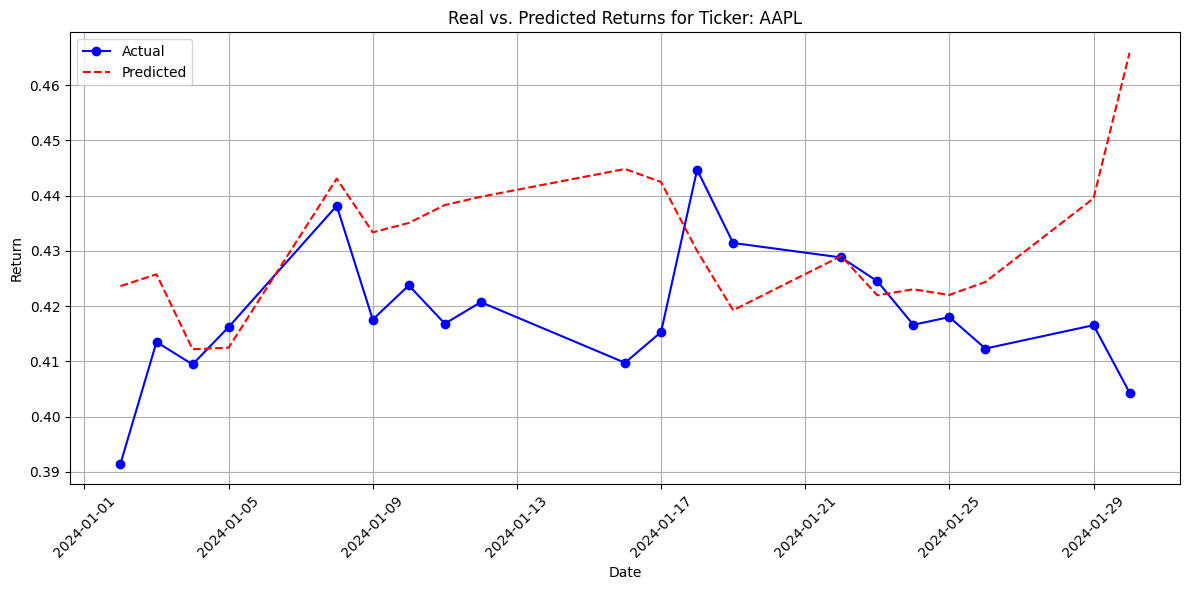

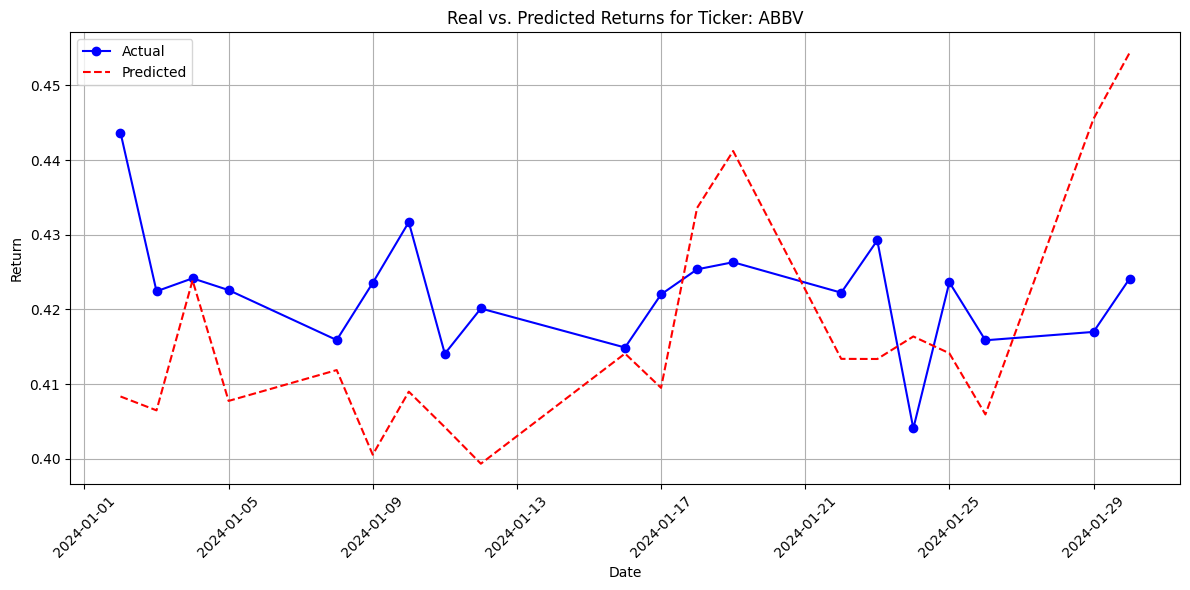

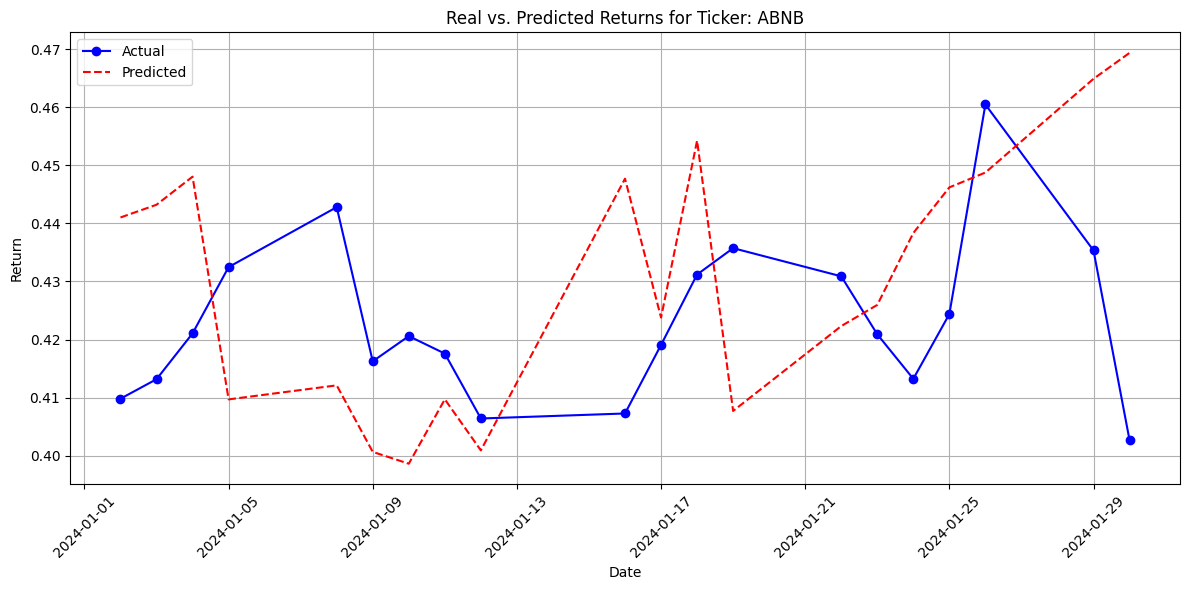

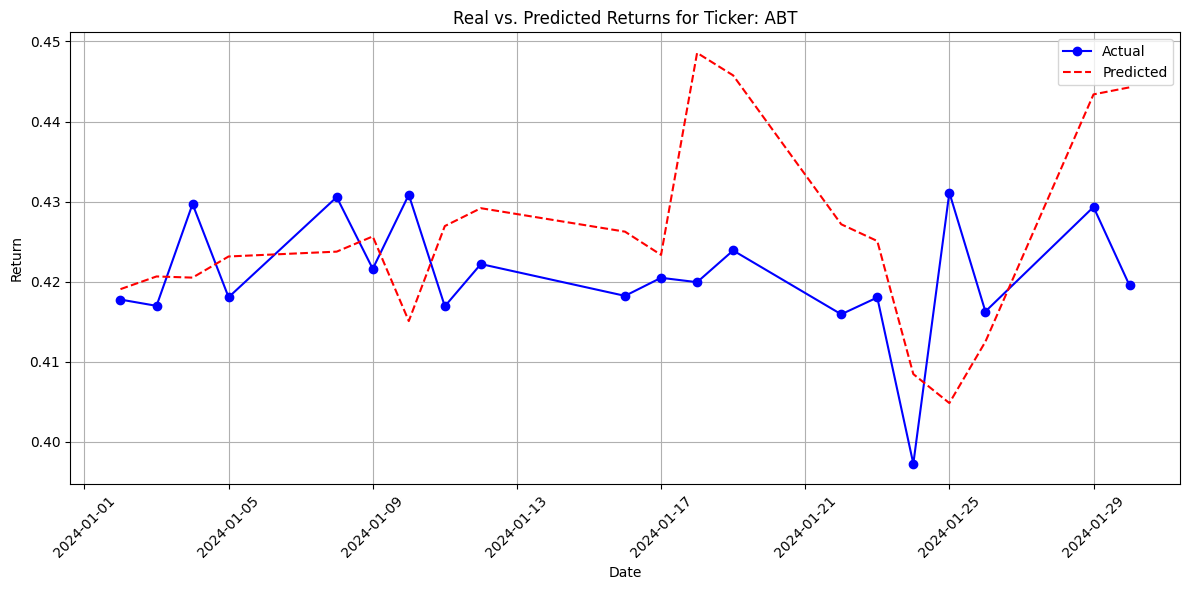

In [3]:
import matplotlib.pyplot as plt
import pandas as

def visualize_ensemble_results(predictions_file, num_tickers_to_plot=5):
    predictions = pd.read_csv(predictions_file)

    predictions['Date'] = pd.to_datetime(predictions['Date'])

    unique_tickers = predictions['Ticker'].unique()[:num_tickers_to_plot]

    for ticker in unique_tickers:
        ticker_data = predictions[predictions['Ticker'] == ticker]

        plt.figure(figsize=(12, 6))
        plt.plot(ticker_data['Date'], ticker_data['Actual'], label='Actual', color='blue', marker='o')
        plt.plot(ticker_data['Date'], ticker_data['Predicted'], label='Predicted', color='red', linestyle='--')
        plt.title(f"Real vs. Predicted Returns for Ticker: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

predictions_file = "ensemble_svm_rf_mlp_predictions_10tickers.csv" 
num_tickers_to_plot = 5  

visualize_ensemble_results(predictions_file, num_tickers_to_plot=num_tickers_to_plot)

### Conclusões de ambos os ensembles implementados

O ensemble SVM + RF + MLP mostrou-se mais robusto ao lidar com diferentes padrões dos dados financeiros, apresentando um equilíbrio entre modelos que capturam não linearidades locais (SVM), variabilidade geral (Random Forest) e padrões mais complexos (MLP). Essa combinação diversificada permitiu um melhor ajuste aos dados e generalização em múltiplos setores analisados.

Por outro lado, o LSTM, apesar de ser uma técnica poderosa para séries temporais, demonstrou limitações neste cenário. A necessidade de grandes volumes de dados e sua maior suscetibilidade ao overfitting comprometeram o seu desempenho, o que levou a previsões menos precisas e maior tempo de treinamento.."

Portanto, a combinação SVM + RF + MLP não apenas superou o ensemble com LSTM em métricas de desempenho (RMSE e MAE), como também apresentou uma relação custo-benefício superior, oferecendo previsões mais confiáveis com menor custo computacional.  Desta forma sendo ele o escolhido para integrar os modelos usados na criação do portefolio,

# Criação do portfolio com as previsões feitas pelos nossos modelos de ML

A seguinte secção destina-se à criação dos portefólios, tanto diários com as restrições devidas , como os portefólios mensais

## MonteCarlo Implementation

Algoritmos como o Monte Carlo e outros algoritmos genéticos são técnicas estatísticas amplamente utilizadas nos mercados financeiros para analisar o comportamento de um portfólio sob diferentes cenários de mercado. No contexto da otimização de portfólios, essas abordagens permitem gerar várias combinações de pesos para os ativos, calculando o retorno esperado, o risco e o Sharpe Ratio para cada uma delas.

Através dessas simulações, é possível identificar os portfólios mais eficientes, ou seja, aqueles que maximizam o retorno esperado para um determinado nível de risco. 

Vamos inicialmente focar-nos no Monte Carlo. Este método é útil especialmente em situações onde o espaço de soluções é extenso, sendo uma alternativa viável e prática para encontrar soluções ótimas aproximadas sem a necessidade de cálculos complexos.

Neste estudo, aplicamos o método de Monte Carlo para otimizar o portfólio com base nos retornos previstos dos ativos, destacando as configurações que apresentaram o maior Sharpe Ratio e o menor risco entre todas as simulações realizadas.

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from scipy.stats import shapiro, zscore
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pywt


In [ ]:
combined_data=pd.read_csv("sp500_data_with_indices_and_volume.csv")

Date Ticker        Open        High         Low       Close  \
0        2010-01-05      A   22.324751   22.331903   22.002861   22.145924   
1        2010-01-06      A   22.067240   22.174536   22.002861   22.067240   
2        2010-01-07      A   22.017166   22.045780   21.816881   22.038628   
3        2010-01-08      A   21.917025   22.067240   21.745352   22.031473   
4        2010-01-11      A   22.088697   22.210300   21.938484   22.045780   
...             ...    ...         ...         ...         ...         ...   
1672767  2024-01-24    ZTS  188.809998  189.699997  185.929993  186.070007   
1672768  2024-01-25    ZTS  185.529999  187.529999  185.309998  187.320007   
1672769  2024-01-26    ZTS  189.210007  192.880005  188.970001  191.520004   
1672770  2024-01-29    ZTS  191.360001  193.000000  189.960007  192.759995   
1672771  2024-01-30    ZTS  192.869995  193.509995  190.440002  191.429993   

          Adj Close     Volume      SMA_10      WMA_10  ...  Gold_Volume  \
0         19.835194  4186031.0    0.000000    0.000000  ...         53.0   
1         19.764730  3243779.0    0.000000    0.000000  ...        363.0   
2         19.739100  3095172.0    0.000000    0.000000  ...         56.0   
3         19.732697  3733918.0    0.000000    0.000000  ...         54.0   
4         19.745510  4781579.0    0.000000    0.000000  ...        177.0   
...             ...        ...         ...         ...  ...          ...   
1672767  184.663101  1837700.0  192.256003  190.187821  ...        253.0   
1672768  185.903641  2530600.0  191.111003  189.290367  ...        548.0   
1672769  190.071899  1840200.0  190.592003  189.364731  ...         49.0   
1672770  191.302521  1669900.0  189.974002  189.758911  ...     150708.0   
1672771  189.982559  1607500.0  189.818001  190.023637  ...     150708.0   

         Copper_Volume   DJI_Volume       CL=F         GC=F    HG=F  \
0                242.0  188540000.0  81.769997  1118.099976  3.3960   
1                109.0  186040000.0  83.180000  1135.900024  3.4775   
2                326.0  217390000.0  82.660004  1133.099976  3.4115   
3                311.0  172710000.0  82.750000  1138.199951  3.3880   
4                145.0  182050000.0  82.519997  1150.699951  3.4285   
...                ...          ...        ...          ...     ...   
1672767          523.0  336090000.0  75.089996  2013.900024  3.8825   
1672768          413.0  402970000.0  77.360001  2016.900024  3.8655   
1672769          632.0  387000000.0  78.010002  2016.800049  3.8505   
1672770          706.0  312480000.0  76.779999  2025.199951  3.8730   
1672771          706.0  312480000.0  76.779999  2025.199951  3.8730   

                 ^DJI  SP500_Close       ^VIX    Return  
0        10572.019531  1136.520020  19.350000 -0.010863  
1        10573.679688  1137.140015  19.160000 -0.003552  
2        10606.860352  1141.689941  19.059999 -0.001297  
3        10618.190430  1144.979980  18.129999 -0.000324  
4        10663.990234  1146.979980  17.549999  0.000649  
...               ...          ...        ...       ...  
1672767  37806.390625  4868.549805  13.140000 -0.010792  
1672768  38049.128906  4894.160156  13.450000  0.006718  
1672769  38109.429688  4890.970215  13.260000  0.022422  
1672770  38333.449219  4927.930176  13.600000  0.006475  
1672771  38333.449219  4927.930176  13.600000 -0.006900  

[1672772 rows x 31 columns]

In [ ]:
actual_min = combined_data['Return'].min()
actual_max = combined_data['Return'].max()
print(f"Min: {actual_min}, Max: {actual_max}")

actual_min = combined_data['SP500_Close'].min()
actual_max = combined_data['SP500_Close'].max()
print(f"Min: {actual_min}, Max: {actual_max}")


Min: -0.5386472856121842, Max: 0.7459325237678422
Min: 1022.5800170898438, Max: 4927.93017578125


Aqui iremos desnormalizar os valores previstos pelos nossos algoritmos

In [4]:
df_SVM = pd.read_csv("ensemble_svm_rf_mlp_predictions.csv")

df_RF = pd.read_csv("final_predictions.csv")

In [5]:
actual_min = -0.5386472856121842
actual_max = 0.7459325237678422

def desnormalize(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

# Desnormalizamos
df_RF['Actual_Desnormalized'] = df_RF['Actual'].apply(lambda x: desnormalize(x, actual_min, actual_max))
df_RF['Predicted_Desnormalized'] = df_RF['Predicted'].apply(lambda x: desnormalize(x, actual_min, actual_max))

df_SVM['Actual_Desnormalized'] = df_SVM['Actual'].apply(lambda x: desnormalize(x, actual_min, actual_max))
df_SVM['Predicted_Desnormalized'] = df_SVM['Predicted'].apply(lambda x: desnormalize(x, actual_min, actual_max))

Aqui calculamos o retorno e a covariancia média para depois podermos usar no Monte Carlo

In [6]:
wide_df_RF = df_RF.pivot(index='Date', columns='Ticker', values='Predicted_Desnormalized')

wide_df_SVM = df_SVM.pivot(index='Date', columns='Ticker', values='Predicted_Desnormalized')

print(wide_df_RF)
print(wide_df_SVM)

mean_returns_RF = wide_df_RF.mean()
cov_matrix_RF = wide_df_RF.cov()

mean_returns_SVM = wide_df_SVM.mean()
cov_matrix_SVM = wide_df_SVM.cov()

print("Retornos médios:\n", mean_returns_RF)
print("Matriz de covariância:\n", cov_matrix_RF)

print("Retornos médios:\n", mean_returns_SVM)
print("Matriz de covariância:\n", cov_matrix_SVM)


Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-01-02  0.002410 -0.012168  0.013526  0.001972  0.004351 -0.000083   
2024-01-03 -0.010106 -0.013655  0.006706  0.000983  0.003744  0.006194   
2024-01-04  0.002733 -0.012179  0.012061  0.003875  0.006155 -0.004759   
2024-01-05  0.004620 -0.004612  0.007331 -0.002825  0.004905 -0.001047   
2024-01-08  0.009980 -0.002873  0.006031  0.005245  0.006943 -0.009299   
2024-01-09  0.005013 -0.003047  0.004886  0.000710  0.005338 -0.009479   
2024-01-10  0.004325 -0.000877  0.011065  0.000564  0.005646  0.006064   
2024-01-11  0.006545 -0.006881  0.004878 -0.001401  0.005021  0.003683   
2024-01-12  0.005747 -0.002917  0.004363  0.000318  0.004202 -0.003567   
2024-01-16  0.007625 -0.016004  0.004049 -0.005644  0.008632  0.000093   
2024-01-17  0.004746 -0.009966  0.003745 -0.002696  0.005667  0.002746   
2024-01-18  0.007112  0.012785  0.0034

In [ ]:
wide_df = wide_df_RF.copy()

mean_returns_daily = []
cov_matrix_daily = [] 

for i in range(1, len(wide_df)):
    df_until_day = wide_df.iloc[:i]
    
    mean_returns = df_until_day.mean()
    cov_matrix = df_until_day.cov()
    
    mean_returns_daily.append(mean_returns)
    cov_matrix_daily.append(cov_matrix)


### Portfolio diário

Numa fase inicial, decidimos fazer um portfolio diário, com as restrições impostas pelo professor. Para isso foram gerados 100000 portfolios diários onde foram colocados pesos aleatoriamente nas ações. De forma a avaliar cada portfolio foi usado o retorno diario, o risco e a combinação dos mesmos  (Sharpe Ratio). No fim deste cálculo para todos os dias úteis de janeiro de 2024, foi testado com um capital de 10000 onde o resultado final está no gráfico abaixo.

In [ ]:
num_portfolios = 100000 
num_assets = wide_df.shape[1]

daily_optimal_returns = []
daily_optimal_risks = []
daily_optimal_sharpe = []
daily_optimal_weights = []

for i in range(2, len(wide_df)):

    data_until_today = wide_df.iloc[:i, :]
    
    mean_returns_daily = data_until_today.mean()
    cov_matrix_daily = data_until_today.cov()
    
    results = np.zeros((3 + num_assets, num_portfolios))
    
    for j in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return = np.sum(weights * mean_returns_daily)  # Retorno
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_daily, weights)))  # Risco
        sharpe_ratio = portfolio_return / portfolio_risk  # Sharpe Ratio
        
        results[0, j] = portfolio_return
        results[1, j] = portfolio_risk
        results[2, j] = sharpe_ratio
        results[3:, j] = weights  # Pesos
    
    columns = ['Return', 'Risk', 'Sharpe Ratio'] + data_until_today.columns.tolist()
    results_df = pd.DataFrame(results.T, columns=columns)
    
    best_portfolio = results_df.loc[results_df['Sharpe Ratio'].idxmax()]
    
    daily_optimal_returns.append(best_portfolio['Return'])
    daily_optimal_risks.append(best_portfolio['Risk'])
    daily_optimal_sharpe.append(best_portfolio['Sharpe Ratio'])
    daily_optimal_weights.append(best_portfolio[3:].values)

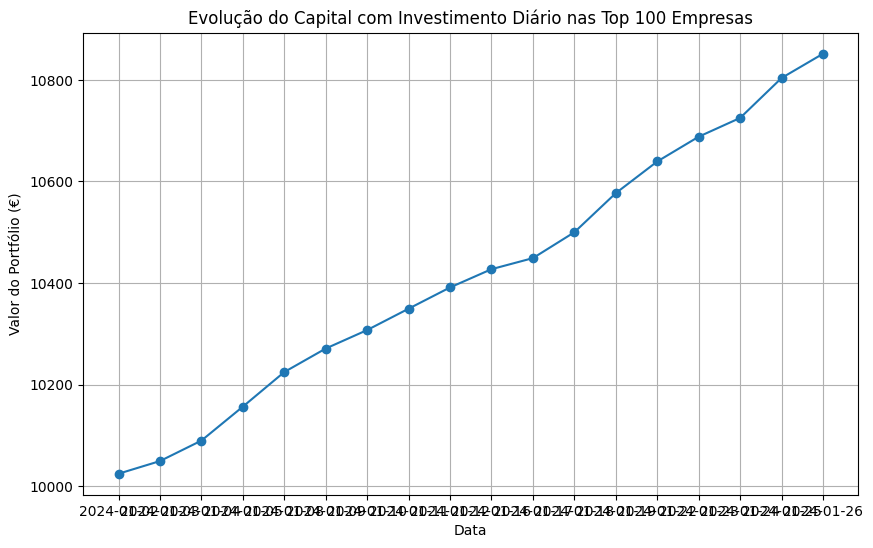

In [10]:
capital = 10000
capital_history = []
dates_history = []

for day, weights in enumerate(daily_optimal_weights):
    if day >= len(wide_df_RF.index):
        break
    
    date = wide_df_RF.index[day]
    dates_history.append(date)
    
    temp_df = pd.DataFrame({
        'Ticker': wide_df_RF.columns,
        'Weight': weights
    })
    top_100 = temp_df.sort_values(by='Weight', ascending=False).head(100)
    top_100_tickers = top_100['Ticker'].values
    
    returns_of_day = wide_df_RF.loc[date, top_100_tickers]
    average_return = returns_of_day.mean()
    
    capital = capital * (1 + average_return)
    capital_history.append(capital)

capital_df = pd.DataFrame({
    'Date': dates_history,
    'Portfolio Value': capital_history
})

plt.figure(figsize=(10, 6))
plt.plot(capital_df['Date'], capital_df['Portfolio Value'], marker='o', linestyle='-')
plt.title("Evolução do Capital com Investimento Diário nas Top 100 Empresas")
plt.xlabel("Data")
plt.ylabel("Valor do Portfólio (€)")
plt.grid()
plt.show()


In [ ]:
capital = 10000
dates = wide_df_RF.index[:len(daily_optimal_returns)]

retorno_acumulado = capital * np.cumprod([1 + r for r in daily_optimal_returns])

capital_df = pd.DataFrame({
    'Date': dates,
    'Retorno Acumulado': retorno_acumulado
})

plt.figure(figsize=(10, 6))
plt.plot(capital_df['Date'], capital_df['Retorno Acumulado'], marker='o', linestyle='-')
plt.title("Retorno Acumulado do Portfólio")
plt.xlabel("Data")
plt.ylabel("Valor Acumulado (€)")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#print(capital_df)


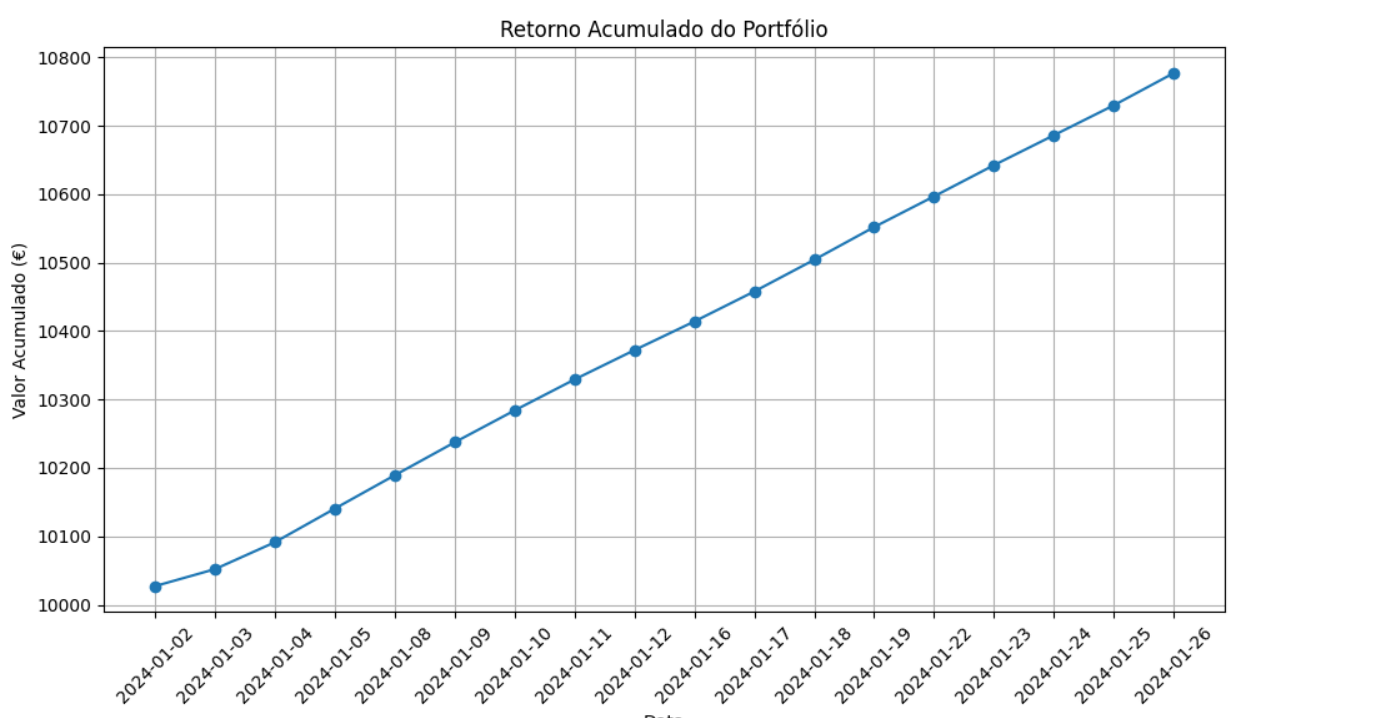

Como podemos observar pelos gráficos, o retorno foi bastante substancial, resultando em um aumento de cerca de 8% no capital inicial ao final do mês. Este crescimento reflete a eficácia do método de alocação diária de investimentos baseado no algoritmo Monte Carlo.

O uso deste algoritmo permitiu-nos identificar os 100 melhores ativos diariamente, baseando-se em uma simulação que otimizou os retornos e minimizou os riscos ao mesmo tempo. Além disso, a aplicação diária deste método mostrou que é possível capturar pequenas variações positivas no mercado, mesmo considerando as restrições como o capital inicial limitado, o custo transacional e o volume máximo diário.

No entanto, é importante destacar que os custos transacionais (1€ por ação) podem ter impacto significativo no desempenho final, especialmente quando o volume de transações é elevado. Por fim, a análise apresentada comprova que o algoritmo de Monte Carlo é uma ferramenta poderosa para simular e otimizar portfólios, proporcionando resultados consistentes e melhorando o retorno sobre o investimento ao longo do tempo.

### Portfólio Mensal

De seguida iremos abordar de maneira diferente este problema, fazendo um portfolio mensal ao invés de um portfolio diário. Desta forma conseguimos uma maior estabilidade já que, a alocação mensal tende a ser menos sensível às flutuações de curto prazo, focando em tendências de longo prazo e evitando decisões reativas a ruídos do mercado. Além disso, um portfólio mensal é mais "passivo", o que reduz a necessidade de monitoramento constante. É ideal quando o objetivo é ter uma abordagem de médio/longo prazo


In [ ]:
mean_returns = mean_returns_SVM # Para testar com RF basta substituir para mean_returns_RF
cov_matrix = cov_matrix_SVM 

In [ ]:
num_portfolios = 100000 
num_assets = len(mean_returns)


results = np.zeros((3 + num_assets, num_portfolios))  
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(weights * mean_returns)  
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    
    sharpe_ratio = portfolio_return / portfolio_stddev
    
    results[0, i] = portfolio_return  
    results[1, i] = portfolio_stddev  
    results[2, i] = sharpe_ratio             
    results[3:, i] = weights                 

    weights_record.append(weights)

columns = ['Return', 'Risk', 'Sharpe Ratio'] + mean_returns.index.tolist()
results_df = pd.DataFrame(results.T, columns=columns)


In [ ]:
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
min_risk_idx = results_df['Risk'].idxmin()

print("Portfólio com Maior Sharpe Ratio:\n", results_df.iloc[max_sharpe_idx])
print("\nPortfólio com Menor Risco:\n", results_df.iloc[min_risk_idx])


Portfólio com Maior Sharpe Ratio:
 Return          0.011224
Risk            0.007174
Sharpe Ratio    1.564421
A               0.000363
AAPL            0.002337
                  ...   
XYL             0.003660
YUM             0.000086
ZBH             0.002112
ZBRA            0.003039
ZTS             0.001024
Name: 24049, Length: 500, dtype: float64

Portfólio com Menor Risco:
 Return          0.010224
Risk            0.006863
Sharpe Ratio    1.489643
A               0.002330
AAPL            0.001847
                  ...   
XYL             0.001311
YUM             0.001647
ZBH             0.001248
ZBRA            0.001851
ZTS             0.002640
Name: 46606, Length: 500, dtype: float64


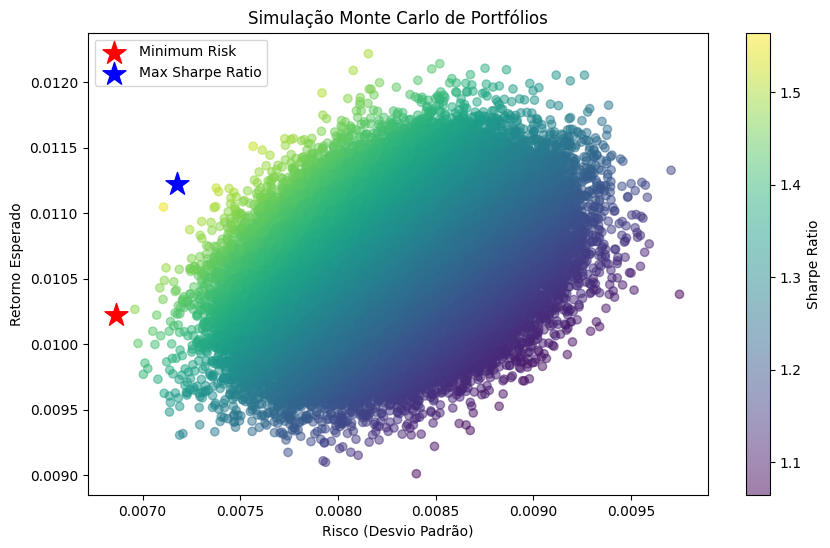

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')


plt.scatter(results_df.loc[min_risk_idx, 'Risk'], results_df.loc[min_risk_idx, 'Return'], color='red', marker='*', s=300, label='Minimum Risk')
plt.scatter(results_df.loc[max_sharpe_idx, 'Risk'], results_df.loc[max_sharpe_idx, 'Return'], color='blue', marker='*', s=300, label='Max Sharpe Ratio')

plt.title('Simulação Monte Carlo de Portfólios')
plt.xlabel('Risco (Desvio Padrão)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.show()


Com este gráfico, é possivel observar tanto o portfolio com maior Sharpe Ratio, como o portfolio com menor risco. 

O portfolio com maior Sharpe Ratio oferece o melhor retorno ajustado ao risco, ou seja, maximiza os ganhos esperados para cada unidade de risco. Como referido em cima, no gráfico, este ponto está mais à esquerda em termos de risco e no topo em retorno, mas sem sair muito da região central da distribuição.

Já em relação ao portfolio com risco minimo, ele apresenta o menor desvio padrão possível, o que significa que é a solução mais conservadora, mas com um retorno esperado mais baixo em comparação ao outro portfólio

O gráfico mostra ainda a fronteira, onde estão os portfólios que oferecem o melhor retorno para um dado nível de risco. Qualquer ponto fora dessa fronteira representa uma alocação menos eficiente, ou seja, portfolios que assumem mais risco para um retorno igual ou menor. Isso reforça a importância de otimizar os pesos do portfólio para encontrar a relação ideal risco-retorno.

### Algoritmo Genético

Vamos agora avançar para o algoritmo genético para podermos comparar o desempenho deste com o Monte Carlo (e posteriormente com o índice do S&P 500).

O algoritmo genético é uma técnica de otimização inspirada no processo de seleção natural, onde soluções candidatas (neste caso, portfólios de ativos) evoluem ao longo de múltiplas gerações em busca de um objetivo específico (aqui representado pela maximização do Sharpe Ratio)

Este método utiliza operações como seleção, crossover (cruzamento) e mutação para explorar diferentes combinações de pesos dos ativos, ajustando-os iterativamente para encontrar a solução ótima.

Com isso, esperamos que o algoritmo genético seja capaz de identificar um portfólio com uma relação retorno/risco ainda melhor do que a obtida pelo método de Monte Carlo, uma vez que, ao contrário das simulações puramente aleatórias, o algoritmo genético utiliza heurísticas para guiar a busca por soluções mais eficientes.

Nos próximos passos, analisaremos os resultados obtidos, comparando o retorno, a volatilidade e o Sharpe Ratio do portfólio gerado pelo algoritmo genético com os resultados do Monte Carlo e com o desempenho do S&P 500 no período de análise.

Para este algoritmo foi feito um tunning manual, com base no risco e no retorno. Os melhores valores obtidos foram então colocados para um teste final para podermos comparar com o Monte Carlo e o S&P 500

In [ ]:
np.random.seed(42)
num_assets = len(mean_returns)
population_size = 100  
generations = 600  
mutation_rate = 0.1 


def calculate_sharpe(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns)  
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return portfolio_return / portfolio_stddev


def initialize_population(pop_size, num_assets):
    population = []
    for _ in range(pop_size):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        population.append(weights)
    return np.array(population)

def select_best(population, fitness, num_best=10): 
    sorted_indices = np.argsort(fitness)[-num_best:] 
    return population[sorted_indices]

def crossover(parent1, parent2):
    child = (parent1 + parent2) / 2
    return child / np.sum(child)

def mutate(weights, mutation_rate):
    if np.random.rand() < mutation_rate:
        mutation = np.random.random(len(weights))
        weights += mutation
        weights /= np.sum(weights)
    return weights

population = initialize_population(population_size, num_assets)

for generation in range(generations):
    fitness = np.array([calculate_sharpe(weights, mean_returns, cov_matrix) for weights in population])
    best_portfolios = select_best(population, fitness)
    
    new_population = []
    for i in range(population_size):
        parent1, parent2 = best_portfolios[np.random.choice(len(best_portfolios), 2, replace=False)]
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        new_population.append(child)
    
    population = np.array(new_population)
    
    if generation % 50 == 0:
        best_fitness = max(fitness)
        print(f"Geração {generation}, Melhor Sharpe Ratio: {best_fitness:.4f}")

fitness = np.array([calculate_sharpe(weights, mean_returns, cov_matrix) for weights in population])

optimal_weights_GA = population[np.argmax(fitness)]
best_fitness = max(fitness)
print("\nMelhor Portfólio Encontrado:")
for i, ticker in enumerate(mean_returns.index):
    print(f"{ticker}: {optimal_weights_GA[i]:.4f}")


Geração 0, Melhor Sharpe Ratio: 1.3915
Geração 50, Melhor Sharpe Ratio: 1.4303
Geração 100, Melhor Sharpe Ratio: 1.4496
Geração 150, Melhor Sharpe Ratio: 1.4545
Geração 200, Melhor Sharpe Ratio: 1.4744
Geração 250, Melhor Sharpe Ratio: 1.4744
Geração 300, Melhor Sharpe Ratio: 1.4921
Geração 350, Melhor Sharpe Ratio: 1.4921
Geração 400, Melhor Sharpe Ratio: 1.4921
Geração 450, Melhor Sharpe Ratio: 1.4921
Geração 500, Melhor Sharpe Ratio: 1.4921
Geração 550, Melhor Sharpe Ratio: 1.4921

Melhor Portfólio Encontrado:
A: 0.0018
AAPL: 0.0019
ABBV: 0.0024
ABNB: 0.0021
ABT: 0.0019
ACGL: 0.0016
ACN: 0.0016
ADBE: 0.0028
ADI: 0.0033
ADM: 0.0017
ADP: 0.0018
ADSK: 0.0021
AEE: 0.0025
AEP: 0.0019
AES: 0.0013
AFL: 0.0023
AIG: 0.0030
AIZ: 0.0018
AJG: 0.0017
AKAM: 0.0019
ALB: 0.0028
ALGN: 0.0032
ALL: 0.0028
ALLE: 0.0021
AMAT: 0.0009
AMCR: 0.0020
AMD: 0.0020
AME: 0.0019
AMGN: 0.0037
AMP: 0.0022
AMT: 0.0010
AMZN: 0.0028
ANET: 0.0020
ANSS: 0.0005
AON: 0.0016
AOS: 0.0034
APA: 0.0026
APD: 0.0015
APH: 0.0022


In [ ]:
portfolio_return = np.sum(optimal_weights_GA * mean_returns)  
portfolio_stddev = np.sqrt(np.dot(optimal_weights_GA.T, np.dot(cov_matrix, optimal_weights_GA)))  
sharpe_ratio = portfolio_return / portfolio_stddev 

print("\nDesempenho do Melhor Portfólio:")
print(f"Retorno Esperado Anualizado: {portfolio_return:.4f}")
print(f"Risco (Volatilidade) Anualizado: {portfolio_stddev:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")



Desempenho do Melhor Portfólio:
Retorno Esperado Anualizado: 0.0109
Risco (Volatilidade) Anualizado: 0.0073
Sharpe Ratio: 1.4921


## Comparação do  Monte Carlo com GA nos índices abordados

Vamos agora passar à comparação do desempenho dos nossos portfólios com três índices muito relevantes nos dias de hoje, sendo eles o SP500, o NASDAQ e o DowJones

In [ ]:
sp500 = yf.download('^GSPC', start='2023-12-31', end='2024-01-31')['Adj Close']
nasdaq = yf.download('^IXIC', start='2023-12-31', end='2024-01-31')['Adj Close']
dow_jones = yf.download('^DJI', start='2023-12-31', end='2024-01-31')['Adj Close']

sp500_return = sp500.pct_change()
nasdaq_return = nasdaq.pct_change()
dow_return = dow_jones.pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
returns_data = wide_df_RF

optimal_weights_MC = results_df.iloc[results_df['Sharpe Ratio'].idxmax(), 3:]

optimal_weights_GA = optimal_weights_GA / np.sum(optimal_weights_GA)
optimal_weights_MC = optimal_weights_MC / np.sum(optimal_weights_MC)

weighted_returns_MC = returns_data * optimal_weights_MC
weighted_returns_GA = returns_data * optimal_weights_GA

portfolio_daily_return_MC = weighted_returns_MC.sum(axis=1)
portfolio_daily_return_GA = weighted_returns_GA.sum(axis=1)

portfolio_returns_MC = pd.DataFrame({
    'Date': returns_data.index, 
    'Portfolio_Return': portfolio_daily_return_MC  
})

portfolio_returns_GA = pd.DataFrame({
    'Date': returns_data.index,  
    'Portfolio_Return': portfolio_daily_return_GA
})

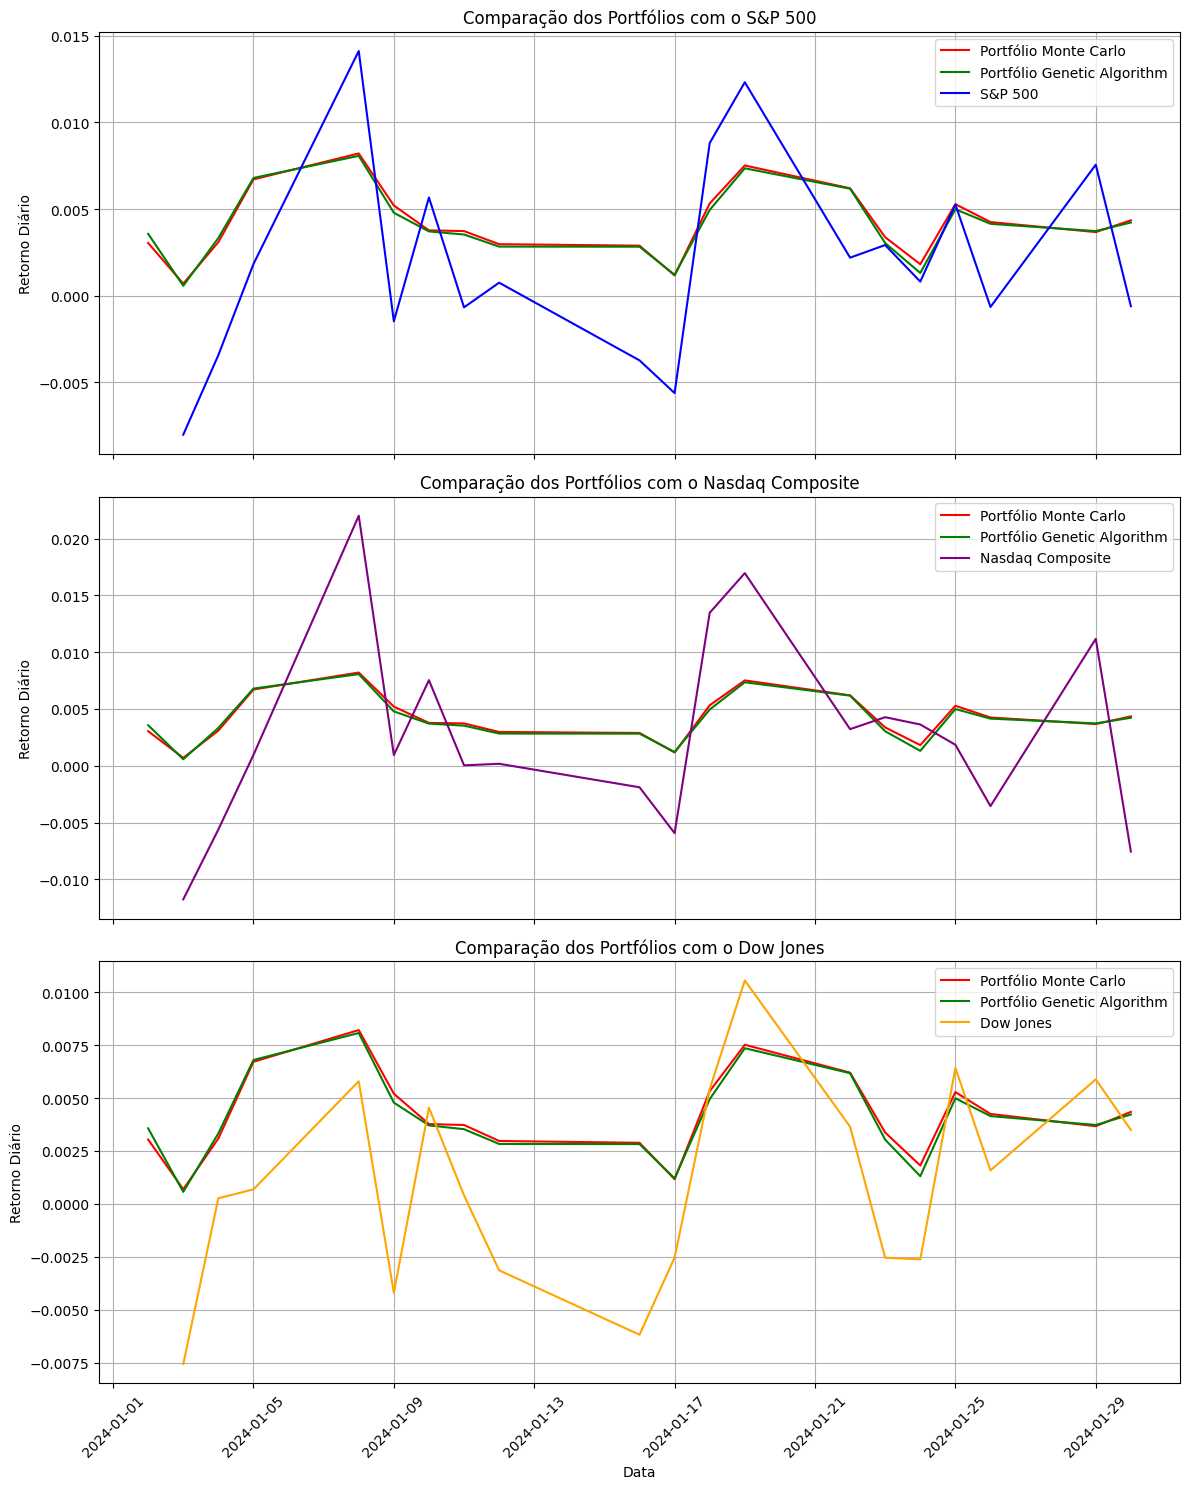

In [ ]:
portfolio_aligned_MC = portfolio_returns_MC['Portfolio_Return'].values
portfolio_aligned_GA = portfolio_returns_GA['Portfolio_Return'].values

portfolio_returns_MC['Date'] = pd.to_datetime(portfolio_returns_MC['Date'])
portfolio_returns_GA['Date'] = pd.to_datetime(portfolio_returns_GA['Date'])

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

axs[0].plot(portfolio_returns_MC['Date'], portfolio_aligned_MC, label='Portfólio Monte Carlo', color='red')
axs[0].plot(portfolio_returns_GA['Date'], portfolio_aligned_GA, label='Portfólio Genetic Algorithm', color='green')
axs[0].plot(sp500_return.index, sp500_return, label="S&P 500", color='blue')
axs[0].set_title("Comparação dos Portfólios com o S&P 500")
axs[0].set_ylabel("Retorno Diário")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(portfolio_returns_MC['Date'], portfolio_aligned_MC, label='Portfólio Monte Carlo', color='red')
axs[1].plot(portfolio_returns_GA['Date'], portfolio_aligned_GA, label='Portfólio Genetic Algorithm', color='green')
axs[1].plot(nasdaq_return.index, nasdaq_return, label="Nasdaq Composite", color='purple')
axs[1].set_title("Comparação dos Portfólios com o Nasdaq Composite")
axs[1].set_ylabel("Retorno Diário")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(portfolio_returns_MC['Date'], portfolio_aligned_MC, label='Portfólio Monte Carlo', color='red')
axs[2].plot(portfolio_returns_GA['Date'], portfolio_aligned_GA, label='Portfólio Genetic Algorithm', color='green')
axs[2].plot(dow_return.index, dow_return, label="Dow Jones", color='orange')
axs[2].set_title("Comparação dos Portfólios com o Dow Jones")
axs[2].set_xlabel("Data")
axs[2].set_ylabel("Retorno Diário")
axs[2].legend()
axs[2].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Discussão de resultados

Podemos observar pelos gráficos que, no geral, os portfólios Monte Carlo e o Algoritmo Genético apresentaram retornos mais estáveis e menos voláteis em comparação com os índices S&P 500, Nasdaq Composite e Dow Jones. Esta consistência é visível pela menor amplitude das variações nos nossos portfólios, que tendem a seguir linhas mais suaves ao longo do tempo. 

#### Gráfico 1

Os nossos portfólios seguem uma trajetória semelhante, mas com oscilações mais suaves, o que pode indicar uma gestão de risco mais eficiente.
Em alguns momentos, os portfólios superam o retorno diário do S&P 500, principalmente nos dias iniciais.

#### Gráfico 2

O Nasdaq Composite apresenta uma maior volatilidade e algumas quedas bruscas, refletindo a natureza mais tecnológica e volátil desse índice.
Novamente, os nossos portfólios são menos voláteis e mantêm um padrão mais constante, especialmente na segunda metade do período analisado.
Vemos ainda que a trajetória dos portfólios aproxima-se do índice em vários momentos, mas evita os extremos negativos.

#### Gráfico 3

Os portfólios Monte Carlo e Genético destacam-se uma vez mais por manter um retorno constante e menos afetado pelos movimentos extremos observados no índice Dow Jones. Esse comportamento é mais evidente aqui, reforçando a robustez da estratégia adotada.

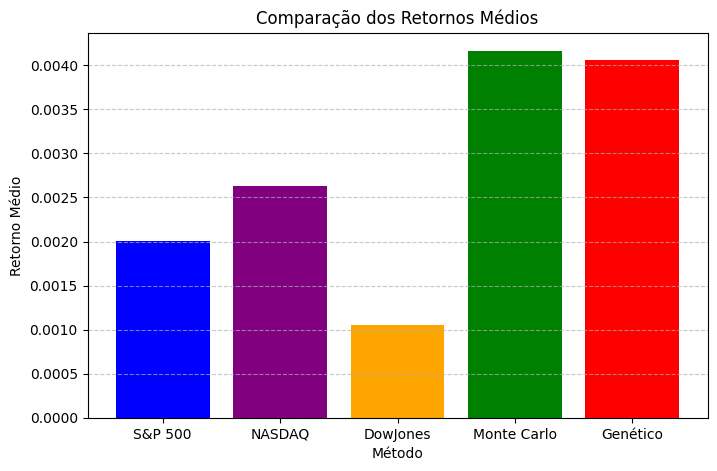

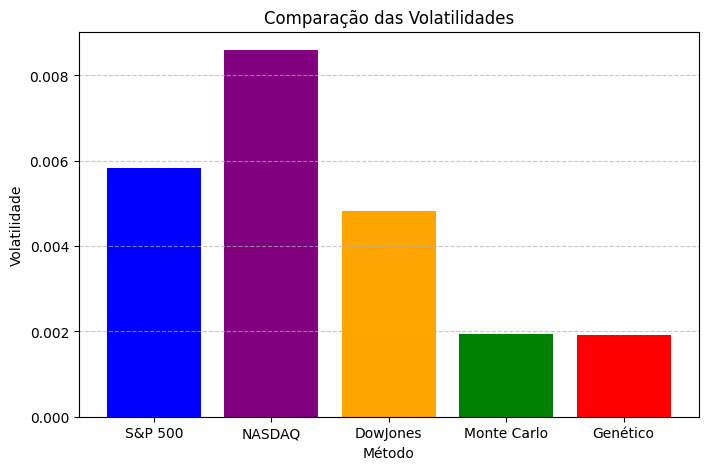

In [ ]:
retorno_sp500 = sp500_return.mean().iloc[0]
retorno_nasdaq = nasdaq_return.mean().iloc[0]
retorno_dowjones = dow_return.mean().iloc[0]
retorno_mc = portfolio_returns_MC['Portfolio_Return'].mean()
retorno_ga = portfolio_returns_GA['Portfolio_Return'].mean()

#print(retorno_sp500)

vol_sp500 = sp500_return.std().iloc[0]
vol_nasdaq = nasdaq_return.std().iloc[0]
vol_dowjones = dow_return.std().iloc[0]
vol_mc = np.std(portfolio_returns_MC['Portfolio_Return'])
vol_ga = np.std(portfolio_returns_GA['Portfolio_Return'])

categorias = ['S&P 500', 'NASDAQ', 'DowJones', 'Monte Carlo', 'Genético']
retornos = [retorno_sp500, retorno_nasdaq, retorno_dowjones, retorno_mc, retorno_ga]
volatilidades = [vol_sp500, vol_nasdaq, vol_dowjones, vol_mc, vol_ga]

plt.figure(figsize=(8, 5))
plt.bar(categorias, retornos, color=['blue', 'purple', 'orange', 'green', 'red'])
plt.title('Comparação dos Retornos Médios')
plt.ylabel('Retorno Médio')
plt.xlabel('Método')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

plt.figure(figsize=(8, 5))
plt.bar(categorias, volatilidades, color=['blue', 'purple', 'orange', 'green', 'red'])
plt.title('Comparação das Volatilidades')
plt.ylabel('Volatilidade')
plt.xlabel('Método')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Discussão de resultados

#### Gráfico 1 (Retornos médios)

Os nossos portfólios apresentaram retornos médios significativamente superiores aos índices de mercado (S&P 500, NASDAQ e Dow Jones). O retorno médio do Monte Carlo e do Genético está próximo de 0.0042, destacando o sucesso destes métodos na otimização de portfólios.

#### Gráfico 2 (Risco médio)

Mais uma vez estes apresentaram volatilidades muito inferiores em relação aos índices de mercado. A volatilidade dos portfólios é em torno de 0.002, indicando maior estabilidade e menor risco.


Assim, os resultados sugerem que tanto o Monte Carlo quanto o Algoritmo Genético são estratégias eficazes para otimizar portfólios, proporcionando retornos superiores com menor volatilidade, quando comparados aos índices tradicionais.

## Conclusão

Neste projeto, desenvolvemos uma abordagem robusta para previsão e otimização de portfólios de ações no contexto do S&P500. Utilizando métodos de machine learning como Random Forest e SVM, realizamos previsões dos retornos diários dos ativos, o que serviu como base para a alocação otimizada dos recursos. Paralelamente, implementamos técnicas de otimização de portfólios, com destaque para simulações de Monte Carlo e Algoritmos Genéticos, a fim de identificar o conjunto de ações mais vantajoso a cada dia.

Apesar dos resultados positivos sabemos que o projeto pode ser melhorado em diversas formas, tais como:
    Explorar modelos mais sofisticados, como LSTM ou redes neurais profundas, para capturar dependências temporais dos dados.
    Introduzir técnicas mais avançadas de otimização, como algoritmos híbridos ou estratégias de otimização em tempo real.

Em suma, o trabalho demonstrou que a aplicação de algoritmos de machine learning combinada com métodos de otimização oferece uma solução promissora para enfrentar os desafios do mercado financeiro, proporcionando retornos ajustados ao risco de forma eficiente e adaptativa.

# REFERENCES

Shen, S., Jiang, H. & Zhang, T. (2012) Stock market forecasting using machine learning algorithms. Department of Electrical Engineering, Stanford University. [https://cs229.stanford.edu/proj2012/ShenJiangZhang-StockMarketForecastingusingMachineLearningAlgorithms.pdf]

Jigar Patel, Sahil Shah, Priyank Thakkar, and Ketan Kotecha. Predicting stock
and stock price index movement using trend deterministic data preparation and
machine learning techniques. Expert systems with applications, 42(1):259–268,2015. [https://www.researchgate.net/publication/265090298_Predicting_stock_and_stock_price_index_movement_using_Trend_Deterministic_Data_Preparation_and_machine_learning_techniques]

Journal of Big Data (2022).A novel ensemble deep learning model for stock prediction based on stock prices and news.[https://link.springer.com/article/10.1007/s41060-021-00279-9]

Liu, B., Chen, G., Sun, Y., & Jiang, F. (2020). A hybrid model based on LSTM and SVM for stock market prediction. Journal of Computational and Applied Mathematics.[https://www.researchgate.net/publication/347377839_A_hybrid_prediction_method_for_stock_price_using_LSTM_and_ensemble_EMD]